# Arrival Time Prediction - Training
This is the third and final notebook on GP regression for arrival time prediction. In this notebook we will finally make the predictions and take a look at the the residuals. First off we'll do the usual import stuff, and load the test data together with the synchonisation GPs trained in the previous notebook.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import time
import pickle
import gp_gpy as gp
import plot 
import GPy

version = 2
LIKELIHOOD_MODEL = 'likelihood-' + str(version)
PREDICTION_MODEL = 'predict-' + str(version)
sns.set(style="darkgrid")
np.random.seed(1)
train = pd.read_pickle('train.pkl')
n_trajs = train.traj.unique()
n_trajs_to_use = 50
train = train[train.traj < n_trajs[n_trajs_to_use]]
route_n = 3 # all data used currently is from route 3
n_segs = train.seg.unique()
train.head()

def synch_traj(synch_gp, data):
    X = data[['lat', 'lon']].values
    tau, _var = gp.predict(synch_gp, X)
    return data.assign(tau=tau.reshape(tau.shape[0]))
train.head()

,lat,lon,traj,seg,speed,time_left,progress
0,15.564935,58.414526,24,2,4.32,56.0,0.000000
1,15.564674,58.414425,24,2,-1.00,41.0,0.026316
2,15.564879,58.414508,24,2,3.75,38.0,0.052632
3,15.564745,58.414452,24,2,4.73,35.0,0.078947
4,15.564674,58.414425,24,2,5.19,35.0,0.105263


## Training
The first step is to be able to compare a new trajectoy to trajectories trained on. To do this we fit a GP for the function $f : \tau \mapsto \mathcal{R}^2$ for each segment in each trajectory, which is the inverse of the synchronisation function. This will be used to compute the likelihood of a new trajectory once it has been synchronised, and then we can predict with the learned traectories that best explain it.

We will also need to fit a GP for each segment in each trajectory which makes the actual predictions, that is the function $f : \tau \mapsto \mathcal{R}$.

In [5]:
#%%capture
def train_seg_gps(seg, route_n, traj_n, seg_n):
    synch_gp = gp.load_synch(route_n, seg_n, version=2)
    synched_seg = synch_traj(synch_gp, seg)
    n_restarts = 5
    print('training', route_n, traj_n, seg_n)
     # Learn GP to compute likelihood of new data
    likelihood_model = gp.build(
        synched_seg[['tau']],
        synched_seg[['lat', 'lon']],
        LIKELIHOOD_MODEL,
        route_n,
        traj_n,
        seg_n)
    #likelihood_model.model.kern.lengthscale = 0.05
    #likelihood_model.model.kern.variance = 5
    likelihood_model.model.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(0.8, 0.2))
    likelihood_model.model.kern.variance.set_prior(GPy.priors.Gamma.from_EV(2, 1))
    likelihood_model.model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(0.1, 0.005))
    #likelihood_model.model.likelihood.variance = 0.005
    #likelihood_model.model.likelihood.variance.fix()
    
    #likelihood_model.model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(0.001, 0.00005))
    gp.train(likelihood_model, n_restarts)
    
    prediction_model = gp.build(
        synched_seg[['tau']], 
        synched_seg[['time_left']], 
        PREDICTION_MODEL, 
        route_n, 
        traj_n, 
        seg_n)    
    prediction_model.model.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(0.8, 0.2))
    prediction_model.model.kern.variance.set_prior(GPy.priors.Gamma.from_EV(2, 1))
    prediction_model.model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(0.1, 0.005))
    #prediction_model.model.likelihood.variance = 0.005
    #prediction_model.model.likelihood.variance.fix()
    
    # the variances are too different to capture with a good prior
    #likelihood_model.model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(0.001, 0.00005))
    gp.train(prediction_model, n_restarts)
    
    return likelihood_model, prediction_model

t0 = time.time()
n_trajs = train.traj.unique()
traj_to_plot = n_trajs[1]
for traj_n in n_trajs:
    traj = train[train.traj == traj_n]
    n_segs = traj.seg.unique()
    for seg_n in n_segs:
        lik_model, pred_model = train_seg_gps(traj[traj.seg == seg_n], route_n, traj_n, seg_n)
        gp.save(lik_model)
        gp.save(pred_model)
        #name = LIKELIHOOD_MODEL + str(route_n) + '-' + str(traj_n) + '-' + str(seg_n)
        #lik_model.model.save_model(name, compress=False)
        #loaded_model = GPy.load(name)
        #print(lik_model.model)
        #print(gp.load(LIKELIHOOD_MODEL, route_n, traj_n, seg_n).model)
        
        #print(pred_model.model)
        
dt = time.time() - t0
print("Data processed in", dt, " seconds")

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 24 2
Optimization restart 1/5, f = -200.4863044049472
Optimization restart 2/5, f = -200.48630440486804
Optimization restart 3/5, f = -200.4863044048831
Optimization restart 4/5, f = -200.48630440489032
Optimization restart 5/5, f = -200.48630440235772
Optimization restart 1/5, f = 8.427940365194958
Optimization restart 2/5, f = 8.427940365195544
Optimization restart 3/5, f = 8.427940365264048
Optimization restart 4/5, f = 8.42794036524948
Optimization restart 5/5, f = 8.427940365204298
training 3 24 3


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -355.423204761222
Optimization restart 2/5, f = -355.4232047651596
Optimization restart 3/5, f = -355.42320464295665
Optimization restart 4/5, f = -355.42320476501106
Optimization restart 5/5, f = -355.42320476676406


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -16.497142891441268
Optimization restart 2/5, f = -16.497142891491873
Optimization restart 3/5, f = -16.497142891398017
Optimization restart 4/5, f = -16.497142891502584
Optimization restart 5/5, f = -16.49714289150307
training 3 24 4
Optimization restart 1/5, f = -91.66245716275165


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -91.66245716280226
Optimization restart 3/5, f = -91.66245716291002
Optimization restart 4/5, f = -91.66245716241858
Optimization restart 5/5, f = -91.66245716242673
Optimization restart 1/5, f = 12.327009705750537
Optimization restart 2/5, f = 12.327009705662451
Optimization restart 3/5, f = 12.327009705666004
Optimization restart 4/5, f = 12.327009705909472
Optimization restart 5/5, f = 12.327009705662814
training 3 24 5


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -268.4969221990823
Optimization restart 2/5, f = -268.4969221991725
Optimization restart 3/5, f = -268.49692219889084
Optimization restart 4/5, f = -268.49692219911555
Optimization restart 5/5, f = -268.49692219901715
Optimization restart 1/5, f = -47.439154962908745
Optimization restart 2/5, f = -47.4391549629981
Optimization restart 3/5, f = -47.43915496299444
Optimization restart 4/5, f = -47.43915496301964
Optimization restart 5/5, f = -47.43915496299569
training 3 24 6


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -279.90279931221926
Optimization restart 2/5, f = -279.90279931365865
Optimization restart 3/5, f = -279.9027993133267
Optimization restart 4/5, f = -279.9027993130465
Optimization restart 5/5, f = -279.9027993133397
Optimization restart 1/5, f = -13.477275377941758
Optimization restart 2/5, f = -13.233303906836758
Optimization restart 3/5, f = -12.340426130958548
Optimization restart 4/5, f = -13.477275377943837
Optimization restart 5/5, f = -13.477275377941538


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 24 7
Optimization restart 1/5, f = -252.70096700544605
Optimization restart 2/5, f = -252.7009669591509
Optimization restart 3/5, f = -252.70096700503638


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -252.70096700557778
Optimization restart 5/5, f = -252.70096700554163
Optimization restart 1/5, f = -63.51176230032526
Optimization restart 2/5, f = -63.511762300537754
Optimization restart 3/5, f = -63.51176230031433
Optimization restart 4/5, f = -63.511762300540134
Optimization restart 5/5, f = -63.511762300324506
training 3 24 8


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -108.63581344513923
Optimization restart 2/5, f = -108.63581344514415
Optimization restart 3/5, f = -108.63581344514174
Optimization restart 4/5, f = -108.6358134451655
Optimization restart 5/5, f = -108.63581344501922
Optimization restart 1/5, f = -39.62387439811932
Optimization restart 2/5, f = -39.623874397934856
Optimization restart 3/5, f = -39.623874397719135
Optimization restart 4/5, f = -39.62387439812804
Optimization restart 5/5, f = -39.62387439623879


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 24 9
Optimization restart 1/5, f = -785.6572266033994
Optimization restart 2/5, f = -785.6572264903969


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -785.657226602621
Optimization restart 4/5, f = -785.6572266019907
Optimization restart 5/5, f = -785.6572266041414
Optimization restart 1/5, f = -186.39305343263325
Optimization restart 2/5, f = -180.6170655780834
Optimization restart 3/5, f = -180.6170655766017
Optimization restart 4/5, f = -180.61706557811715
Optimization restart 5/5, f = -178.91900336859595


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 24 10
Optimization restart 1/5, f = -124.35786402769111
Optimization restart 2/5, f = -148.56391647270053
Optimization restart 3/5, f = -124.35786402167838
Optimization restart 4/5, f = -124.35786402771606
Optimization restart 5/5, f = -148.56391646968194
Optimization restart 1/5, f = -29.07604665667923
Optimization restart 2/5, f = -29.076046656745483
Optimization restart 3/5, f = -29.07604665674731
Optimization restart 4/5, f = -29.07604665674469
Optimization restart 5/5, f = -29.07604665666182
training 3 24 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -152.02783104814193
Optimization restart 2/5, f = -152.02783104815904
Optimization restart 3/5, f = -152.02783104794503
Optimization restart 4/5, f = -152.027831048115
Optimization restart 5/5, f = -152.02783104804803
Optimization restart 1/5, f = 1.9228549770191563
Optimization restart 2/5, f = 1.922854977019064
Optimization restart 3/5, f = 1.9228549770518208
Optimization restart 4/5, f = 1.9228549770274288


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = 1.9228549770188206
training 3 79 2
Optimization restart 1/5, f = -221.43116958915797
Optimization restart 2/5, f = -221.43116958703678


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -221.43116958951714
Optimization restart 4/5, f = -221.43116958939754
Optimization restart 5/5, f = -221.4311695897386
Optimization restart 1/5, f = -0.9121989577463996
Optimization restart 2/5, f = -0.91219895774611
Optimization restart 3/5, f = -0.9121989577281342
Optimization restart 4/5, f = -0.9121989577463525
Optimization restart 5/5, f = -0.9121989577147742


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 79 3
Optimization restart 1/5, f = -277.1812399493651
Optimization restart 2/5, f = -277.1812399514478
Optimization restart 3/5, f = -277.1812399489066
Optimization restart 4/5, f = -277.1812399512937


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -277.1812399509798
Optimization restart 1/5, f = -8.768038829619023
Optimization restart 2/5, f = -8.768038829625368
Optimization restart 3/5, f = -8.768038829625564
Optimization restart 4/5, f = -8.768038829625542
Optimization restart 5/5, f = -8.768038829625691
training 3 79 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -57.59696647003919
Optimization restart 2/5, f = -47.7888014143225
Optimization restart 3/5, f = -57.59696647004172
Optimization restart 4/5, f = -57.59696646978823
Optimization restart 5/5, f = -47.788801414583695
Optimization restart 1/5, f = -8.51140932274103
Optimization restart 2/5, f = -8.511409322778874
Optimization restart 3/5, f = -8.51140932286464
Optimization restart 4/5, f = -8.511409322857066
Optimization restart 5/5, f = -8.511409322825727


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 79 5
Optimization restart 1/5, f = -225.20512414059633
Optimization restart 2/5, f = -225.20512413929404
Optimization restart 3/5, f = -225.20512414034343


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -225.20512414061858
Optimization restart 5/5, f = -254.2179618842889
Optimization restart 1/5, f = -55.75190522286281
Optimization restart 2/5, f = -55.75190522282189
Optimization restart 3/5, f = -55.75190522275872
Optimization restart 4/5, f = -55.751905222212216
Optimization restart 5/5, f = -55.75190522285357


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale


training 3 79 6
Optimization restart 1/5, f = -213.53431790855853
Optimization restart 2/5, f = -196.68371091040515
Optimization restart 3/5, f = -213.53431791080604
Optimization restart 4/5, f = -213.53431791084662
Optimization restart 5/5, f = -196.6837109096331


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -16.172256315840777
Optimization restart 2/5, f = -16.17225631585251
Optimization restart 3/5, f = -16.172256315851477
Optimization restart 4/5, f = -16.17225631546541
Optimization restart 5/5, f = -16.172256315851712


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 79 7
Optimization restart 1/5, f = -236.2727090617537
Optimization restart 2/5, f = -236.2727090708383
Optimization restart 3/5, f = -236.272709070841


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -236.27270907056163
Optimization restart 5/5, f = -236.2727090676409
Optimization restart 1/5, f = -59.169844169042165
Optimization restart 2/5, f = -59.169844169418084
Optimization restart 3/5, f = -59.169844169445504
Optimization restart 4/5, f = -59.16984416944422
Optimization restart 5/5, f = -59.169844169446975
training 3 79 8
Optimization restart 1/5, f = -94.27764070591331


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -94.27764070624525
Optimization restart 3/5, f = -94.27764070630546
Optimization restart 4/5, f = -94.27764070465318
Optimization restart 5/5, f = -94.27764070504624
Optimization restart 1/5, f = -29.395749705007134
Optimization restart 2/5, f = -29.395749704692548
Optimization restart 3/5, f = -29.395749705011543
Optimization restart 4/5, f = -29.395749705011518
Optimization restart 5/5, f = -29.39574970488768


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 79 9
Optimization restart 1/5, f = -507.58133763467316
Optimization restart 2/5, f = -507.58133763396506
Optimization restart 3/5, f = -507.5813376301599


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -507.5813376345523
Optimization restart 5/5, f = -507.58133758298015
Optimization restart 1/5, f = -128.04197062809695
Optimization restart 2/5, f = -128.04197062768282
Optimization restart 3/5, f = -128.04197062810516
Optimization restart 4/5, f = -128.04197062798917
Optimization restart 5/5, f = -128.04197062811275


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 79 10
Optimization restart 1/5, f = -137.5325103950569
Optimization restart 2/5, f = -137.53251039612962
Optimization restart 3/5, f = -137.53251039578083
Optimization restart 4/5, f = -137.53251039574977


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -137.5325103959164
Optimization restart 1/5, f = -23.233190732172176
Optimization restart 2/5, f = -23.23319073217243
Optimization restart 3/5, f = -23.233190732172563
Optimization restart 4/5, f = -23.23319073217359
Optimization restart 5/5, f = -23.233190732144855


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 79 11
Optimization restart 1/5, f = -129.04060185988388
Optimization restart 2/5, f = -129.04060185987424
Optimization restart 3/5, f = -129.0406018598848
Optimization restart 4/5, f = -129.04060185959386
Optimization restart 5/5, f = -129.040601859837
Optimization restart 1/5, f = 5.842396542418136
Optimization restart 2/5, f = 5.842396542388759
Optimization restart 3/5, f = 5.842396542391391


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = 5.84239654239982
Optimization restart 5/5, f = 5.84239654238602
training 3 82 2
Optimization restart 1/5, f = -200.75916012140203


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -200.75916012070593
Optimization restart 3/5, f = -200.75916012097008
Optimization restart 4/5, f = -200.75916012071676
Optimization restart 5/5, f = -200.75916012074651
Optimization restart 1/5, f = -41.21652175987723
Optimization restart 2/5, f = -41.21652175965779
Optimization restart 3/5, f = -41.21652175948342
Optimization restart 4/5, f = -41.216521759711966
Optimization restart 5/5, f = -41.21652175988993


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 82 3
Optimization restart 1/5, f = -312.6027581642656
Optimization restart 2/5, f = -312.6027581636847
Optimization restart 3/5, f = -312.6027581452638
Optimization restart 4/5, f = -312.602758158477


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 5/5, f = -312.60275816336014
Optimization restart 1/5, f = -16.221791667668448
Optimization restart 2/5, f = -16.221791667668647
Optimization restart 3/5, f = -16.22179166766162
Optimization restart 4/5, f = -16.221791667638318
Optimization restart 5/5, f = -16.221791667667325
training 3 82 4


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -62.05185327297817
Optimization restart 2/5, f = -62.05185327295493
Optimization restart 3/5, f = -62.05185327290346
Optimization restart 4/5, f = -62.05185327300231
Optimization restart 5/5, f = -62.05185327295439
Optimization restart 1/5, f = -25.95305850847622
Optimization restart 2/5, f = -25.953058508482112
Optimization restart 3/5, f = -25.953058508485285
Optimization restart 4/5, f = -25.953058508444748
Optimization restart 5/5, f = -25.953058508471692


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 82 5
Optimization restart 1/5, f = -225.22495568567626
Optimization restart 2/5, f = -225.22495568537448
Optimization restart 3/5, f = -225.22495568557028
Optimization restart 4/5, f = -225.22495565078782


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -225.22495568558404
Optimization restart 1/5, f = -103.45892080507477
Optimization restart 2/5, f = -103.45892080307281
Optimization restart 3/5, f = -103.45892080512566
Optimization restart 4/5, f = -103.45892080478404
Optimization restart 5/5, f = -103.45892080434415


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 82 6
Optimization restart 1/5, f = -212.82092305973563
Optimization restart 2/5, f = -212.82092487670462
Optimization restart 3/5, f = -234.41971898576136
Optimization restart 4/5, f = -234.41971899916913
Optimization restart 5/5, f = -212.8209248766249


reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = 1.718585644072987
Optimization restart 2/5, f = 1.7185856440709362
Optimization restart 3/5, f = 1.8046122919098266
Optimization restart 4/5, f = 1.718585644070333
Optimization restart 5/5, f = 1.7185856440709877


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 82 7
Optimization restart 1/5, f = -246.86614722841057
Optimization restart 2/5, f = -246.86614722964885
Optimization restart 3/5, f = -246.86614723097966
Optimization restart 4/5, f = -246.86614723089485
Optimization restart 5/5, f = -243.4754925704711


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -49.2146183451388
Optimization restart 2/5, f = -49.03330752929014
Optimization restart 3/5, f = -49.033307528678705
Optimization restart 4/5, f = -49.21461834377318
Optimization restart 5/5, f = -49.2146183453016
training 3 82 8
Optimization restart 1/5, f = -94.78235101466274


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -94.7823510146062
Optimization restart 3/5, f = -94.78235101464563
Optimization restart 4/5, f = -94.78235101464082
Optimization restart 5/5, f = -94.78235101465296
Optimization restart 1/5, f = -12.269596479868017
Optimization restart 2/5, f = -12.269596479932252
Optimization restart 3/5, f = -12.269596479931206
Optimization restart 4/5, f = -12.269596479932769
Optimization restart 5/5, f = -12.269596479930804


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 82 9
Optimization restart 1/5, f = -664.515057424894
Optimization restart 2/5, f = -664.5150574222852


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -664.5150574306158
Optimization restart 4/5, f = -664.5150574326536
Optimization restart 5/5, f = -664.5150574329673
Optimization restart 1/5, f = -255.01796495098884
Optimization restart 2/5, f = -255.017964950864
Optimization restart 3/5, f = -255.0179649496775
Optimization restart 4/5, f = -255.01796495090971
Optimization restart 5/5, f = -255.01796495088476


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 82 10
Optimization restart 1/5, f = -145.19612626282492
Optimization restart 2/5, f = -145.196126263174
Optimization restart 3/5, f = -145.1961262632829
Optimization restart 4/5, f = -145.1961262632779
Optimization restart 5/5, f = -145.1961262631448
Optimization restart 1/5, f = 6.171321683163191


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = 6.171321683156278
Optimization restart 3/5, f = 6.17132168318242
Optimization restart 4/5, f = 6.171321683158856
Optimization restart 5/5, f = 6.171321683156144
training 3 82 11
Optimization restart 1/5, f = -141.99208308918372


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -141.99208309246467
Optimization restart 3/5, f = -141.99208309216073
Optimization restart 4/5, f = -141.9920830922722
Optimization restart 5/5, f = -141.99208309246106
Optimization restart 1/5, f = -2.8287162436904243
Optimization restart 2/5, f = -2.8287162436940223
Optimization restart 3/5, f = -2.828716243690395
Optimization restart 4/5, f = -2.8287162436864204
Optimization restart 5/5, f = -2.828716243678885


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 95 2
Optimization restart 1/5, f = -169.30053286358097
Optimization restart 2/5, f = -169.30053286325543
Optimization restart 3/5, f = -169.3005328630698
Optimization restart 4/5, f = -169.30053286344636
Optimization restart 5/5, f = -169.30053286324252
Optimization restart 1/5, f = 3.5451515405842695
Optimization restart 2/5, f = 3.4351166893040572
Optimization restart 3/5, f = 3.4351166892725944
Optimization restart 4/5, f = 3.54515154058452
Optimization restart 5/5, f = 3.435116689271738
training 3 95 3


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -264.826259885596
Optimization restart 2/5, f = -264.8262598864483
Optimization restart 3/5, f = -264.8262598876757
Optimization restart 4/5, f = -264.8262598881651
Optimization restart 5/5, f = -264.82625988835713
Optimization restart 1/5, f = -31.520195446629053
Optimization restart 2/5, f = -31.520195446633426


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -31.520195446629288
Optimization restart 4/5, f = -31.520195445541408
Optimization restart 5/5, f = -31.520195446632883
training 3 95 4
Optimization restart 1/5, f = -53.15107748508517


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -53.15107748515883
Optimization restart 3/5, f = -53.15107748522168
Optimization restart 4/5, f = -53.151077485174724
Optimization restart 5/5, f = -53.151077485219645
Optimization restart 1/5, f = 8.579426269806586
Optimization restart 2/5, f = 8.57942627004024
Optimization restart 3/5, f = 8.579426269708426
Optimization restart 4/5, f = 8.579426269708499
Optimization restart 5/5, f = 8.579426269708774


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 95 5
Optimization restart 1/5, f = -238.75613514566572
Optimization restart 2/5, f = -238.75613514511275
Optimization restart 3/5, f = -238.75613486718933
Optimization restart 4/5, f = -238.7561351448873


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -238.7561351458659
Optimization restart 1/5, f = -29.104815526169233
Optimization restart 2/5, f = -29.104815526183483
Optimization restart 3/5, f = -29.104815526182087
Optimization restart 4/5, f = -29.104815525729244
Optimization restart 5/5, f = -29.104815526176516


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 95 6
Optimization restart 1/5, f = -172.61119804388883
Optimization restart 2/5, f = -172.61119804380772
Optimization restart 3/5, f = -172.61119804223492
Optimization restart 4/5, f = -172.61119804274654
Optimization restart 5/5, f = -172.6111980426139
Optimization restart 1/5, f = -68.68455371491416
Optimization restart 2/5, f = -68.6845537149148
Optimization restart 3/5, f = -68.68455371486239
Optimization restart 4/5, f = -68.6845537149011
Optimization restart 5/5, f = -68.6845537148865


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 95 7
Optimization restart 1/5, f = -167.02449837802826
Optimization restart 2/5, f = -167.02449837768597
Optimization restart 3/5, f = -167.0244983779951
Optimization restart 4/5, f = -167.02449837802328
Optimization restart 5/5, f = -167.0244983773215


reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -4.601373966879042
Optimization restart 2/5, f = -4.6013739668806455
Optimization restart 3/5, f = -4.601373966881731
Optimization restart 4/5, f = -4.60137396688102
Optimization restart 5/5, f = -4.601373966880998
training 3 95 8
Optimization restart 1/5, f = -83.32059670819909


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -83.32059670807504
Optimization restart 3/5, f = -83.32059670788034
Optimization restart 4/5, f = -83.32059670821073
Optimization restart 5/5, f = -83.32059670730466
Optimization restart 1/5, f = -31.829761143682063
Optimization restart 2/5, f = -31.829761143690792
Optimization restart 3/5, f = -31.82976114366346
Optimization restart 4/5, f = -31.829761143678148
Optimization restart 5/5, f = -31.49535025614837


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 95 9
Optimization restart 1/5, f = -663.3554524970834
Optimization restart 2/5, f = -663.355452497097


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -663.3554524974268
Optimization restart 4/5, f = -663.3554524968145
Optimization restart 5/5, f = -663.3554524237486
Optimization restart 1/5, f = -163.53840742653443
Optimization restart 2/5, f = -163.06590513534616
Optimization restart 3/5, f = -163.53840742707408
Optimization restart 4/5, f = -163.5384074220488


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -163.0659051353626
training 3 95 10
Optimization restart 1/5, f = -157.08016027088723


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -157.08016027091747
Optimization restart 3/5, f = -157.08016027086938
Optimization restart 4/5, f = -157.08016025959589
Optimization restart 5/5, f = -157.08016027093385
Optimization restart 1/5, f = -50.13753775286507
Optimization restart 2/5, f = -50.13753775263194
Optimization restart 3/5, f = -50.137537752850776
Optimization restart 4/5, f = -50.13753775285245


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -50.13753775283945
training 3 95 11
Optimization restart 1/5, f = -154.26142174855377


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -138.5180215367015
Optimization restart 3/5, f = -138.51802153674598
Optimization restart 4/5, f = -154.26142175119995
Optimization restart 5/5, f = -154.26142175090612
Optimization restart 1/5, f = -2.79349320132998
Optimization restart 2/5, f = -2.7934932013299436
Optimization restart 3/5, f = -2.793493201318425
Optimization restart 4/5, f = -2.79349320132933
Optimization restart 5/5, f = -2.793493201327771


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 109 2
Optimization restart 1/5, f = -223.24087678645984
Optimization restart 2/5, f = -223.24087678723907
Optimization restart 3/5, f = -223.24087678630758
Optimization restart 4/5, f = -223.24087678507652


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -223.2408767838328
Optimization restart 1/5, f = -31.756739607664038
Optimization restart 2/5, f = -31.75673960767482
Optimization restart 3/5, f = -31.75673960767037
Optimization restart 4/5, f = -31.75673960744175
Optimization restart 5/5, f = -31.756739607301217


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 109 3
Optimization restart 1/5, f = -369.21125201011625
Optimization restart 2/5, f = -369.21125200601654
Optimization restart 3/5, f = -369.2112517312005


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -369.21125200782706
Optimization restart 5/5, f = -369.2112520084148
Optimization restart 1/5, f = -34.47963009742286
Optimization restart 2/5, f = -34.479630097533345
Optimization restart 3/5, f = -34.47963009754218
Optimization restart 4/5, f = -34.47963009754448
Optimization restart 5/5, f = -34.47963009754556


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale


training 3 109 4
Optimization restart 1/5, f = -100.70244553789972
Optimization restart 2/5, f = -100.70244553782993
Optimization restart 3/5, f = -100.7024455373955
Optimization restart 4/5, f = -100.70244553758744
Optimization restart 5/5, f = -100.70244553484049


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -32.873397116578644
Optimization restart 2/5, f = -32.87339711649227
Optimization restart 3/5, f = -32.873397116571105
Optimization restart 4/5, f = -32.873397116576115
Optimization restart 5/5, f = -32.87339711657083


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 109 5
Optimization restart 1/5, f = -232.79343379242988
Optimization restart 2/5, f = -232.7934337922162
Optimization restart 3/5, f = -232.79343379181728
Optimization restart 4/5, f = -232.79343379248473


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -232.79343379222888
Optimization restart 1/5, f = -111.682468934739
Optimization restart 2/5, f = -111.6824689347489
Optimization restart 3/5, f = -111.68246893470199
Optimization restart 4/5, f = -111.68246893294884
Optimization restart 5/5, f = -111.6824689346325


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 109 6
Optimization restart 1/5, f = -216.4514140302879
Optimization restart 2/5, f = -197.18999342881267
Optimization restart 3/5, f = -216.45141407311647
Optimization restart 4/5, f = -197.1899934291043
Optimization restart 5/5, f = -216.4514140732216


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -44.417215011978726
Optimization restart 2/5, f = -44.41721501064336
Optimization restart 3/5, f = -44.41721501193719
Optimization restart 4/5, f = -44.4172150113561
Optimization restart 5/5, f = -44.417215011671985


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 109 7
Optimization restart 1/5, f = -274.70119704048795
Optimization restart 2/5, f = -274.7011970473121
Optimization restart 3/5, f = -274.7011970471041
Optimization restart 4/5, f = -277.20960377662215
Optimization restart 5/5, f = -274.7011970477967


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -53.359092170869594
Optimization restart 2/5, f = -53.35909217243213
Optimization restart 3/5, f = -53.35909217253543
Optimization restart 4/5, f = -52.9790065426122
Optimization restart 5/5, f = -53.359092172589065
training 3 109 8


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -162.54639811041875
Optimization restart 2/5, f = -123.01896603415972
Optimization restart 3/5, f = -123.0189660340219
Optimization restart 4/5, f = -123.01896602819303
Optimization restart 5/5, f = -123.01896603418948
Optimization restart 1/5, f = -3.1535984907380437
Optimization restart 2/5, f = -3.1535984907486165
Optimization restart 3/5, f = -3.1535984907460133
Optimization restart 4/5, f = -3.153598490748829
Optimization restart 5/5, f = -3.153598490748566


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 109 9
Optimization restart 1/5, f = -678.8017218971377
Optimization restart 2/5, f = -678.8017218995063


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -678.8017218991389
Optimization restart 4/5, f = -678.8017218629618
Optimization restart 5/5, f = -678.8017218998233
Optimization restart 1/5, f = -191.9240356140579
Optimization restart 2/5, f = -191.92403561238137
Optimization restart 3/5, f = -191.92403561164252
Optimization restart 4/5, f = -191.92403561398638
Optimization restart 5/5, f = -191.92403561407536


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 109 10
Optimization restart 1/5, f = -158.2960116093076
Optimization restart 2/5, f = -158.29601160856868
Optimization restart 3/5, f = -158.29601160842242
Optimization restart 4/5, f = -158.2960116086646
Optimization restart 5/5, f = -158.29601160928928


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -21.851371484623975
Optimization restart 2/5, f = -21.851371484719618
Optimization restart 3/5, f = -21.85137148466933
Optimization restart 4/5, f = -21.851371484725725
Optimization restart 5/5, f = -21.851371484725103


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 109 11
Optimization restart 1/5, f = -234.17756300913234
Optimization restart 2/5, f = -234.17756298822133
Optimization restart 3/5, f = -234.1775630098184
Optimization restart 4/5, f = -234.17756300920865
Optimization restart 5/5, f = -234.17756300973625
Optimization restart 1/5, f = -24.439760830140113


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -24.43976083023476
Optimization restart 3/5, f = -24.43976083023304
Optimization restart 4/5, f = -24.4397608301487
Optimization restart 5/5, f = -24.43976083023524
training 3 123 2
Optimization restart 1/5, f = -166.92664796324243


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -166.9266479631369
Optimization restart 3/5, f = -166.9266479631017
Optimization restart 4/5, f = -166.926647961471
Optimization restart 5/5, f = -166.92664796322813
Optimization restart 1/5, f = 21.838034324997516
Optimization restart 2/5, f = 21.838034325020182
Optimization restart 3/5, f = 21.838034324997263
Optimization restart 4/5, f = 21.838034324997828


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = 21.838034325004983
training 3 123 3


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -204.18909724882832
Optimization restart 2/5, f = -199.2823535727797
Optimization restart 3/5, f = -199.28235357312803
Optimization restart 4/5, f = -199.2823535731861
Optimization restart 5/5, f = -199.2823535730238
Optimization restart 1/5, f = -35.728991323180665
Optimization restart 2/5, f = -35.7289913231816
Optimization restart 3/5, f = -35.72899132318363
Optimization restart 4/5, f = -35.728991323183195


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -35.72899132318268
training 3 123 4
Optimization restart 1/5, f = 49.911495931354324
Optimization restart 2/5, f = 49.91149593128031
Optimization restart 3/5, f = 49.911495931279944
Optimization restart 4/5, f = 49.91149593133617


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = 49.911495931284264
Optimization restart 1/5, f = 13.444462626853305
Optimization restart 2/5, f = 13.444462626241084
Optimization restart 3/5, f = 13.444462626239353
Optimization restart 4/5, f = 13.444462626238723
Optimization restart 5/5, f = 13.44446262623873


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale


training 3 123 5
Optimization restart 1/5, f = -178.89238013594212
Optimization restart 2/5, f = -178.89238013608792
Optimization restart 3/5, f = -178.89238013470833
Optimization restart 4/5, f = -178.89238013620314
Optimization restart 5/5, f = -178.89238013621775


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -93.94612266849185
Optimization restart 2/5, f = -93.94612266866528
Optimization restart 3/5, f = -93.94612266736203
Optimization restart 4/5, f = -93.94612266863108
Optimization restart 5/5, f = -93.9461226686194


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 123 6
Optimization restart 1/5, f = -204.1718335236378
Optimization restart 2/5, f = -204.17183352368542
Optimization restart 3/5, f = -204.17183352356406
Optimization restart 4/5, f = -204.1718335141597


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -204.17183352371052
Optimization restart 1/5, f = -23.701401569759927
Optimization restart 2/5, f = -23.701401569755433
Optimization restart 3/5, f = -23.701401569757493
Optimization restart 4/5, f = -23.701401569742153
Optimization restart 5/5, f = -23.70140156974329


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 123 7
Optimization restart 1/5, f = -247.9216131424401
Optimization restart 2/5, f = -247.92161314485176
Optimization restart 3/5, f = -247.92161314466247
Optimization restart 4/5, f = -247.92161314484662
Optimization restart 5/5, f = -247.9216131448729


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = 0.34459618463186903
Optimization restart 2/5, f = 0.3445961846274992
Optimization restart 3/5, f = 0.3445961846274628
Optimization restart 4/5, f = 0.3445961846568881
Optimization restart 5/5, f = 0.3445961846294807
training 3 123 8
Optimization restart 1/5, f = -60.3522681408332
Optimization restart 2/5, f = -60.35226814098921
Optimization restart 3/5, f = -60.352268140616665


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -60.352268140770626
Optimization restart 5/5, f = -60.352268140208324
Optimization restart 1/5, f = 21.93295287206047
Optimization restart 2/5, f = 21.93295287212707
Optimization restart 3/5, f = 21.932952872045657
Optimization restart 4/5, f = 21.93295287208982
Optimization restart 5/5, f = 21.932952872044865


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 123 9
Optimization restart 1/5, f = -532.2577893365736
Optimization restart 2/5, f = -532.2577893327416


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -532.2577893362633
Optimization restart 4/5, f = -532.257789331749
Optimization restart 5/5, f = -532.2577893360498
Optimization restart 1/5, f = -163.09979603251014
Optimization restart 2/5, f = -163.09979602931872
Optimization restart 3/5, f = -163.09979603272544
Optimization restart 4/5, f = -163.09979603273234
Optimization restart 5/5, f = -162.59559141453013


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 123 10
Optimization restart 1/5, f = -119.22288502498404
Optimization restart 2/5, f = -115.41237959258522
Optimization restart 3/5, f = -115.41237959287872
Optimization restart 4/5, f = -115.41237959267073


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -119.2228850249661
Optimization restart 1/5, f = -12.091321529635234
Optimization restart 2/5, f = -12.09132152963794
Optimization restart 3/5, f = -12.214264225711604
Optimization restart 4/5, f = -12.214264225741669
Optimization restart 5/5, f = -12.214264225807531


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 123 11
Optimization restart 1/5, f = -82.62375550527906
Optimization restart 2/5, f = -82.62375551067987
Optimization restart 3/5, f = -82.62375551065864
Optimization restart 4/5, f = -82.62375551069016
Optimization restart 5/5, f = -82.62375551065625
Optimization restart 1/5, f = 4.49777567450303


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = 4.49777567449701
Optimization restart 3/5, f = 4.497775674537633
Optimization restart 4/5, f = 4.497775674497664
Optimization restart 5/5, f = 4.497775674496605
training 3 227 2


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -199.0582156774743
Optimization restart 2/5, f = -199.05821567277735
Optimization restart 3/5, f = -199.05821567735643
Optimization restart 4/5, f = -226.00813960191167
Optimization restart 5/5, f = -199.05821567691996
Optimization restart 1/5, f = 9.335750438580583
Optimization restart 2/5, f = 9.335750438565286
Optimization restart 3/5, f = 9.335750438547041


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = 9.33575043854704
Optimization restart 5/5, f = 9.335750438552619
training 3 227 3


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -300.0490154877193
Optimization restart 2/5, f = -300.04901548783164
Optimization restart 3/5, f = -300.04901547751973
Optimization restart 4/5, f = -300.04901548754697
Optimization restart 5/5, f = -300.0490154841557
Optimization restart 1/5, f = -23.166033571064062


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -23.166033571538627
Optimization restart 3/5, f = -23.166033572236934
Optimization restart 4/5, f = -23.166033572064535
Optimization restart 5/5, f = -23.1660335722379
training 3 227 4
Optimization restart 1/5, f = -58.622213613932544


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -58.622213613918404
Optimization restart 3/5, f = -58.62221361387327
Optimization restart 4/5, f = -58.622213613926924
Optimization restart 5/5, f = -58.62221361393013
Optimization restart 1/5, f = -23.432659039192853
Optimization restart 2/5, f = -23.432659039199105
Optimization restart 3/5, f = -23.43265903913302
Optimization restart 4/5, f = -22.9195658860528
Optimization restart 5/5, f = -23.488261175924315


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 227 5
Optimization restart 1/5, f = -296.5295353383784
Optimization restart 2/5, f = -296.5295353380674
Optimization restart 3/5, f = -296.5295353381786
Optimization restart 4/5, f = -296.52953533719517


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -296.529535334114
Optimization restart 1/5, f = -74.35469723117473
Optimization restart 2/5, f = -74.35469722846656
Optimization restart 3/5, f = -74.35469723104973
Optimization restart 4/5, f = -74.35469723110187
Optimization restart 5/5, f = -74.35469723117347


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 227 6
Optimization restart 1/5, f = -292.4968427667842
Optimization restart 2/5, f = -292.4968427670639
Optimization restart 3/5, f = -292.49684276383925
Optimization restart 4/5, f = -292.4968427664266


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -292.4968427627556
Optimization restart 1/5, f = -18.31466350047861
Optimization restart 2/5, f = -17.92507148878326
Optimization restart 3/5, f = -18.314663500580814
Optimization restart 4/5, f = -18.314663500576874
Optimization restart 5/5, f = -18.31466349991924


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 227 7
Optimization restart 1/5, f = -265.12573859656993
Optimization restart 2/5, f = -265.12573860169226
Optimization restart 3/5, f = -265.12573861101697
Optimization restart 4/5, f = -265.12573861039726
Optimization restart 5/5, f = -265.1257386088124


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -61.21237004434661
Optimization restart 2/5, f = -61.212370044370246
Optimization restart 3/5, f = -61.21237004437407
Optimization restart 4/5, f = -61.212370044228564
Optimization restart 5/5, f = -61.21237004367847
training 3 227 8
Optimization restart 1/5, f = -125.83440579979634


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -125.83440578199138
Optimization restart 3/5, f = -125.83440579982225
Optimization restart 4/5, f = -125.83440580075826
Optimization restart 5/5, f = -125.83440580072113
Optimization restart 1/5, f = -7.156350731307116
Optimization restart 2/5, f = -7.156350731307986
Optimization restart 3/5, f = -7.1563507310923775
Optimization restart 4/5, f = -7.156350731307706
Optimization restart 5/5, f = -7.156350731303398


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 227 9
Optimization restart 1/5, f = -693.1283408779356
Optimization restart 2/5, f = -692.7390852986308


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -692.7390852984025
Optimization restart 4/5, f = -692.7390852209529
Optimization restart 5/5, f = -692.739085295604
Optimization restart 1/5, f = -258.9018017865864
Optimization restart 2/5, f = -258.90180178416983
Optimization restart 3/5, f = -258.9018017865573
Optimization restart 4/5, f = -258.90180178657346
Optimization restart 5/5, f = -258.90180178630163


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 227 10
Optimization restart 1/5, f = -172.75947685799264
Optimization restart 2/5, f = -172.75947681500205
Optimization restart 3/5, f = -172.7594768503081
Optimization restart 4/5, f = -172.75947685801268
Optimization restart 5/5, f = -172.75947685816402


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -19.379866425068812
Optimization restart 2/5, f = -18.99653212411907
Optimization restart 3/5, f = -19.379866425068496
Optimization restart 4/5, f = -19.37986642506609
Optimization restart 5/5, f = -19.379866425065504
training 3 227 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -169.2227293393467
Optimization restart 2/5, f = -169.222729339423
Optimization restart 3/5, f = -169.2227293348485
Optimization restart 4/5, f = -169.2227293393278
Optimization restart 5/5, f = -169.2227293387783
Optimization restart 1/5, f = -0.11586198341101461
Optimization restart 2/5, f = -0.11586198341075171
Optimization restart 3/5, f = -0.11586198340200227
Optimization restart 4/5, f = -0.11586198341133436


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -0.11586198340733933
training 3 228 2
Optimization restart 1/5, f = -191.65506528471533
Optimization restart 2/5, f = -191.6550652850978


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -191.65506524270756
Optimization restart 4/5, f = -191.6550652846101
Optimization restart 5/5, f = -191.65506528480384
Optimization restart 1/5, f = 10.529985160843868
Optimization restart 2/5, f = 10.529985160849208
Optimization restart 3/5, f = 10.529985160931107
Optimization restart 4/5, f = 10.529985160847945
Optimization restart 5/5, f = 10.529985160893581


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 228 3
Optimization restart 1/5, f = -304.74177239488085
Optimization restart 2/5, f = -304.74177239794744
Optimization restart 3/5, f = -304.74177239052653
Optimization restart 4/5, f = -304.7417723968265


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -304.74177239653466
Optimization restart 1/5, f = -35.93246312484963
Optimization restart 2/5, f = -35.93246312475524
Optimization restart 3/5, f = -35.93246312484422
Optimization restart 4/5, f = -35.93246312484088
Optimization restart 5/5, f = -35.93246312484422
training 3 228 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -47.368995828693656
Optimization restart 2/5, f = -48.91032554176365
Optimization restart 3/5, f = -48.910325541730884
Optimization restart 4/5, f = -48.91032554065393
Optimization restart 5/5, f = -48.9103255409087
Optimization restart 1/5, f = 10.993670088032042
Optimization restart 2/5, f = 10.993670088034396
Optimization restart 3/5, f = 10.993670088033939
Optimization restart 4/5, f = 10.99367008806836
Optimization restart 5/5, f = 10.993670088031948
training 3 228 5


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -194.97240757607756
Optimization restart 2/5, f = -194.97240757478295
Optimization restart 3/5, f = -194.97240757597535
Optimization restart 4/5, f = -194.97240757597643
Optimization restart 5/5, f = -194.9724075758935
Optimization restart 1/5, f = -91.83915022849268
Optimization restart 2/5, f = -97.60657761254207
Optimization restart 3/5, f = -97.6065776013507
Optimization restart 4/5, f = -97.60657761256005
Optimization restart 5/5, f = -97.60657761257696


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 228 6
Optimization restart 1/5, f = -204.83329403722672
Optimization restart 2/5, f = -204.83329403733373
Optimization restart 3/5, f = -204.83329403697724
Optimization restart 4/5, f = -204.83329403732318


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -204.83329403695353
Optimization restart 1/5, f = -49.07578564934315
Optimization restart 2/5, f = -49.07578564946952
Optimization restart 3/5, f = -43.75724627085155
Optimization restart 4/5, f = -49.075785648139075
Optimization restart 5/5, f = -43.75724627139477


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 228 7
Optimization restart 1/5, f = -222.95936871811597
Optimization restart 2/5, f = -222.95936872330014
Optimization restart 3/5, f = -222.95936872103522
Optimization restart 4/5, f = -222.9593687235545
Optimization restart 5/5, f = -222.95936872382453


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -56.522690706863656
Optimization restart 2/5, f = -56.52269070679425
Optimization restart 3/5, f = -56.52269070688956
Optimization restart 4/5, f = -56.52269070660335
Optimization restart 5/5, f = -56.52269070680872
training 3 228 8
Optimization restart 1/5, f = -85.5008048255694


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -85.50080482212357
Optimization restart 3/5, f = -85.50080482025159
Optimization restart 4/5, f = -85.50080482558747
Optimization restart 5/5, f = -85.50080482555722
Optimization restart 1/5, f = -25.647716195171846
Optimization restart 2/5, f = -25.647716195179537
Optimization restart 3/5, f = -25.647716195154338
Optimization restart 4/5, f = -25.647716195181598
Optimization restart 5/5, f = -25.647716195185996


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 228 9
Optimization restart 1/5, f = -576.4521641797227
Optimization restart 2/5, f = -576.4521646465507


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -576.452164649326
Optimization restart 4/5, f = -576.4521646490916
Optimization restart 5/5, f = -576.4521646295583
Optimization restart 1/5, f = -191.14331220949012
Optimization restart 2/5, f = -191.14331220742943
Optimization restart 3/5, f = -191.14331220896747
Optimization restart 4/5, f = -191.1433122094887


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -191.14331220947338
training 3 228 10
Optimization restart 1/5, f = -112.54758762441071


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -112.54758762440237
Optimization restart 3/5, f = -112.54758762545987
Optimization restart 4/5, f = -112.547587625441
Optimization restart 5/5, f = -112.54758762544002
Optimization restart 1/5, f = -12.34287087304795
Optimization restart 2/5, f = -12.679008909322146
Optimization restart 3/5, f = -12.679008909393213
Optimization restart 4/5, f = -12.679008908828383
Optimization restart 5/5, f = -12.679008909393955


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 228 11
Optimization restart 1/5, f = -155.01579281894638
Optimization restart 2/5, f = -155.01579281896642
Optimization restart 3/5, f = -155.0157928187888
Optimization restart 4/5, f = -155.015792817871
Optimization restart 5/5, f = -155.0157928189366
Optimization restart 1/5, f = -30.513565346989203


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -30.51356534698231
Optimization restart 3/5, f = -30.51356534697375
Optimization restart 4/5, f = -30.513565346981878
Optimization restart 5/5, f = -30.51356534698634
training 3 233 2


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -208.79425946121384
Optimization restart 2/5, f = -208.79425958696663
Optimization restart 3/5, f = -208.79425958747598
Optimization restart 4/5, f = -208.7942595871795
Optimization restart 5/5, f = -208.7942595838995
Optimization restart 1/5, f = 7.430858586834349
Optimization restart 2/5, f = 7.430858586833007
Optimization restart 3/5, f = 7.43085858686084
Optimization restart 4/5, f = 7.430858586833118
Optimization restart 5/5, f = 7.430858586833786
training 3 233 3


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -364.7507625891576
Optimization restart 2/5, f = -364.7507625905393
Optimization restart 3/5, f = -364.75076258888964
Optimization restart 4/5, f = -364.7507625891128
Optimization restart 5/5, f = -364.7507625885773
Optimization restart 1/5, f = 4.347989446961267


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = 4.34798944696117
Optimization restart 3/5, f = 4.347989446961657
Optimization restart 4/5, f = 4.347989446961097
Optimization restart 5/5, f = 4.347989446963459
training 3 233 4
Optimization restart 1/5, f = -48.41356741665676
Optimization restart 2/5, f = -48.413567416643396


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -48.5208176177019
Optimization restart 4/5, f = -48.4135674166468
Optimization restart 5/5, f = -48.41356741663924
Optimization restart 1/5, f = 8.216120106448379
Optimization restart 2/5, f = 8.216120106363459
Optimization restart 3/5, f = 8.216120106359256
Optimization restart 4/5, f = 8.216120106382693
Optimization restart 5/5, f = 8.216120106362311


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 233 5
Optimization restart 1/5, f = -204.28261619637988
Optimization restart 2/5, f = -204.28261619749992
Optimization restart 3/5, f = -204.2826161947333
Optimization restart 4/5, f = -204.28261619755907


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -204.28261619613036
Optimization restart 1/5, f = -49.950521902805775
Optimization restart 2/5, f = -49.95052190280825
Optimization restart 3/5, f = -49.9505219027996
Optimization restart 4/5, f = -49.950521902808035
Optimization restart 5/5, f = -49.9505219013199


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 233 6
Optimization restart 1/5, f = -228.7862197263626
Optimization restart 2/5, f = -228.78621972788596
Optimization restart 3/5, f = -197.52693937905565
Optimization restart 4/5, f = -228.78621972759407


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -228.786219725963
Optimization restart 1/5, f = 14.658252939249763
Optimization restart 2/5, f = 14.658252939245756
Optimization restart 3/5, f = 14.65825293936971
Optimization restart 4/5, f = 14.690097626499423
Optimization restart 5/5, f = 14.658252939244003


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 233 7
Optimization restart 1/5, f = -255.1695148808246
Optimization restart 2/5, f = -255.16951488080187
Optimization restart 3/5, f = -255.16951487956138
Optimization restart 4/5, f = -255.1695148808506


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -255.1695148799985
Optimization restart 1/5, f = -72.54143147863013
Optimization restart 2/5, f = -72.54143147918175
Optimization restart 3/5, f = -72.54143147776864
Optimization restart 4/5, f = -72.54143147771971
Optimization restart 5/5, f = -72.54143147917961
training 3 233 8
Optimization restart 1/5, f = -77.54780911987285


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -77.54780911995026
Optimization restart 3/5, f = -77.75253986679635
Optimization restart 4/5, f = -77.75253986691955
Optimization restart 5/5, f = -77.75253986691375
Optimization restart 1/5, f = 6.97508761749814
Optimization restart 2/5, f = 6.975087617477027
Optimization restart 3/5, f = 6.975087617477224
Optimization restart 4/5, f = 6.975087617475713
Optimization restart 5/5, f = 6.975087617477782


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 233 9
Optimization restart 1/5, f = -652.2953839989906
Optimization restart 2/5, f = -652.2953839985202


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -652.2953839981872
Optimization restart 4/5, f = -652.2953839982106
Optimization restart 5/5, f = -652.2953839984506
Optimization restart 1/5, f = -123.15273464033123
Optimization restart 2/5, f = -123.15273464031857
Optimization restart 3/5, f = -123.15273464036255
Optimization restart 4/5, f = -123.15273464035006
Optimization restart 5/5, f = -123.15273464036353


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 233 10
Optimization restart 1/5, f = -163.70061277407063
Optimization restart 2/5, f = -163.7006127738984
Optimization restart 3/5, f = -163.70061277372403
Optimization restart 4/5, f = -163.7006127743426
Optimization restart 5/5, f = -163.70061277416025


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -16.446039284284268
Optimization restart 2/5, f = -16.44603928424763
Optimization restart 3/5, f = -16.446039284288116
Optimization restart 4/5, f = -16.44603928428832
Optimization restart 5/5, f = -16.446039284286076
training 3 233 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -145.2869883207072
Optimization restart 2/5, f = -145.2869883213366
Optimization restart 3/5, f = -145.28698832137326
Optimization restart 4/5, f = -145.28698832121137
Optimization restart 5/5, f = -145.28698832074696
Optimization restart 1/5, f = -12.126322815925468
Optimization restart 2/5, f = -12.12632281592276
Optimization restart 3/5, f = -12.126322815924745
Optimization restart 4/5, f = -12.126322815839071


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -12.126322815925512
training 3 281 2
Optimization restart 1/5, f = -259.3043388233371
Optimization restart 2/5, f = -259.30433882234576


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -259.30433882230074
Optimization restart 4/5, f = -259.30433882188254
Optimization restart 5/5, f = -259.3043388220252
Optimization restart 1/5, f = -10.720857734299553
Optimization restart 2/5, f = -10.720857734299862
Optimization restart 3/5, f = -10.720857734299067
Optimization restart 4/5, f = -10.720857734289668
Optimization restart 5/5, f = -10.720857734255784


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 281 3
Optimization restart 1/5, f = -310.03567837992654
Optimization restart 2/5, f = -310.0356783774995
Optimization restart 3/5, f = -310.0356783797671
Optimization restart 4/5, f = -310.0356783610927


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -310.03567837881013
Optimization restart 1/5, f = -3.058664460947986
Optimization restart 2/5, f = -3.0586644609557787
Optimization restart 3/5, f = -3.058664460955441
Optimization restart 4/5, f = -3.058664460949008
Optimization restart 5/5, f = -3.058664460954775
training 3 281 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -25.549081117643738
Optimization restart 2/5, f = -25.54908111765202
Optimization restart 3/5, f = -25.549081117651163
Optimization restart 4/5, f = -25.549081117484164
Optimization restart 5/5, f = -25.54908111763345
Optimization restart 1/5, f = 4.537185138339593
Optimization restart 2/5, f = 4.537185138342379
Optimization restart 3/5, f = 4.537185138340982
Optimization restart 4/5, f = 4.537185138340041
Optimization restart 5/5, f = 4.537185138339735


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 281 5
Optimization restart 1/5, f = -173.91492739761713
Optimization restart 2/5, f = -173.91492739683883
Optimization restart 3/5, f = -191.32448726117724
Optimization restart 4/5, f = -191.32448726153842


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -191.32448726055324
Optimization restart 1/5, f = -99.15530599740883
Optimization restart 2/5, f = -97.27800871198306
Optimization restart 3/5, f = -99.15530599730964
Optimization restart 4/5, f = -99.15530599737679
Optimization restart 5/5, f = -99.15530599735219


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 281 6
Optimization restart 1/5, f = -195.49501614928016
Optimization restart 2/5, f = -195.49501614933732
Optimization restart 3/5, f = -234.62043200963993
Optimization restart 4/5, f = -234.62043200940644


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -234.62043200954867
Optimization restart 1/5, f = -1.338506505503009
Optimization restart 2/5, f = -1.3385065055033492
Optimization restart 3/5, f = 0.07574524745949152
Optimization restart 4/5, f = -1.3385065054922078
Optimization restart 5/5, f = -1.3385065055032976


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 281 7
Optimization restart 1/5, f = -239.70755545857767
Optimization restart 2/5, f = -239.70755545855764
Optimization restart 3/5, f = -239.70755545858773
Optimization restart 4/5, f = -239.70755545835064
Optimization restart 5/5, f = -239.70755545862488


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -50.47858265726461
Optimization restart 2/5, f = -50.47858265726597
Optimization restart 3/5, f = -50.4785826572628
Optimization restart 4/5, f = -50.478582657164765
Optimization restart 5/5, f = -50.478582657264894
training 3 281 8
Optimization restart 1/5, f = -97.62516636868145


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -97.62516636874375
Optimization restart 3/5, f = -97.62516636816727
Optimization restart 4/5, f = -97.62516636872425
Optimization restart 5/5, f = -97.62516636653292
Optimization restart 1/5, f = 14.700766063685972
Optimization restart 2/5, f = 14.700766063828226
Optimization restart 3/5, f = 14.70076606368562
Optimization restart 4/5, f = 14.700766063687663
Optimization restart 5/5, f = 14.700766063684572


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 281 9
Optimization restart 1/5, f = -653.8908135188846
Optimization restart 2/5, f = -653.8908135172668


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -653.8908135192589
Optimization restart 4/5, f = -653.8908135184337
Optimization restart 5/5, f = -653.8908135159419
Optimization restart 1/5, f = -175.45992718019863
Optimization restart 2/5, f = -159.33641137333123
Optimization restart 3/5, f = -174.04092422355347
Optimization restart 4/5, f = -174.0409242235295


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -159.33641137420113
training 3 281 10
Optimization restart 1/5, f = -130.00495216341494


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -130.00495216413998
Optimization restart 3/5, f = -130.00495215909757
Optimization restart 4/5, f = -130.00495216415473
Optimization restart 5/5, f = -130.00495216359423
Optimization restart 1/5, f = 3.7355233916161747
Optimization restart 2/5, f = 3.350598789139056
Optimization restart 3/5, f = 3.3505987891389495
Optimization restart 4/5, f = 3.3505987891390303
Optimization restart 5/5, f = 3.350598789139587


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 281 11
Optimization restart 1/5, f = -139.77377721901996
Optimization restart 2/5, f = -139.7737772193857
Optimization restart 3/5, f = -139.77377721948932
Optimization restart 4/5, f = -139.77377721947883
Optimization restart 5/5, f = -139.7737772194527
Optimization restart 1/5, f = 2.0429450756815406
Optimization restart 2/5, f = 2.042945075649289


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = 2.042945075640622
Optimization restart 4/5, f = 2.0429450756401684
Optimization restart 5/5, f = 2.0429450756405547
training 3 320 2
Optimization restart 1/5, f = -184.1524673143233


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -184.1524673145061
Optimization restart 3/5, f = -184.15246731467502
Optimization restart 4/5, f = -184.15246731477305
Optimization restart 5/5, f = -184.15246731454425
Optimization restart 1/5, f = 4.076428731198015
Optimization restart 2/5, f = 4.076428731195435
Optimization restart 3/5, f = 4.076428731196558
Optimization restart 4/5, f = 4.076428731200048
Optimization restart 5/5, f = 4.076428731197356


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 320 3
Optimization restart 1/5, f = -208.3977782223923
Optimization restart 2/5, f = -208.39777822433393
Optimization restart 3/5, f = -208.397778223627
Optimization restart 4/5, f = -194.69513431796588


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -194.69513431789304
Optimization restart 1/5, f = -62.13525906048989
Optimization restart 2/5, f = -62.13525906153005
Optimization restart 3/5, f = -62.13525906273289
Optimization restart 4/5, f = -62.1352590627405
Optimization restart 5/5, f = -62.135259062730455
training 3 320 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -29.60123930882986
Optimization restart 2/5, f = -29.60123930866237
Optimization restart 3/5, f = -29.601239308832888
Optimization restart 4/5, f = -29.601239308832614
Optimization restart 5/5, f = -29.60123930883112
Optimization restart 1/5, f = -15.957525914068457
Optimization restart 2/5, f = -15.95752591406685
Optimization restart 3/5, f = -15.957525914071928
Optimization restart 4/5, f = -15.95752591404928
Optimization restart 5/5, f = -15.957525914064925


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 320 5
Optimization restart 1/5, f = -159.65142283753224
Optimization restart 2/5, f = -159.65142287757058
Optimization restart 3/5, f = -159.65142287779673
Optimization restart 4/5, f = -159.6514228723111
Optimization restart 5/5, f = -159.6514228777199


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -72.02227759109607
Optimization restart 2/5, f = -72.33829218580111
Optimization restart 3/5, f = -72.33829218577729
Optimization restart 4/5, f = -72.33829218581889
Optimization restart 5/5, f = -72.3382921857514


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 320 6
Optimization restart 1/5, f = -202.55779482687387
Optimization restart 2/5, f = -202.5577948275462
Optimization restart 3/5, f = -202.5577948239121


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -202.55779482687495
Optimization restart 5/5, f = -202.55779482731765
Optimization restart 1/5, f = -7.678836997356459
Optimization restart 2/5, f = -7.678836997317057
Optimization restart 3/5, f = -7.678836997356073
Optimization restart 4/5, f = -7.678836997352096
Optimization restart 5/5, f = -7.678836997356287


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale


training 3 320 7
Optimization restart 1/5, f = -227.65132350964367
Optimization restart 2/5, f = -230.1552562814382
Optimization restart 3/5, f = -230.15525628103572
Optimization restart 4/5, f = -227.65132350971456
Optimization restart 5/5, f = -227.65132350927087


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -34.86347208443363
Optimization restart 2/5, f = -34.86347208436147
Optimization restart 3/5, f = -34.86347208441738
Optimization restart 4/5, f = -34.86347208441875
Optimization restart 5/5, f = -34.86347208441934
training 3 320 8
Optimization restart 1/5, f = -112.06344103483478
Optimization restart 2/5, f = -112.06344103562976


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -112.0634410349551
Optimization restart 4/5, f = -112.06344103569279
Optimization restart 5/5, f = -112.06344103571057
Optimization restart 1/5, f = 4.856256301515649
Optimization restart 2/5, f = 4.856256301595775
Optimization restart 3/5, f = 4.85625630148054
Optimization restart 4/5, f = 4.856256301480821
Optimization restart 5/5, f = 4.85625630148355


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 320 9
Optimization restart 1/5, f = -638.9251606051247
Optimization restart 2/5, f = -638.9251606074823


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -638.9251606062567
Optimization restart 4/5, f = -638.9251606063436
Optimization restart 5/5, f = -638.9251606068461
Optimization restart 1/5, f = -223.25909589817917
Optimization restart 2/5, f = -223.2590958979047
Optimization restart 3/5, f = -223.25909589822567
Optimization restart 4/5, f = -223.25909589802288
Optimization restart 5/5, f = -223.25909589226666


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 320 10
Optimization restart 1/5, f = -140.65350784389156
Optimization restart 2/5, f = -140.65350783984246
Optimization restart 3/5, f = -140.65350784376994
Optimization restart 4/5, f = -140.65350784391023
Optimization restart 5/5, f = -140.65350784357972


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = 38.269932138216234
Optimization restart 2/5, f = 38.26993213831783
Optimization restart 3/5, f = 38.26993213823067
Optimization restart 4/5, f = 38.26993213822909
Optimization restart 5/5, f = 38.269932138228846


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 320 11
Optimization restart 1/5, f = -120.24424049251547
Optimization restart 2/5, f = -123.11533444771045
Optimization restart 3/5, f = -145.81321882808663
Optimization restart 4/5, f = -145.81321882735176
Optimization restart 5/5, f = -123.11533444778397
Optimization restart 1/5, f = 8.698968474405934


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = 8.698968474416473
Optimization restart 3/5, f = 8.698968474587275
Optimization restart 4/5, f = 8.698968474389709
Optimization restart 5/5, f = 8.698968474390629
training 3 339 2
Optimization restart 1/5, f = -177.60368384036212


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -177.60368384030795
Optimization restart 3/5, f = -177.6036838403244
Optimization restart 4/5, f = -177.60368384003505
Optimization restart 5/5, f = -177.6036838397756
Optimization restart 1/5, f = -4.805902844302411
Optimization restart 2/5, f = -4.805902844350567
Optimization restart 3/5, f = -4.805902844355694
Optimization restart 4/5, f = -4.805902844357579
Optimization restart 5/5, f = -4.805902844357379


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 339 3
Optimization restart 1/5, f = -258.58289803579174
Optimization restart 2/5, f = -258.5828980368699
Optimization restart 3/5, f = -258.58289803433473
Optimization restart 4/5, f = -258.58289803612206
Optimization restart 5/5, f = -258.58289803694225


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = 5.377512201096268
Optimization restart 2/5, f = 5.377512201339756
Optimization restart 3/5, f = 5.377512201101707
Optimization restart 4/5, f = 5.3775122010927205
Optimization restart 5/5, f = 5.377512201091477
training 3 339 4
Optimization restart 1/5, f = -45.28184457845871


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -45.281844578861346
Optimization restart 3/5, f = -45.281844578835695
Optimization restart 4/5, f = -45.281844578846844
Optimization restart 5/5, f = -45.28184457678102
Optimization restart 1/5, f = 3.9215385226271753
Optimization restart 2/5, f = 3.921538522629561
Optimization restart 3/5, f = 3.9215385226212387
Optimization restart 4/5, f = 3.921538522621283
Optimization restart 5/5, f = 3.9215385226208594


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 339 5
Optimization restart 1/5, f = -128.50946284842252
Optimization restart 2/5, f = -128.50946284800625
Optimization restart 3/5, f = -128.5094628484509
Optimization restart 4/5, f = -134.11626164419414
Optimization restart 5/5, f = -128.5094628484616
Optimization restart 1/5, f = -69.94710556424309
Optimization restart 2/5, f = -69.94710556424323
Optimization restart 3/5, f = -69.94710556387506
Optimization restart 4/5, f = -69.94710556420182
Optimization restart 5/5, f = -69.94710556424705
training 3 339 6


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -114.112619691972
Optimization restart 2/5, f = -114.11261969188362
Optimization restart 3/5, f = -114.11261969153402
Optimization restart 4/5, f = -114.11261969201465
Optimization restart 5/5, f = -114.11261969198965
Optimization restart 1/5, f = -42.74346622131397
Optimization restart 2/5, f = -42.743466221298476
Optimization restart 3/5, f = -42.743466221303876
Optimization restart 4/5, f = -42.7434662212973
Optimization restart 5/5, f = -42.74346622131304
training 3 339 7


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -231.92162189003574
Optimization restart 2/5, f = -231.92162189172757
Optimization restart 3/5, f = -231.9216218897649
Optimization restart 4/5, f = -231.92162189131022
Optimization restart 5/5, f = -231.92162189179535
Optimization restart 1/5, f = -31.716935074040737
Optimization restart 2/5, f = -31.716935074063503
Optimization restart 3/5, f = -31.716935074018775
Optimization restart 4/5, f = -30.103308681142703


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -30.10330868177286
training 3 339 8
Optimization restart 1/5, f = -96.15703256568838
Optimization restart 2/5, f = -96.15703256583372
Optimization restart 3/5, f = -96.15703256579472
Optimization restart 4/5, f = -96.15703256583126


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -96.15703256312185
Optimization restart 1/5, f = 7.883008251228632
Optimization restart 2/5, f = 7.883008251236456
Optimization restart 3/5, f = 7.8830082512275705
Optimization restart 4/5, f = 7.883008251228405
Optimization restart 5/5, f = 7.883008251314352


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 339 9
Optimization restart 1/5, f = -454.9353476149448
Optimization restart 2/5, f = -454.9353476045746


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -454.9353476144627
Optimization restart 4/5, f = -454.9353475813731
Optimization restart 5/5, f = -454.9353476137394
Optimization restart 1/5, f = -128.04415356945623
Optimization restart 2/5, f = -128.0441535698883
Optimization restart 3/5, f = -128.044153569865
Optimization restart 4/5, f = -128.04415356988574
Optimization restart 5/5, f = -128.04415356986135


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 339 10
Optimization restart 1/5, f = -118.58054250553616
Optimization restart 2/5, f = -118.5805425044837
Optimization restart 3/5, f = -118.58054250559829
Optimization restart 4/5, f = -118.58054250311035
Optimization restart 5/5, f = -118.58054250553292


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 1/5, f = 31.301588676325714
Optimization restart 2/5, f = 31.301588676330063
Optimization restart 3/5, f = 31.301588676352733
Optimization restart 4/5, f = 31.301588676315262
Optimization restart 5/5, f = 31.30158867632037
training 3 339 11


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -114.15015044804345
Optimization restart 2/5, f = -114.1501504470205
Optimization restart 3/5, f = -114.15015044745083
Optimization restart 4/5, f = -114.15015044810299
Optimization restart 5/5, f = -114.15015044807673
Optimization restart 1/5, f = 9.855461838719046
Optimization restart 2/5, f = 9.855461838715296
Optimization restart 3/5, f = 9.855461838721611


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = 9.855461838718254
Optimization restart 5/5, f = 9.85546183872142
training 3 346 2
Optimization restart 1/5, f = -184.09638909031165
Optimization restart 2/5, f = -184.09638909027984


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -184.09638908756716
Optimization restart 4/5, f = -184.09638909034067
Optimization restart 5/5, f = -184.09638904160752
Optimization restart 1/5, f = 20.217371947237723
Optimization restart 2/5, f = 20.217371947244196
Optimization restart 3/5, f = 20.217371948977945
Optimization restart 4/5, f = 20.21737194723801
Optimization restart 5/5, f = 20.217371947243223


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 346 3
Optimization restart 1/5, f = -297.85151990491624
Optimization restart 2/5, f = -297.8515198847688
Optimization restart 3/5, f = -297.8515199066008
Optimization restart 4/5, f = -297.8515198935109


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:51: RuntimeWarning:overflow encountered in square
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -297.85151990563554
Optimization restart 1/5, f = -2.6063687108653717
Optimization restart 2/5, f = -2.6063687108630216
Optimization restart 3/5, f = -2.6063687108660574
Optimization restart 4/5, f = -2.6063687108655182
Optimization restart 5/5, f = -2.6063687108634372
training 3 346 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -49.25073045934262
Optimization restart 2/5, f = -49.25073045933869
Optimization restart 3/5, f = -49.25073045906328
Optimization restart 4/5, f = -49.25073045892078
Optimization restart 5/5, f = -49.2507304593362
Optimization restart 1/5, f = 5.578477895922251
Optimization restart 2/5, f = 5.578477895855375
Optimization restart 3/5, f = 5.611098118255888
Optimization restart 4/5, f = 5.578477895876796


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 5/5, f = 5.5784778958556025
training 3 346 5


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -211.58572380740884
Optimization restart 2/5, f = -200.56555855265128
Optimization restart 3/5, f = -200.56555855310265
Optimization restart 4/5, f = -200.56555855299217
Optimization restart 5/5, f = -200.56555855317276
Optimization restart 1/5, f = -29.661027226425958
Optimization restart 2/5, f = -29.66102722642072
Optimization restart 3/5, f = -29.66102722642628


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -29.6610272240893
Optimization restart 5/5, f = -29.661027226426786
training 3 346 6


reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -199.8606622910218
Optimization restart 2/5, f = -185.90273699709533
Optimization restart 3/5, f = -199.86066227444954
Optimization restart 4/5, f = -199.86066229099706
Optimization restart 5/5, f = -185.9027369993549
Optimization restart 1/5, f = -12.391578472108261
Optimization restart 2/5, f = -12.391578472090163
Optimization restart 3/5, f = -12.391578472108467
Optimization restart 4/5, f = -12.391578472107867
Optimization restart 5/5, f = -12.39157847210735


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 346 7
Optimization restart 1/5, f = -244.86912207659572
Optimization restart 2/5, f = -244.86912188972116
Optimization restart 3/5, f = -244.8691220765026
Optimization restart 4/5, f = -244.86912207638994


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -244.86912206717585
Optimization restart 1/5, f = -5.536299589052978
Optimization restart 2/5, f = -5.536299589068327
Optimization restart 3/5, f = -5.536299589068117
Optimization restart 4/5, f = -5.536299589068426
Optimization restart 5/5, f = -5.536299589042932
training 3 346 8
Optimization restart 1/5, f = -89.43294382092401


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -89.43294382094487
Optimization restart 3/5, f = -89.43294382091528
Optimization restart 4/5, f = -89.43294382039718
Optimization restart 5/5, f = -89.43294382093862
Optimization restart 1/5, f = 6.871673667228613
Optimization restart 2/5, f = 6.871673667225021
Optimization restart 3/5, f = 6.871673667214223
Optimization restart 4/5, f = 6.871673667214571
Optimization restart 5/5, f = 6.87167366722565


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 346 9
Optimization restart 1/5, f = -502.8044892648907
Optimization restart 2/5, f = -502.8044892570304
Optimization restart 3/5, f = -502.8044892646227


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -502.8044892650476
Optimization restart 5/5, f = -502.8044892651087
Optimization restart 1/5, f = -148.02028488538633
Optimization restart 2/5, f = -148.0202848881146
Optimization restart 3/5, f = -148.02028488514264
Optimization restart 4/5, f = -148.02028488810433
Optimization restart 5/5, f = -148.0202848864746


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 346 10
Optimization restart 1/5, f = -119.04514922160251
Optimization restart 2/5, f = -119.0451492215047
Optimization restart 3/5, f = -119.0451492213281
Optimization restart 4/5, f = -119.04514922168258
Optimization restart 5/5, f = -119.04514922168093
Optimization restart 1/5, f = -15.123911273983296


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -15.123911273916542
Optimization restart 3/5, f = -15.123911273990096
Optimization restart 4/5, f = -15.123911273844303
Optimization restart 5/5, f = -15.123911273988721
training 3 346 11


reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -123.42540526137111
Optimization restart 2/5, f = -123.42540526085878
Optimization restart 3/5, f = -123.42540526078689
Optimization restart 4/5, f = -123.4254052613836
Optimization restart 5/5, f = -123.42540526136749
Optimization restart 1/5, f = -2.1220013630936503
Optimization restart 2/5, f = -2.1220013630745225
Optimization restart 3/5, f = -2.122001363092382
Optimization restart 4/5, f = -2.122001363092627
Optimization restart 5/5, f = -2.1220013630842933


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 355 2
Optimization restart 1/5, f = -211.13607298918254
Optimization restart 2/5, f = -211.1360729883903
Optimization restart 3/5, f = -211.136072988176
Optimization restart 4/5, f = -211.13607298870346
Optimization restart 5/5, f = -211.13607298508845
Optimization restart 1/5, f = -9.268854649181183
Optimization restart 2/5, f = -9.268854649196662
Optimization restart 3/5, f = -9.268854649197126
Optimization restart 4/5, f = -9.268854649151557
Optimization restart 5/5, f = -9.268854649198175
training 3 355 3


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -387.57514115576845
Optimization restart 2/5, f = -387.57514122006353
Optimization restart 3/5, f = -387.57514122119494
Optimization restart 4/5, f = -387.5751412197357
Optimization restart 5/5, f = -387.5751412211917
Optimization restart 1/5, f = -100.12962708320279


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -100.12962708323913
Optimization restart 3/5, f = -100.1296270832307
Optimization restart 4/5, f = -100.12962708323187
Optimization restart 5/5, f = -100.12962708323118
training 3 355 4
Optimization restart 1/5, f = -71.36305532916917


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -71.3630553289669
Optimization restart 3/5, f = -71.36305532901797
Optimization restart 4/5, f = -71.36305532914673
Optimization restart 5/5, f = -71.36305532763943
Optimization restart 1/5, f = -6.156257172751802
Optimization restart 2/5, f = -6.156257172754718
Optimization restart 3/5, f = -6.156257172752543
Optimization restart 4/5, f = -6.1562571727550175


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 5/5, f = -6.156257172725127
training 3 355 5


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -217.66545119299712
Optimization restart 2/5, f = -217.66545119255537
Optimization restart 3/5, f = -217.66545119289557
Optimization restart 4/5, f = -217.66545119284802
Optimization restart 5/5, f = -217.66545119248826
Optimization restart 1/5, f = -100.24154958979321
Optimization restart 2/5, f = -100.24154958975166
Optimization restart 3/5, f = -100.241549586693
Optimization restart 4/5, f = -100.24154958981126
Optimization restart 5/5, f = -100.24154958891376
training 3 355 6


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -300.4807700749073
Optimization restart 2/5, f = -305.8157573421212
Optimization restart 3/5, f = -300.48077007353197
Optimization restart 4/5, f = -305.81575739334147
Optimization restart 5/5, f = -305.81575739272614
Optimization restart 1/5, f = -42.93350733864677
Optimization restart 2/5, f = -42.933507336263446
Optimization restart 3/5, f = -42.93350733862912
Optimization restart 4/5, f = -42.93350733731168
Optimization restart 5/5, f = -42.93350733855911


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 355 7
Optimization restart 1/5, f = -357.21590186910066
Optimization restart 2/5, f = -357.2159019301537
Optimization restart 3/5, f = -320.25197921199964
Optimization restart 4/5, f = -350.11615962669845


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:51: RuntimeWarning:overflow encountered in square
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\core\parameterization\priorizable.py:81: RuntimeWarning:overflow encountered in double_scalars
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -350.1161596250122
Optimization restart 1/5, f = -80.67833149309347
Optimization restart 2/5, f = -80.6783314929246
Optimization restart 3/5, f = -80.67833149312253
Optimization restart 4/5, f = -80.67833149260642
Optimization restart 5/5, f = -80.67833149311542
training 3 355 8


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -101.65490583761695
Optimization restart 2/5, f = -101.65490583779481
Optimization restart 3/5, f = -101.65490583732674
Optimization restart 4/5, f = -101.65490583779322
Optimization restart 5/5, f = -101.65490583779778
Optimization restart 1/5, f = 10.910241828647534
Optimization restart 2/5, f = 10.910241828651676
Optimization restart 3/5, f = 10.910241828704743
Optimization restart 4/5, f = 10.910241828647248
Optimization restart 5/5, f = 10.910241828648761


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 355 9
Optimization restart 1/5, f = -742.4355086837339
Optimization restart 2/5, f = -742.4355086780589


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -742.4355086810846
Optimization restart 4/5, f = -742.4355086830043
Optimization restart 5/5, f = -742.4355086828898
Optimization restart 1/5, f = -377.92073153449286
Optimization restart 2/5, f = -377.92073147134147
Optimization restart 3/5, f = -377.92073153354403
Optimization restart 4/5, f = -347.46468141811624
Optimization restart 5/5, f = -377.9207315350268
training 3 355 10


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -200.2020742788906
Optimization restart 2/5, f = -200.20207427679418
Optimization restart 3/5, f = -200.20207427896264
Optimization restart 4/5, f = -200.20207427905353
Optimization restart 5/5, f = -200.2020742753219
Optimization restart 1/5, f = -20.306998873815388
Optimization restart 2/5, f = -20.306998873815132
Optimization restart 3/5, f = -20.306998873797998


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -20.30699887373859
Optimization restart 5/5, f = -20.30699887375416
training 3 355 11
Optimization restart 1/5, f = -177.7974617319758


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -177.79746173195724
Optimization restart 3/5, f = -177.7974617317109
Optimization restart 4/5, f = -177.79746173191484
Optimization restart 5/5, f = -177.79746173196204
Optimization restart 1/5, f = -70.05534051515667
Optimization restart 2/5, f = -70.05534051458055
Optimization restart 3/5, f = -70.05534051506648
Optimization restart 4/5, f = -70.05534051522712
Optimization restart 5/5, f = -70.05534051522176


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 385 2
Optimization restart 1/5, f = -221.22044140108886
Optimization restart 2/5, f = -221.22044140125809
Optimization restart 3/5, f = -221.22044140115784
Optimization restart 4/5, f = -221.22044140153668


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -221.22044140117785
Optimization restart 1/5, f = 3.502219906156415
Optimization restart 2/5, f = 3.5022199060634276
Optimization restart 3/5, f = 3.502219906063815
Optimization restart 4/5, f = 3.502219906063669
Optimization restart 5/5, f = 3.5022199060760935


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 385 3
Optimization restart 1/5, f = -335.11879705568754
Optimization restart 2/5, f = -335.11879706583034
Optimization restart 3/5, f = -351.48789641179775
Optimization restart 4/5, f = -335.11879706699216


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -351.4878964076096
Optimization restart 1/5, f = 12.160522998313127
Optimization restart 2/5, f = 12.160522998316116
Optimization restart 3/5, f = 12.160522998468117
Optimization restart 4/5, f = 12.16052299831468
Optimization restart 5/5, f = 12.160522998333184
training 3 385 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -69.04922519666792
Optimization restart 2/5, f = -69.04922519666749
Optimization restart 3/5, f = -44.355780237431304
Optimization restart 4/5, f = -69.0492251960491
Optimization restart 5/5, f = -69.04922519636996
Optimization restart 1/5, f = 10.017854180676506
Optimization restart 2/5, f = 10.017854180692153
Optimization restart 3/5, f = 10.017854180658286
Optimization restart 4/5, f = 10.017854180664198
Optimization restart 5/5, f = 10.01785418065996
training 3 385 5


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -209.87025728836136
Optimization restart 2/5, f = -209.87025727902778
Optimization restart 3/5, f = -209.87025728882668
Optimization restart 4/5, f = -209.8702572326824
Optimization restart 5/5, f = -209.8702572888061
Optimization restart 1/5, f = -35.18473350992791
Optimization restart 2/5, f = -35.18473350999625


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 3/5, f = -35.184733509555485
Optimization restart 4/5, f = -35.18473350915504
Optimization restart 5/5, f = -35.18473350999392
training 3 385 6


reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -191.82917217340588
Optimization restart 2/5, f = -191.82917215741105
Optimization restart 3/5, f = -191.82917217348717
Optimization restart 4/5, f = -191.8291721734607
Optimization restart 5/5, f = -191.82917217276423
Optimization restart 1/5, f = -10.60900703324082
Optimization restart 2/5, f = -10.609007033342026
Optimization restart 3/5, f = -10.609007033342223
Optimization restart 4/5, f = -10.609007033304199
Optimization restart 5/5, f = -10.609007033341452


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 385 7
Optimization restart 1/5, f = -220.55318336494145
Optimization restart 2/5, f = -220.5531833340746
Optimization restart 3/5, f = -220.5531833649115
Optimization restart 4/5, f = -220.55318336273163
Optimization restart 5/5, f = -220.55318336475344


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -10.537825510748647
Optimization restart 2/5, f = -10.537825510764979
Optimization restart 3/5, f = -10.545585814435604
Optimization restart 4/5, f = -10.537825510687954
Optimization restart 5/5, f = -10.537825510757727
training 3 385 8
Optimization restart 1/5, f = -102.09884211954656
Optimization restart 2/5, f = -102.09884212156743


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -102.09884212156443
Optimization restart 4/5, f = -102.0988421215358
Optimization restart 5/5, f = -102.09884212101596
Optimization restart 1/5, f = 11.72049077473024
Optimization restart 2/5, f = 11.720490774705572
Optimization restart 3/5, f = 11.720490774699755
Optimization restart 4/5, f = 11.720490774933424
Optimization restart 5/5, f = 11.720490774700341


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 385 9
Optimization restart 1/5, f = -597.5547149285347
Optimization restart 2/5, f = -597.5547149554952
Optimization restart 3/5, f = -597.5547149488215


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -597.5547149620952
Optimization restart 5/5, f = -597.5547149619549
Optimization restart 1/5, f = -178.2727151454908
Optimization restart 2/5, f = -178.2727151451599
Optimization restart 3/5, f = -178.27271514682127
Optimization restart 4/5, f = -178.27271514545984
Optimization restart 5/5, f = -178.27271514558245


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale


training 3 385 10
Optimization restart 1/5, f = -95.42550928694351
Optimization restart 2/5, f = -95.4255092875589
Optimization restart 3/5, f = -95.42550928741457
Optimization restart 4/5, f = -95.42550928755624
Optimization restart 5/5, f = -95.42550928683916


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = 2.8106357624243454
Optimization restart 2/5, f = 2.810635762446079
Optimization restart 3/5, f = 2.8106357624277702
Optimization restart 4/5, f = 2.8106357624258678
Optimization restart 5/5, f = 2.810635762424588
training 3 385 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -169.7717555607598
Optimization restart 2/5, f = -169.77175556081608
Optimization restart 3/5, f = -169.7717555591383
Optimization restart 4/5, f = -169.77175556077316
Optimization restart 5/5, f = -169.77175556018844
Optimization restart 1/5, f = -49.87621113367704
Optimization restart 2/5, f = -49.87621113369941
Optimization restart 3/5, f = -49.87621113317438
Optimization restart 4/5, f = -49.87621113359869


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -49.876211133521146
training 3 390 2
Optimization restart 1/5, f = -240.36937321304578


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -240.36937321198707
Optimization restart 3/5, f = -240.36937321301227
Optimization restart 4/5, f = -198.3012466421834
Optimization restart 5/5, f = -240.3693732111466
Optimization restart 1/5, f = 12.052136270298131
Optimization restart 2/5, f = 12.052136270291708
Optimization restart 3/5, f = 12.052136270335648
Optimization restart 4/5, f = 12.052136270285523


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = 12.052136270404691
training 3 390 3


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -314.75926155240336
Optimization restart 2/5, f = -314.7592615520514
Optimization restart 3/5, f = -314.7592615485273
Optimization restart 4/5, f = -314.75926151640385
Optimization restart 5/5, f = -314.759261553525
Optimization restart 1/5, f = -30.878369010509665


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -30.878369010695206
Optimization restart 3/5, f = -30.87836901062711
Optimization restart 4/5, f = -30.878369010673786
Optimization restart 5/5, f = -30.87836901068965
training 3 390 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -56.845208069049804
Optimization restart 2/5, f = -56.84520806905788
Optimization restart 3/5, f = -56.84520806429043
Optimization restart 4/5, f = -56.84520806868317
Optimization restart 5/5, f = -56.845208069054245
Optimization restart 1/5, f = 8.143244933524654
Optimization restart 2/5, f = 8.14324493351125
Optimization restart 3/5, f = 8.14324493366578
Optimization restart 4/5, f = 8.143244933510719
Optimization restart 5/5, f = 8.14324493352148


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 390 5
Optimization restart 1/5, f = -167.55213279278965
Optimization restart 2/5, f = -167.55213279299758
Optimization restart 3/5, f = -167.55213278197982
Optimization restart 4/5, f = -167.55213279300193
Optimization restart 5/5, f = -167.5521327928276


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -78.23813093496196
Optimization restart 2/5, f = -78.79285389129343
Optimization restart 3/5, f = -78.23813093485765
Optimization restart 4/5, f = -72.97673795101585
Optimization restart 5/5, f = -78.79285389135065


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 390 6
Optimization restart 1/5, f = -151.3835108274875
Optimization restart 2/5, f = -151.3835108273608
Optimization restart 3/5, f = -151.38351082731594
Optimization restart 4/5, f = -151.38351082751134
Optimization restart 5/5, f = -151.38351082740039


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -17.12839177357429
Optimization restart 2/5, f = -17.128391773577274
Optimization restart 3/5, f = -17.128391773502916
Optimization restart 4/5, f = -17.12839177356994
Optimization restart 5/5, f = -17.128391773561187


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 390 7
Optimization restart 1/5, f = -204.4133333976667
Optimization restart 2/5, f = -204.4133333954638
Optimization restart 3/5, f = -204.4133333977679
Optimization restart 4/5, f = -204.4133333977099
Optimization restart 5/5, f = -204.41333339776529


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -55.95626766724765
Optimization restart 2/5, f = -55.95626766750164
Optimization restart 3/5, f = -55.95626766749376
Optimization restart 4/5, f = -55.9562676664479
Optimization restart 5/5, f = -55.956267667477
training 3 390 8
Optimization restart 1/5, f = -107.3206789747583
Optimization restart 2/5, f = -107.32067897460459


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -107.32067897473704
Optimization restart 4/5, f = -107.32067897458735
Optimization restart 5/5, f = -107.32067897406847
Optimization restart 1/5, f = -28.68226449854904
Optimization restart 2/5, f = -28.682264498546562
Optimization restart 3/5, f = -28.68226449853639
Optimization restart 4/5, f = -28.682264498307667
Optimization restart 5/5, f = -28.68226449847992


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 390 9
Optimization restart 1/5, f = -587.1177518634228
Optimization restart 2/5, f = -587.1177517385559


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -587.1177518541213
Optimization restart 4/5, f = -587.1177518639536
Optimization restart 5/5, f = -587.1177518634747
Optimization restart 1/5, f = -209.5617833296694
Optimization restart 2/5, f = -209.56178332975915
Optimization restart 3/5, f = -209.56178332976862
Optimization restart 4/5, f = -209.56178332973766
Optimization restart 5/5, f = -209.56178332916343


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 390 10
Optimization restart 1/5, f = -144.70887920165478
Optimization restart 2/5, f = -143.69507241069283
Optimization restart 3/5, f = -144.70887920108123
Optimization restart 4/5, f = -144.70887920163113
Optimization restart 5/5, f = -144.70887919771113


reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -45.273134716351365
Optimization restart 2/5, f = -45.273134716552235
Optimization restart 3/5, f = -45.273134716517404
Optimization restart 4/5, f = -45.273134716559156
Optimization restart 5/5, f = -45.27313471655707


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 390 11
Optimization restart 1/5, f = -128.2000454306044
Optimization restart 2/5, f = -128.20004542775777
Optimization restart 3/5, f = -128.20004543055185
Optimization restart 4/5, f = -128.20004543064132
Optimization restart 5/5, f = -128.2000454305303


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = -40.35871767330293
Optimization restart 2/5, f = -40.358717673319305
Optimization restart 3/5, f = -40.35871767319832
Optimization restart 4/5, f = -40.358717673319376
Optimization restart 5/5, f = -40.35871767328564
training 3 412 2


reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -160.52231088606032
Optimization restart 2/5, f = -160.52231088410764
Optimization restart 3/5, f = -160.52231087249007
Optimization restart 4/5, f = -160.52231088531863
Optimization restart 5/5, f = -160.5223108861091
Optimization restart 1/5, f = 11.117501069458179
Optimization restart 2/5, f = 11.117501069454235
Optimization restart 3/5, f = 11.117501069456505
Optimization restart 4/5, f = 11.117501069456207
Optimization restart 5/5, f = 11.11750106945643


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 412 3
Optimization restart 1/5, f = -248.05470542249608
Optimization restart 2/5, f = -248.05470542202994
Optimization restart 3/5, f = -248.05470542310238
Optimization restart 4/5, f = -248.05470541937092


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -248.0547054223187
Optimization restart 1/5, f = -72.2872150324853
Optimization restart 2/5, f = -72.28721503264775
Optimization restart 3/5, f = -72.2872150326503
Optimization restart 4/5, f = -72.28721503248697
Optimization restart 5/5, f = -72.28721503263708
training 3 412 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -34.31976737204321
Optimization restart 2/5, f = -34.21312849997387
Optimization restart 3/5, f = -34.21312849997292
Optimization restart 4/5, f = -34.31976737207184
Optimization restart 5/5, f = -34.21312849997311
Optimization restart 1/5, f = 10.521786161008706
Optimization restart 2/5, f = 10.521786160663073
Optimization restart 3/5, f = 10.521786160660813
Optimization restart 4/5, f = 10.521786160667952
Optimization restart 5/5, f = 10.52178616066359


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 412 5
Optimization restart 1/5, f = -183.8587260267133
Optimization restart 2/5, f = -165.18324540164633
Optimization restart 3/5, f = -165.18324540325372
Optimization restart 4/5, f = -183.85872598544043


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -183.85872602663994
Optimization restart 1/5, f = -84.92898762476598
Optimization restart 2/5, f = -84.92898762510217
Optimization restart 3/5, f = -90.78663670958711
Optimization restart 4/5, f = -84.92898762510515
Optimization restart 5/5, f = -84.92898762449857


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 412 6
Optimization restart 1/5, f = -257.3275291543513
Optimization restart 2/5, f = -257.32752915504767
Optimization restart 3/5, f = -257.3275291550213


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -257.3275291552541
Optimization restart 5/5, f = -257.3275291510064
Optimization restart 1/5, f = -17.705337563128403
Optimization restart 2/5, f = -17.705337563128452
Optimization restart 3/5, f = -17.705337563122058
Optimization restart 4/5, f = -17.705337563122768
Optimization restart 5/5, f = -17.705337563129014


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 412 7
Optimization restart 1/5, f = -233.62259806801768
Optimization restart 2/5, f = -233.6225980682284
Optimization restart 3/5, f = -233.6225980679045
Optimization restart 4/5, f = -233.62259806697642
Optimization restart 5/5, f = -233.62259806827953


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -9.668399893018837
Optimization restart 2/5, f = -9.668399893039735
Optimization restart 3/5, f = -9.66839989302328
Optimization restart 4/5, f = -9.66839989304072
Optimization restart 5/5, f = -9.668399893042174
training 3 412 8


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -94.76470527496699
Optimization restart 2/5, f = -94.76470527496328
Optimization restart 3/5, f = -94.76470527492675
Optimization restart 4/5, f = -94.76470527494465
Optimization restart 5/5, f = -94.76470527422751
Optimization restart 1/5, f = 9.910521320127959
Optimization restart 2/5, f = 9.910521320127089
Optimization restart 3/5, f = 9.910521320125293
Optimization restart 4/5, f = 9.910521320125337
Optimization restart 5/5, f = 9.910521320140521


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 412 9
Optimization restart 1/5, f = -685.4789510616124
Optimization restart 2/5, f = -685.4789510608827


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -685.4789510603107
Optimization restart 4/5, f = -685.4789510451923
Optimization restart 5/5, f = -685.4789510617389
Optimization restart 1/5, f = -258.7854363653354
Optimization restart 2/5, f = -258.7854363652716
Optimization restart 3/5, f = -258.78543636520806
Optimization restart 4/5, f = -258.78543636459494
Optimization restart 5/5, f = -258.7854363629263


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 412 10
Optimization restart 1/5, f = -175.5461004916165
Optimization restart 2/5, f = -175.54610049343086
Optimization restart 3/5, f = -175.54610049391528
Optimization restart 4/5, f = -175.54610049425068
Optimization restart 5/5, f = -175.5461004936561


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = 5.1924587798812825
Optimization restart 2/5, f = 5.192458779863707
Optimization restart 3/5, f = 5.192458779861717
Optimization restart 4/5, f = 5.192458779863065
Optimization restart 5/5, f = 5.192458779862852
training 3 412 11

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance



Optimization restart 1/5, f = -140.23399653473217
Optimization restart 2/5, f = -140.23399653505845
Optimization restart 3/5, f = -140.23399653364064
Optimization restart 4/5, f = -140.23399653455888
Optimization restart 5/5, f = -140.23399653303778
Optimization restart 1/5, f = -5.363380346645755
Optimization restart 2/5, f = -5.3633803466454735
Optimization restart 3/5, f = -5.363380346621081
Optimization restart 4/5, f = -5.363380346645198
Optimization restart 5/5, f = -5.363380346646062


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale


training 3 445 2
Optimization restart 1/5, f = -190.48036840850824
Optimization restart 2/5, f = -190.48036841024256
Optimization restart 3/5, f = -190.4803684102194
Optimization restart 4/5, f = -190.48036840972551
Optimization restart 5/5, f = -190.48036840937542


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -31.19406612092913
Optimization restart 2/5, f = -31.194066120889186
Optimization restart 3/5, f = -31.194066120830577
Optimization restart 4/5, f = -31.194066120931474
Optimization restart 5/5, f = -31.194066120823557


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 445 3
Optimization restart 1/5, f = -362.72495105900884
Optimization restart 2/5, f = -362.72495105449946
Optimization restart 3/5, f = -362.7249510571419


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -362.7249510596661
Optimization restart 5/5, f = -362.7249510641597
Optimization restart 1/5, f = -39.901743418134565
Optimization restart 2/5, f = -39.90174341813564
Optimization restart 3/5, f = -39.90174341696467
Optimization restart 4/5, f = -39.90174341813377
Optimization restart 5/5, f = -39.90174341812504
training 3 445 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -42.63298797761364
Optimization restart 2/5, f = -42.63298797743664
Optimization restart 3/5, f = -42.63298797748295
Optimization restart 4/5, f = -42.63298797782261
Optimization restart 5/5, f = -42.63298797782542
Optimization restart 1/5, f = -0.4638332257012303
Optimization restart 2/5, f = -0.46383322569792895
Optimization restart 3/5, f = -0.46383322570143903
Optimization restart 4/5, f = -0.4638332256979778


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -0.46383322570017427
training 3 445 5


reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -203.07595925958887
Optimization restart 2/5, f = -203.0759592594092
Optimization restart 3/5, f = -203.0759592593927
Optimization restart 4/5, f = -203.07595925949622
Optimization restart 5/5, f = -203.0759592594858
Optimization restart 1/5, f = -105.558708018764
Optimization restart 2/5, f = -105.55870801870184
Optimization restart 3/5, f = -105.55870801876252
Optimization restart 4/5, f = -105.55870801853037
Optimization restart 5/5, f = -105.55870801877188
training 3 445 6


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -252.27731879284448
Optimization restart 2/5, f = -252.27731879274748
Optimization restart 3/5, f = -252.27731879237416
Optimization restart 4/5, f = -252.27731879293358
Optimization restart 5/5, f = -252.27731879287748
Optimization restart 1/5, f = -3.615015694418341
Optimization restart 2/5, f = -3.6150156944321754
Optimization restart 3/5, f = -3.615015694431732
Optimization restart 4/5, f = -3.615015694408412
Optimization restart 5/5, f = -3.6150156944334926


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 445 7
Optimization restart 1/5, f = -236.65897917621646
Optimization restart 2/5, f = -236.6589791747785
Optimization restart 3/5, f = -236.6589791763936
Optimization restart 4/5, f = -236.658979175942
Optimization restart 5/5, f = -236.65897917641138


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -65.168277836482
Optimization restart 2/5, f = -65.16827783663555
Optimization restart 3/5, f = -65.16827783653635
Optimization restart 4/5, f = -65.16827783636883
Optimization restart 5/5, f = -65.16827783664365
training 3 445 8


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -135.42429902524034
Optimization restart 2/5, f = -135.42429902515283
Optimization restart 3/5, f = -135.42429902512336
Optimization restart 4/5, f = -135.42429902510574
Optimization restart 5/5, f = -129.8937114600687
Optimization restart 1/5, f = 44.86211768541468
Optimization restart 2/5, f = 44.8621176854365
Optimization restart 3/5, f = 44.86211768541732
Optimization restart 4/5, f = 44.86211768553534
Optimization restart 5/5, f = 44.86211768542888


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 445 9
Optimization restart 1/5, f = -650.6497942334606
Optimization restart 2/5, f = -650.6497940707129


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -650.6497942329073
Optimization restart 4/5, f = -650.6497941602389
Optimization restart 5/5, f = -650.649794233411
Optimization restart 1/5, f = -291.7757641762817
Optimization restart 2/5, f = -291.77576417628353
Optimization restart 3/5, f = -291.7757641765584
Optimization restart 4/5, f = -291.7757641763551
Optimization restart 5/5, f = -291.77576417628177


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 445 10
Optimization restart 1/5, f = -116.63794957615981
Optimization restart 2/5, f = -116.63794957620586
Optimization restart 3/5, f = -116.63794957621704
Optimization restart 4/5, f = -116.63794957614856
Optimization restart 5/5, f = -116.6379495761326


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -10.14712439497076
Optimization restart 2/5, f = -10.147124394969026
Optimization restart 3/5, f = -10.147124394970035
Optimization restart 4/5, f = -10.147124394947353
Optimization restart 5/5, f = -10.147124394968973


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale


training 3 445 11
Optimization restart 1/5, f = -140.83056644951293
Optimization restart 2/5, f = -140.83056644935857
Optimization restart 3/5, f = -140.830566448747
Optimization restart 4/5, f = -140.83056644948545
Optimization restart 5/5, f = -140.83056644820155


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -22.096375712709385
Optimization restart 2/5, f = -22.09637571328433
Optimization restart 3/5, f = -22.096375713284587
Optimization restart 4/5, f = -22.096375713283575
Optimization restart 5/5, f = -22.096375713275993
training 3 486 2


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 1/5, f = -196.3825625783217
Optimization restart 2/5, f = -196.38256257834743
Optimization restart 3/5, f = -166.9050097646106
Optimization restart 4/5, f = -166.90500978333986
Optimization restart 5/5, f = -196.382562578517


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = 0.47598312728511694
Optimization restart 2/5, f = 0.4759831272835102
Optimization restart 3/5, f = 0.4759831272860371
Optimization restart 4/5, f = 0.47598312728498726
Optimization restart 5/5, f = 0.47598312728413195


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 486 3
Optimization restart 1/5, f = -264.1573855568499
Optimization restart 2/5, f = -264.15738556770754
Optimization restart 3/5, f = -264.15738556883224
Optimization restart 4/5, f = -264.15738556022586


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -264.1573855678652
Optimization restart 1/5, f = -9.28754131835619
Optimization restart 2/5, f = -9.28754131835769
Optimization restart 3/5, f = -9.287541318320446
Optimization restart 4/5, f = -9.287541318357542
Optimization restart 5/5, f = -9.287541318355885
training 3 486 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -29.075267164159804
Optimization restart 2/5, f = -29.075267164116347
Optimization restart 3/5, f = -29.07526716416833
Optimization restart 4/5, f = -29.07526716408498
Optimization restart 5/5, f = -29.07526716416787
Optimization restart 1/5, f = 2.8770737540653863
Optimization restart 2/5, f = 2.8770737540651687
Optimization restart 3/5, f = 2.877073754065128
Optimization restart 4/5, f = 2.87707375407233
Optimization restart 5/5, f = 2.8770737540653792
training 3 486 5


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -127.19521801305126
Optimization restart 2/5, f = -127.19521801745961
Optimization restart 3/5, f = -127.1952180175401
Optimization restart 4/5, f = -127.19521801692139
Optimization restart 5/5, f = -127.19521801754014
Optimization restart 1/5, f = -65.49224696537945
Optimization restart 2/5, f = -65.00191981080003
Optimization restart 3/5, f = -65.49224696528869
Optimization restart 4/5, f = -65.49224696537465
Optimization restart 5/5, f = -65.49224696533996
training 3 486 6


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -223.05738695021589
Optimization restart 2/5, f = -186.49305424687168
Optimization restart 3/5, f = -186.49305424696013
Optimization restart 4/5, f = -223.0573869532398
Optimization restart 5/5, f = -223.0573869425424
Optimization restart 1/5, f = 0.19780772636114818
Optimization restart 2/5, f = 0.19780772636097943
Optimization restart 3/5, f = 0.19780772636013388
Optimization restart 4/5, f = 0.19780772636020139
Optimization restart 5/5, f = 0.19780772637035682


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 486 7
Optimization restart 1/5, f = -231.4089713426515
Optimization restart 2/5, f = -228.30332049066857
Optimization restart 3/5, f = -231.4089713441448
Optimization restart 4/5, f = -231.40897134408024
Optimization restart 5/5, f = -231.4089713396321


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -57.22436415633497
Optimization restart 2/5, f = -57.224364156336165
Optimization restart 3/5, f = -57.224364156284246
Optimization restart 4/5, f = -57.22436415632579
Optimization restart 5/5, f = -57.224364154803396
training 3 486 8
Optimization restart 1/5, f = -111.42703618487303
Optimization restart 2/5, f = -111.42703618540958


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -111.42703618232872
Optimization restart 4/5, f = -111.42703618538731
Optimization restart 5/5, f = -111.42703618538987
Optimization restart 1/5, f = 9.19937140434792
Optimization restart 2/5, f = 9.199371404357077
Optimization restart 3/5, f = 9.199371404350185
Optimization restart 4/5, f = 9.19937140434869
Optimization restart 5/5, f = 9.19937140435


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 486 9
Optimization restart 1/5, f = -587.9088190990631
Optimization restart 2/5, f = -587.9088190988001
Optimization restart 3/5, f = -587.9088190990226


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -587.9088190988801
Optimization restart 5/5, f = -587.9088190990308
Optimization restart 1/5, f = -140.4520766683244
Optimization restart 2/5, f = -140.45207666832403
Optimization restart 3/5, f = -140.45207666799294
Optimization restart 4/5, f = -140.45207666831752
Optimization restart 5/5, f = -140.45207666833429


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 486 10
Optimization restart 1/5, f = -135.97537797195474
Optimization restart 2/5, f = -135.97537797486453
Optimization restart 3/5, f = -135.97537797438702
Optimization restart 4/5, f = -135.9753779748662
Optimization restart 5/5, f = -135.97537797407844


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = 6.702610862465705
Optimization restart 2/5, f = 6.220157308340613
Optimization restart 3/5, f = 6.2201573083425465
Optimization restart 4/5, f = 6.220157308348178
Optimization restart 5/5, f = 6.220157308340305
training 3 486 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -123.39266800141773
Optimization restart 2/5, f = -123.3926680014029
Optimization restart 3/5, f = -123.39266799933347
Optimization restart 4/5, f = -123.39266800134052
Optimization restart 5/5, f = -123.39266800142043
Optimization restart 1/5, f = -9.658140214176225
Optimization restart 2/5, f = -9.526053628101835
Optimization restart 3/5, f = -9.658140213933363
Optimization restart 4/5, f = -9.658140214177003


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -9.658140214140763
training 3 516 2


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -193.62139203434705
Optimization restart 2/5, f = -193.62139203377058
Optimization restart 3/5, f = -193.62139203433418
Optimization restart 4/5, f = -193.62139203285616
Optimization restart 5/5, f = -178.44385992906228
Optimization restart 1/5, f = 15.560845204354182
Optimization restart 2/5, f = 15.560845204194955
Optimization restart 3/5, f = 15.560845204193939
Optimization restart 4/5, f = 15.560845204198321


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = 15.560845204194937
training 3 516 3


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -275.272037693758
Optimization restart 2/5, f = -275.27203771418715
Optimization restart 3/5, f = -275.2720377172826
Optimization restart 4/5, f = -275.2720377146874
Optimization restart 5/5, f = -275.272037715405
Optimization restart 1/5, f = -25.99239807074173
Optimization restart 2/5, f = -25.992398070709037


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -25.992398070693845
Optimization restart 4/5, f = -25.992398069900275
Optimization restart 5/5, f = -25.992398070696044
training 3 516 4
Optimization restart 1/5, f = -62.94372821519906
Optimization restart 2/5, f = -62.94372821334986


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -62.943728216785345
Optimization restart 4/5, f = -55.97972008635085
Optimization restart 5/5, f = -62.94372821692134
Optimization restart 1/5, f = 10.24061402235808
Optimization restart 2/5, f = 10.240614021985333
Optimization restart 3/5, f = 10.240614021988002
Optimization restart 4/5, f = 10.240614021987968
Optimization restart 5/5, f = 10.240614021985365


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 516 5
Optimization restart 1/5, f = -223.66372223001488
Optimization restart 2/5, f = -223.6637222357106
Optimization restart 3/5, f = -223.66372223561282


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -223.66372223566037
Optimization restart 5/5, f = -223.66372218121364
Optimization restart 1/5, f = -36.163862073627314
Optimization restart 2/5, f = -36.163862073487984
Optimization restart 3/5, f = -36.16386207361446
Optimization restart 4/5, f = -36.16386207356863
Optimization restart 5/5, f = -36.163862073625836


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 516 6
Optimization restart 1/5, f = -194.5997978391728
Optimization restart 2/5, f = -178.02120408255612
Optimization restart 3/5, f = -194.59979785877414
Optimization restart 4/5, f = -194.5997978572724


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -194.5997977820381
Optimization restart 1/5, f = -1.9977998209788606
Optimization restart 2/5, f = -2.044679069471117
Optimization restart 3/5, f = -2.0446790694714636
Optimization restart 4/5, f = -1.9977998210380168
Optimization restart 5/5, f = -2.044679069440469


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 516 7
Optimization restart 1/5, f = -253.56015124833405
Optimization restart 2/5, f = -253.56015124799112
Optimization restart 3/5, f = -253.56015123832702
Optimization restart 4/5, f = -258.8057181743263
Optimization restart 5/5, f = -258.8057181723502


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -62.360058760749524
Optimization restart 2/5, f = -62.36005876082522
Optimization restart 3/5, f = -62.36005876097847
Optimization restart 4/5, f = -62.36005876039642
Optimization restart 5/5, f = -62.360058760985766
training 3 516 8


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -83.48571016626549
Optimization restart 2/5, f = -83.48571016676601
Optimization restart 3/5, f = -83.48571016668944
Optimization restart 4/5, f = -83.48571016677258
Optimization restart 5/5, f = -83.4857101660105
Optimization restart 1/5, f = -21.953731933345672
Optimization restart 2/5, f = -21.95373193331158
Optimization restart 3/5, f = -21.95373193334744
Optimization restart 4/5, f = -21.953731933300517
Optimization restart 5/5, f = -21.95373193332173


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 516 9
Optimization restart 1/5, f = -631.1681642872823
Optimization restart 2/5, f = -631.1681643016568
Optimization restart 3/5, f = -631.168164306929


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -631.1681643071179
Optimization restart 5/5, f = -631.1681643073875
Optimization restart 1/5, f = -144.4544131585504
Optimization restart 2/5, f = -144.4544131586226
Optimization restart 3/5, f = -150.8917323818444
Optimization restart 4/5, f = -149.45907885993776
Optimization restart 5/5, f = -144.45441315832682
training 3 516 10


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -132.2106165896709
Optimization restart 2/5, f = -132.21061658992556
Optimization restart 3/5, f = -132.210616589929
Optimization restart 4/5, f = -132.21061658989032
Optimization restart 5/5, f = -132.21061658987344
Optimization restart 1/5, f = 5.557226210796827
Optimization restart 2/5, f = 5.557226210854112
Optimization restart 3/5, f = 6.123160055011851


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = 5.557226210798015
Optimization restart 5/5, f = 5.557226210788512
training 3 516 11
Optimization restart 1/5, f = -121.63766198055583


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -121.63766197947969
Optimization restart 3/5, f = -121.63766198054324
Optimization restart 4/5, f = -121.63766198055775
Optimization restart 5/5, f = -121.63766198054314
Optimization restart 1/5, f = -14.529574210634637
Optimization restart 2/5, f = -14.529574210634323
Optimization restart 3/5, f = -14.529574210634205
Optimization restart 4/5, f = -14.529574210634065
Optimization restart 5/5, f = -14.529574210620067


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale


training 3 522 2
Optimization restart 1/5, f = -115.75268144201814
Optimization restart 2/5, f = -115.75268144191895
Optimization restart 3/5, f = -115.75268144207297
Optimization restart 4/5, f = -115.75268144169564
Optimization restart 5/5, f = -115.75268144197796


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -28.367843898652104
Optimization restart 2/5, f = -28.367843898656005
Optimization restart 3/5, f = -28.367843898482008
Optimization restart 4/5, f = -28.367843898630948
Optimization restart 5/5, f = -28.367843898651756


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 522 3
Optimization restart 1/5, f = -326.92383872764447
Optimization restart 2/5, f = -326.9238387282171
Optimization restart 3/5, f = -326.9238387192695
Optimization restart 4/5, f = -326.92383872711855


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -326.9238387254498
Optimization restart 1/5, f = -4.502757387115703
Optimization restart 2/5, f = -4.410434755492731
Optimization restart 3/5, f = -4.502757387531057
Optimization restart 4/5, f = -4.410434755490226
Optimization restart 5/5, f = -4.502757387633874
training 3 522 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -84.94006432232753
Optimization restart 2/5, f = -72.11490619262338
Optimization restart 3/5, f = -72.1149061922488
Optimization restart 4/5, f = -84.94006432229389
Optimization restart 5/5, f = -72.11490619262442
Optimization restart 1/5, f = 7.171100885365217
Optimization restart 2/5, f = 7.171100885320409
Optimization restart 3/5, f = 7.17110088540024
Optimization restart 4/5, f = 7.1711008854496745


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = 7.171100885313596
training 3 522 5


reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -292.31926281185935
Optimization restart 2/5, f = -292.3192628103286
Optimization restart 3/5, f = -292.3192628100254
Optimization restart 4/5, f = -292.31926280805027
Optimization restart 5/5, f = -292.3192628113395
Optimization restart 1/5, f = -94.07863701498492
Optimization restart 2/5, f = -94.07863701498432
Optimization restart 3/5, f = -94.0786370149166
Optimization restart 4/5, f = -94.07863701496986
Optimization restart 5/5, f = -94.07863701498073


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 522 6
Optimization restart 1/5, f = -196.1710017559726
Optimization restart 2/5, f = -196.17100175593666
Optimization restart 3/5, f = -196.17100174911096
Optimization restart 4/5, f = -196.17100175557226
Optimization restart 5/5, f = -196.17100175614746


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -3.5348667576698016
Optimization restart 2/5, f = -3.534866757701538
Optimization restart 3/5, f = -3.534866757684072
Optimization restart 4/5, f = -3.5348667576978228
Optimization restart 5/5, f = -3.5348667576976887


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 522 7
Optimization restart 1/5, f = -347.53268071748425
Optimization restart 2/5, f = -347.53268073876467
Optimization restart 3/5, f = -347.53268074131336
Optimization restart 4/5, f = -347.53268074056325


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -347.53268070711965
Optimization restart 1/5, f = -21.753303198839273
Optimization restart 2/5, f = -21.75330320293754
Optimization restart 3/5, f = -21.602257950845676
Optimization restart 4/5, f = -21.753303202868736
Optimization restart 5/5, f = -21.75330320294424


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 522 8
Optimization restart 1/5, f = -157.85963529768392
Optimization restart 2/5, f = -157.85963529773773
Optimization restart 3/5, f = -157.8596352977235
Optimization restart 4/5, f = -157.8596352977362
Optimization restart 5/5, f = -157.85963529772368
Optimization restart 1/5, f = -11.195792056497933
Optimization restart 2/5, f = -11.195792056073378
Optimization restart 3/5, f = -11.195792056460723
Optimization restart 4/5, f = -11.195792056512333
Optimization restart 5/5, f = -11.195792056507443


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 522 9
Optimization restart 1/5, f = -779.1259922278351
Optimization restart 2/5, f = -779.1259922324327


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -779.1259921733351
Optimization restart 4/5, f = -779.1259922323583
Optimization restart 5/5, f = -779.1259922180229
Optimization restart 1/5, f = -262.18247574372674
Optimization restart 2/5, f = -262.1824757461551
Optimization restart 3/5, f = -262.18247574461327
Optimization restart 4/5, f = -262.1824757458545
Optimization restart 5/5, f = -262.18247574613633


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 522 10
Optimization restart 1/5, f = -150.65659787331995
Optimization restart 2/5, f = -142.4144144696364
Optimization restart 3/5, f = -150.6565978733181
Optimization restart 4/5, f = -150.65659787327468
Optimization restart 5/5, f = -150.6565978732033


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -36.32768019070487
Optimization restart 2/5, f = -36.327680190712414
Optimization restart 3/5, f = -36.327680190713146
Optimization restart 4/5, f = -36.32768019070875
Optimization restart 5/5, f = -36.32768019069995
training 3 522 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -168.58725292182393
Optimization restart 2/5, f = -168.5872529205722
Optimization restart 3/5, f = -168.58725292153204
Optimization restart 4/5, f = -168.58725291908743
Optimization restart 5/5, f = -168.58725292154955
Optimization restart 1/5, f = -52.44182807636868
Optimization restart 2/5, f = -52.441828076230294
Optimization restart 3/5, f = -52.441828076374556


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -52.44182807635932
Optimization restart 5/5, f = -52.44182807637446
training 3 550 2
Optimization restart 1/5, f = -188.5889574178417


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -188.58895741768546
Optimization restart 3/5, f = -188.58895741651574
Optimization restart 4/5, f = -221.54368917190376
Optimization restart 5/5, f = -188.58895741776445
Optimization restart 1/5, f = 0.31053794926903855
Optimization restart 2/5, f = 0.3105379492685181
Optimization restart 3/5, f = 0.31053794926901634
Optimization restart 4/5, f = 0.310537949268487
Optimization restart 5/5, f = 0.3105379492721969
training 3 550 3


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -288.68404203610834
Optimization restart 2/5, f = -288.6840420339113
Optimization restart 3/5, f = -288.68404203873536
Optimization restart 4/5, f = -288.6840420375437
Optimization restart 5/5, f = -288.68404203802504
Optimization restart 1/5, f = 0.7210647960555034
Optimization restart 2/5, f = 0.7210647960741459
Optimization restart 3/5, f = 0.7210647960565999


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = 0.7210647960643191
Optimization restart 5/5, f = 0.7210647960510252
training 3 550 4
Optimization restart 1/5, f = -54.40049198449849
Optimization restart 2/5, f = -54.40049198480648
Optimization restart 3/5, f = -54.40049198480442


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -54.40049198476262
Optimization restart 5/5, f = -54.40049198481431
Optimization restart 1/5, f = -3.6513831676815434
Optimization restart 2/5, f = -3.6513831676820994
Optimization restart 3/5, f = -3.6513831676740542
Optimization restart 4/5, f = -3.6513831676812076
Optimization restart 5/5, f = -3.6513831676744006


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 550 5
Optimization restart 1/5, f = -226.85946601712226
Optimization restart 2/5, f = -226.85946601499774
Optimization restart 3/5, f = -226.8594660168846
Optimization restart 4/5, f = -226.85946601736472


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -226.85946600679182
Optimization restart 1/5, f = -55.09413673395999
Optimization restart 2/5, f = -55.0941367339578
Optimization restart 3/5, f = -55.09413673397083
Optimization restart 4/5, f = -55.09413673390725
Optimization restart 5/5, f = -55.0941367337602


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 550 6
Optimization restart 1/5, f = -217.07733138651454
Optimization restart 2/5, f = -217.07733138698714
Optimization restart 3/5, f = -217.07733138669363


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -217.0773313864153
Optimization restart 5/5, f = -217.07733138677412
Optimization restart 1/5, f = 11.406116924267973
Optimization restart 2/5, f = 11.406116924286431
Optimization restart 3/5, f = 11.406116924269357
Optimization restart 4/5, f = 11.406116924269092
Optimization restart 5/5, f = 11.406116924268055


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 550 7
Optimization restart 1/5, f = -236.58678194741844
Optimization restart 2/5, f = -236.5867819399341
Optimization restart 3/5, f = -256.2831860660394
Optimization restart 4/5, f = -236.58678194570848
Optimization restart 5/5, f = -236.58678194644978


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -65.0145193207677
Optimization restart 2/5, f = -65.01451932075754
Optimization restart 3/5, f = -65.01451932076372
Optimization restart 4/5, f = -65.0145193207386
Optimization restart 5/5, f = -65.01451932075372
training 3 550 8
Optimization restart 1/5, f = -112.94249285735145
Optimization restart 2/5, f = -112.94249287418306


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -112.94249287454497
Optimization restart 4/5, f = -112.94249287458433
Optimization restart 5/5, f = -112.9424928698496
Optimization restart 1/5, f = 7.256184954045558
Optimization restart 2/5, f = 7.2561849542104095
Optimization restart 3/5, f = 7.256184954165264
Optimization restart 4/5, f = 7.256184954048074
Optimization restart 5/5, f = 7.256184954044302


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 550 9
Optimization restart 1/5, f = -622.6840982237226
Optimization restart 2/5, f = -622.6840982703055
Optimization restart 3/5, f = -622.6840982669547


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -622.6840982689753
Optimization restart 5/5, f = -622.6840982412726
Optimization restart 1/5, f = -130.86071050956645
Optimization restart 2/5, f = -153.75651377432308
Optimization restart 3/5, f = -153.75651377428088
Optimization restart 4/5, f = -153.11762580552886
Optimization restart 5/5, f = -153.75651377058804


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 550 10
Optimization restart 1/5, f = -99.43446554118017
Optimization restart 2/5, f = -109.89224858759317
Optimization restart 3/5, f = -99.43446554336322
Optimization restart 4/5, f = -99.4344655434452
Optimization restart 5/5, f = -99.43446554336282
Optimization restart 1/5, f = -31.374498410382785
Optimization restart 2/5, f = -38.62520383983733
Optimization restart 3/5, f = -31.37449841038439
Optimization restart 4/5, f = -38.62520383970416
Optimization restart 5/5, f = -38.6252038398721
training 3 550 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -135.80113657864834
Optimization restart 2/5, f = -135.80113657913958
Optimization restart 3/5, f = -135.80113657912594
Optimization restart 4/5, f = -135.80113657912048
Optimization restart 5/5, f = -135.80113657897724
Optimization restart 1/5, f = -1.39483813038595
Optimization restart 2/5, f = -1.3948381303888269
Optimization restart 3/5, f = -1.394838130381837
Optimization restart 4/5, f = -1.3948381303622313


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -1.39483813038815
training 3 577 2
Optimization restart 1/5, f = -186.90814875943119
Optimization restart 2/5, f = -186.90814875762968
Optimization restart 3/5, f = -186.90814875905147


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -186.90814875920123
Optimization restart 5/5, f = -186.90814875946248
Optimization restart 1/5, f = 4.401881546071372
Optimization restart 2/5, f = 4.401881546169184
Optimization restart 3/5, f = 4.401881546071345
Optimization restart 4/5, f = 4.401881546073062
Optimization restart 5/5, f = 4.401881546073305


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 577 3
Optimization restart 1/5, f = -320.11510285536673
Optimization restart 2/5, f = -320.11510285994945
Optimization restart 3/5, f = -320.11510285816115
Optimization restart 4/5, f = -320.11510285920195
Optimization restart 5/5, f = -320.1151028559868


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -9.443745129493639
Optimization restart 2/5, f = -9.443745129515019
Optimization restart 3/5, f = -9.44374512951575
Optimization restart 4/5, f = -9.44374512950617
Optimization restart 5/5, f = -9.443745129515886
training 3 577 4
Optimization restart 1/5, f = -27.473956262472512


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -27.473956262866764
Optimization restart 3/5, f = -27.47395626293283
Optimization restart 4/5, f = -27.473956262954637
Optimization restart 5/5, f = -27.47395626295375
Optimization restart 1/5, f = 1.922940075232722
Optimization restart 2/5, f = 1.9229400752327734
Optimization restart 3/5, f = 1.9229400752330452
Optimization restart 4/5, f = 1.9229400752618373
Optimization restart 5/5, f = 1.9229400752379835


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 577 5
Optimization restart 1/5, f = -193.24321896040817
Optimization restart 2/5, f = -217.24072202213065
Optimization restart 3/5, f = -193.2432189603412
Optimization restart 4/5, f = -217.24072202212307
Optimization restart 5/5, f = -193.24321895152843


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -105.22722579817777
Optimization restart 2/5, f = -105.22722471672535
Optimization restart 3/5, f = -105.22722579944784
Optimization restart 4/5, f = -105.22722579893048
Optimization restart 5/5, f = -105.22722579942459


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 577 6
Optimization restart 1/5, f = -237.64249410383158
Optimization restart 2/5, f = -237.6424940924698
Optimization restart 3/5, f = -237.64249410359025
Optimization restart 4/5, f = -237.64249409082947
Optimization restart 5/5, f = -237.64249410242218


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -2.394718962288426
Optimization restart 2/5, f = -2.4064754705990055
Optimization restart 3/5, f = -2.3947189622923295
Optimization restart 4/5, f = -2.40647547061496
Optimization restart 5/5, f = -2.4064754706069076


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 577 7
Optimization restart 1/5, f = -256.60254029819896
Optimization restart 2/5, f = -256.6025403005721
Optimization restart 3/5, f = -256.6025403007556
Optimization restart 4/5, f = -260.31986269361846
Optimization restart 5/5, f = -256.60254028410503


reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -74.88541053384932
Optimization restart 2/5, f = -74.88541053325778
Optimization restart 3/5, f = -74.8854105338321
Optimization restart 4/5, f = -74.88541053383595
Optimization restart 5/5, f = -74.88541053383959
training 3 577 8
Optimization restart 1/5, f = -90.29497006042837
Optimization restart 2/5, f = -90.29497006053246


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -90.29497006023314
Optimization restart 4/5, f = -90.29497006053029
Optimization restart 5/5, f = -92.99152138312702
Optimization restart 1/5, f = 11.616673945317578
Optimization restart 2/5, f = 11.616673945318418
Optimization restart 3/5, f = 11.61667394544693
Optimization restart 4/5, f = 11.616673945628127
Optimization restart 5/5, f = 11.616673945317409


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 577 9
Optimization restart 1/5, f = -661.4445145431678
Optimization restart 2/5, f = -661.4445145428298
Optimization restart 3/5, f = -661.4445144855905


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -661.4445145428925
Optimization restart 5/5, f = -661.4445030887989
Optimization restart 1/5, f = -200.1677500374528
Optimization restart 2/5, f = -211.7225606224247
Optimization restart 3/5, f = -200.16775003796795
Optimization restart 4/5, f = -214.0111500831105
Optimization restart 5/5, f = -200.16775003833772


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale


training 3 577 10
Optimization restart 1/5, f = -124.85080638755299
Optimization restart 2/5, f = -124.85080638714092
Optimization restart 3/5, f = -124.85080638747684
Optimization restart 4/5, f = -124.85080638676091
Optimization restart 5/5, f = -124.8508063850583


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 1/5, f = -11.797972715054126
Optimization restart 2/5, f = -11.797972715054087
Optimization restart 3/5, f = -11.797972715054545
Optimization restart 4/5, f = -11.797972715055153
Optimization restart 5/5, f = -11.797972715054188
training 3 577 11


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -152.4492564550698
Optimization restart 2/5, f = -152.449256457328
Optimization restart 3/5, f = -152.4492564565885
Optimization restart 4/5, f = -152.44925645745636
Optimization restart 5/5, f = -152.449256440479
Optimization restart 1/5, f = -61.04586895362502
Optimization restart 2/5, f = -61.045868955314546
Optimization restart 3/5, f = -61.04586895514983


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -61.04586895532708
Optimization restart 5/5, f = -61.04586895534803
training 3 598 2
Optimization restart 1/5, f = -189.5442016579021
Optimization restart 2/5, f = -189.54420165913973


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -189.54420165933718
Optimization restart 4/5, f = -189.54420165931478
Optimization restart 5/5, f = -189.54420165942173
Optimization restart 1/5, f = 1.77028075965082
Optimization restart 2/5, f = 1.8701202607972114
Optimization restart 3/5, f = 1.7702807596507704
Optimization restart 4/5, f = 1.7702807596519925
Optimization restart 5/5, f = 1.7702807596510315


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 598 3
Optimization restart 1/5, f = -340.73596323090715
Optimization restart 2/5, f = -340.7359632313324
Optimization restart 3/5, f = -340.73596319975013
Optimization restart 4/5, f = -340.73596322879894


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -340.7359632309734
Optimization restart 1/5, f = -38.281523976198955
Optimization restart 2/5, f = -38.28152397610356
Optimization restart 3/5, f = -38.281523976277455
Optimization restart 4/5, f = -38.281523976304726
Optimization restart 5/5, f = -38.28152397622476
training 3 598 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -76.08907022517295
Optimization restart 2/5, f = -76.08907022500199
Optimization restart 3/5, f = -76.63160538805059
Optimization restart 4/5, f = -76.08907022517984
Optimization restart 5/5, f = -76.08907022517752
Optimization restart 1/5, f = 3.815094685017371
Optimization restart 2/5, f = 3.8150946850176597
Optimization restart 3/5, f = 3.815094685028493
Optimization restart 4/5, f = 3.81509468503023
Optimization restart 5/5, f = 3.8150946850324594
training 3 598 5


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -261.56063094438406
Optimization restart 2/5, f = -261.5606309538924
Optimization restart 3/5, f = -261.5606309551406
Optimization restart 4/5, f = -261.56063095262436
Optimization restart 5/5, f = -261.56063095525235
Optimization restart 1/5, f = -50.7854108026747
Optimization restart 2/5, f = -50.78541080441279
Optimization restart 3/5, f = -50.78541080438086


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -50.7854108036078
Optimization restart 5/5, f = -50.78541080442691
training 3 598 6


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -221.09900898116297
Optimization restart 2/5, f = -221.09900897756364
Optimization restart 3/5, f = -183.014790773276
Optimization restart 4/5, f = -221.09900898119201
Optimization restart 5/5, f = -221.0990089801812
Optimization restart 1/5, f = -12.314856536946449
Optimization restart 2/5, f = -12.314856536943275
Optimization restart 3/5, f = -12.314856536924447
Optimization restart 4/5, f = -12.31485653694704
Optimization restart 5/5, f = -12.314856536943811


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 598 7
Optimization restart 1/5, f = -271.5369469520046
Optimization restart 2/5, f = -279.99289334898356
Optimization restart 3/5, f = -279.9928934083235
Optimization restart 4/5, f = -271.5369469522263
Optimization restart 5/5, f = -279.99289340831405


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -55.67785505644888
Optimization restart 2/5, f = -55.677855060013435
Optimization restart 3/5, f = -55.67785506010941
Optimization restart 4/5, f = -55.6778550600453
Optimization restart 5/5, f = -55.677855060081264
training 3 598 8
Optimization restart 1/5, f = -139.30435066555228


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -139.3043506654975
Optimization restart 3/5, f = -139.3043506653279
Optimization restart 4/5, f = -139.3043506653144
Optimization restart 5/5, f = -139.30435066542918
Optimization restart 1/5, f = 4.266291275250106
Optimization restart 2/5, f = 4.266291275249353
Optimization restart 3/5, f = 4.26629127525657
Optimization restart 4/5, f = 4.266291275249119
Optimization restart 5/5, f = 4.2662912752852


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 598 9
Optimization restart 1/5, f = -732.8907727928446
Optimization restart 2/5, f = -732.8907727902581


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -732.8907727743535
Optimization restart 4/5, f = -732.890772789658
Optimization restart 5/5, f = -732.8907727930115
Optimization restart 1/5, f = -185.9537455964745
Optimization restart 2/5, f = -185.95374559652828
Optimization restart 3/5, f = -185.95374559650932
Optimization restart 4/5, f = -185.95374559647547
Optimization restart 5/5, f = -185.9537455965217


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 598 10
Optimization restart 1/5, f = -132.40321367218706
Optimization restart 2/5, f = -102.90120265231988
Optimization restart 3/5, f = -132.40321367719247
Optimization restart 4/5, f = -102.90120264948234
Optimization restart 5/5, f = -132.40321359574688


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:51: RuntimeWarning:overflow encountered in square
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\paramz\transformations.py:119: RuntimeWarning:overflow encountered in expm1
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\paramz\transformations.py:121: RuntimeWarning:overflow encountered in expm1
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -15.160350535262324
Optimization restart 2/5, f = -15.160350535310933
Optimization restart 3/5, f = -15.160350535257706
Optimization restart 4/5, f = -15.160350535275793
Optimization restart 5/5, f = -15.16035053531035
training 3 598 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -161.3785036756047
Optimization restart 2/5, f = -161.3785036737284
Optimization restart 3/5, f = -161.37850367551715
Optimization restart 4/5, f = -161.37850367536686
Optimization restart 5/5, f = -161.3785036755217
Optimization restart 1/5, f = -16.676662148979574
Optimization restart 2/5, f = -16.676662149110026
Optimization restart 3/5, f = -16.676662150449655
Optimization restart 4/5, f = -16.676662150499382


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -16.67666215049396
training 3 627 2
Optimization restart 1/5, f = -199.96042618102516
Optimization restart 2/5, f = -199.96042629990345

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance



Optimization restart 3/5, f = -199.9604262997531
Optimization restart 4/5, f = -199.96042630026972
Optimization restart 5/5, f = -199.96042630032096
Optimization restart 1/5, f = 11.127672216422514
Optimization restart 2/5, f = 11.127672216616688
Optimization restart 3/5, f = 11.127672216425626
Optimization restart 4/5, f = 11.127672216428191
Optimization restart 5/5, f = 11.127672216435306


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 627 3
Optimization restart 1/5, f = -212.29207451330097
Optimization restart 2/5, f = -199.37012043631657
Optimization restart 3/5, f = -212.29207451464376
Optimization restart 4/5, f = -212.29207451505434
Optimization restart 5/5, f = -199.37011996909945


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -57.33459249528273
Optimization restart 2/5, f = -57.33459249524158
Optimization restart 3/5, f = -57.33459249532054
Optimization restart 4/5, f = -57.33459249525922
Optimization restart 5/5, f = -57.334592494609055
training 3 627 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -37.344045760744024
Optimization restart 2/5, f = -37.344045760854584
Optimization restart 3/5, f = -37.344045760849774
Optimization restart 4/5, f = -37.34404576086496
Optimization restart 5/5, f = -37.344045760870884
Optimization restart 1/5, f = -15.217064016080533
Optimization restart 2/5, f = -15.217064016081949
Optimization restart 3/5, f = -15.217064015993166
Optimization restart 4/5, f = -15.217064016080062
Optimization restart 5/5, f = -15.217064016079082
training 3 627 5


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -157.80403444750596
Optimization restart 2/5, f = -167.6442977789268
Optimization restart 3/5, f = -167.6442977805696
Optimization restart 4/5, f = -157.80403444153117
Optimization restart 5/5, f = -157.80403444814775
Optimization restart 1/5, f = -82.17254676898901
Optimization restart 2/5, f = -82.17254676881996
Optimization restart 3/5, f = -82.17254676602336
Optimization restart 4/5, f = -82.17254676903715
Optimization restart 5/5, f = -82.1725467684063
training 3 627 6


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -181.71420280418033
Optimization restart 2/5, f = -156.24072676280898
Optimization restart 3/5, f = -179.299684418857
Optimization restart 4/5, f = -181.71420280417823
Optimization restart 5/5, f = -179.29968441866893
Optimization restart 1/5, f = -31.806779562715676
Optimization restart 2/5, f = -31.806779562613
Optimization restart 3/5, f = -31.806779562589917
Optimization restart 4/5, f = -31.806779562509444
Optimization restart 5/5, f = -31.80677956205248


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale


training 3 627 7
Optimization restart 1/5, f = -232.98051823714303
Optimization restart 2/5, f = -232.98051824673493
Optimization restart 3/5, f = -232.98051824959336
Optimization restart 4/5, f = -232.98051824476457
Optimization restart 5/5, f = -232.32895814860296


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -50.948887283000744
Optimization restart 2/5, f = -50.94888728296696
Optimization restart 3/5, f = -50.94888728299976
Optimization restart 4/5, f = -50.9488872830005
Optimization restart 5/5, f = -50.94888728299951
training 3 627 8
Optimization restart 1/5, f = -112.95585060378556


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -112.9558506041017
Optimization restart 3/5, f = -92.9654889166422
Optimization restart 4/5, f = -112.95585060402126
Optimization restart 5/5, f = -112.9558506041738
Optimization restart 1/5, f = 14.211909021166175
Optimization restart 2/5, f = 14.211909021167912
Optimization restart 3/5, f = 14.211909021162219
Optimization restart 4/5, f = 14.211909021190845
Optimization restart 5/5, f = 14.211909021164473


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 627 9
Optimization restart 1/5, f = -573.7071447336903
Optimization restart 2/5, f = -573.7071447320543
Optimization restart 3/5, f = -573.7071447318606


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -573.707144668561
Optimization restart 5/5, f = -573.7071447289419
Optimization restart 1/5, f = -154.4373802606113
Optimization restart 2/5, f = -154.43738026067402
Optimization restart 3/5, f = -154.43738026043084


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -154.43738025992155
Optimization restart 5/5, f = -154.4373802604221
training 3 627 10


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -110.86888262195917
Optimization restart 2/5, f = -110.86888262194259
Optimization restart 3/5, f = -110.86888262194304
Optimization restart 4/5, f = -110.86888262194665
Optimization restart 5/5, f = -114.33569075146657
Optimization restart 1/5, f = -5.896520714711706
Optimization restart 2/5, f = -5.896520714711751
Optimization restart 3/5, f = -5.896520714712024
Optimization restart 4/5, f = -5.896520714711701


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -5.896520714684378
training 3 627 11
Optimization restart 1/5, f = -161.08833137248678
Optimization restart 2/5, f = -161.0883313719658


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -161.0883313725068
Optimization restart 4/5, f = -161.08833136693448
Optimization restart 5/5, f = -161.08833137248627
Optimization restart 1/5, f = 6.693969438236438
Optimization restart 2/5, f = 6.693969438262955
Optimization restart 3/5, f = 6.6939694382360475
Optimization restart 4/5, f = 6.693969438236399
Optimization restart 5/5, f = 6.693969438241229


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 636 2
Optimization restart 1/5, f = -222.60500755654886
Optimization restart 2/5, f = -222.60500755586432
Optimization restart 3/5, f = -222.6050075539137
Optimization restart 4/5, f = -222.60500755541466
Optimization restart 5/5, f = -222.60500755670134


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = 4.496674115390717
Optimization restart 2/5, f = 4.496674115389356
Optimization restart 3/5, f = 4.496674115397209
Optimization restart 4/5, f = 4.4966741154398235
Optimization restart 5/5, f = 4.496674115391039
training

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


 3 636 3
Optimization restart 1/5, f = -304.7463996604957
Optimization restart 2/5, f = -304.74639965663914
Optimization restart 3/5, f = -304.7463996615355
Optimization restart 4/5, f = -304.74639966179274
Optimization restart 5/5, f = -304.7463996598299


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -10.339964615742582
Optimization restart 2/5, f = -10.33996461576617
Optimization restart 3/5, f = -10.339964615637681
Optimization restart 4/5, f = -10.339964615765963
Optimization restart 5/5, f = -10.339964615761733
training 3 636 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -45.2658710236984
Optimization restart 2/5, f = -45.26587102344747
Optimization restart 3/5, f = -45.265871023725
Optimization restart 4/5, f = -45.265871023719484
Optimization restart 5/5, f = -45.2658710162941
Optimization restart 1/5, f = -26.076577035341145
Optimization restart 2/5, f = -26.07657703533897
Optimization restart 3/5, f = -26.07657703531186
Optimization restart 4/5, f = -26.076577035337046
Optimization restart 5/5, f = -26.076577035340215
training 3 636 5


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -200.72491721796374
Optimization restart 2/5, f = -200.7249172185565
Optimization restart 3/5, f = -200.72491721852333
Optimization restart 4/5, f = -200.72491721852697
Optimization restart 5/5, f = -200.7249172180777
Optimization restart 1/5, f = -103.97428560799294
Optimization restart 2/5, f = -103.9742856080967
Optimization restart 3/5, f = -103.97428560823634
Optimization restart 4/5, f = -103.9742856081291
Optimization restart 5/5, f = -103.97428560826235


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 636 6
Optimization restart 1/5, f = -251.54820075765272
Optimization restart 2/5, f = -251.54820075771747
Optimization restart 3/5, f = -251.5482007576163
Optimization restart 4/5, f = -251.54820075661698


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -251.5482007574831
Optimization restart 1/5, f = -11.290920236189073
Optimization restart 2/5, f = -11.290920236210024
Optimization restart 3/5, f = -11.29092023610167
Optimization restart 4/5, f = -11.290920236122968
Optimization restart 5/5, f = -11.290920236210816


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 636 7
Optimization restart 1/5, f = -262.1746682214396
Optimization restart 2/5, f = -262.1746682214697
Optimization restart 3/5, f = -268.82732938753253


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -262.1746682215502
Optimization restart 5/5, f = -262.17466822143564
Optimization restart 1/5, f = -64.07338572390506
Optimization restart 2/5, f = -64.073385724531
Optimization restart 3/5, f = -64.07338572471544
Optimization restart 4/5, f = -64.07338572444743
Optimization restart 5/5, f = -64.07338572471032
training 3 636 8


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -59.51071685742758
Optimization restart 2/5, f = -59.51071685768305
Optimization restart 3/5, f = -59.51071685768466
Optimization restart 4/5, f = -75.1419024842879
Optimization restart 5/5, f = -59.510716855170116
Optimization restart 1/5, f = 19.791816544356784
Optimization restart 2/5, f = 19.79181654419496
Optimization restart 3/5, f = 19.791816544236454
Optimization restart 4/5, f = 19.791816544215248
Optimization restart 5/5, f = 19.79181654419874


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 636 9
Optimization restart 1/5, f = -637.9164703242069
Optimization restart 2/5, f = -637.9164703233905


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -637.9164703146362
Optimization restart 4/5, f = -637.916470322596
Optimization restart 5/5, f = -637.9164701619588
Optimization restart 1/5, f = -329.3502926503929
Optimization restart 2/5, f = -329.35029346753714
Optimization restart 3/5, f = -329.35029346806067
Optimization restart 4/5, f = -329.35029346692846
Optimization restart 5/5, f = -329.3502934627321


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale


training 3 636 10
Optimization restart 1/5, f = -161.8511351300972
Optimization restart 2/5, f = -161.85113512994351
Optimization restart 3/5, f = -161.85113513021287
Optimization restart 4/5, f = -161.85113513017052
Optimization restart 5/5, f = -161.85113513019013


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -5.917841311398416
Optimization restart 2/5, f = -5.917841311427749
Optimization restart 3/5, f = -5.917841311424292
Optimization restart 4/5, f = -5.917841311423777
Optimization restart 5/5, f = -5.917841311357699
training 3 636 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -178.83532409820828
Optimization restart 2/5, f = -153.05823293715633
Optimization restart 3/5, f = -153.0582329396716
Optimization restart 4/5, f = -153.05823293990798
Optimization restart 5/5, f = -153.0582329398956
Optimization restart 1/5, f = -25.125602998597078
Optimization restart 2/5, f = -25.12560299902253
Optimization restart 3/5, f = -25.12560299898061
Optimization restart 4/5, f = -25.12560299908051
Optimization restart 5/5, f = -25.12560299907628


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 695 2
Optimization restart 1/5, f = -188.77425535128623
Optimization restart 2/5, f = -188.77425535077873
Optimization restart 3/5, f = -188.7742553502552
Optimization restart 4/5, f = -188.7742553507038


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -188.77425535080744
Optimization restart 1/5, f = -44.890839774189466
Optimization restart 2/5, f = -44.8908397741279
Optimization restart 3/5, f = -44.89083977419358
Optimization restart 4/5, f = -44.89083977396569
Optimization restart 5/5, f = -44.890839774193374


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 695 3
Optimization restart 1/5, f = -324.72045964476524
Optimization restart 2/5, f = -324.7204596348701
Optimization restart 3/5, f = -324.72045966149585
Optimization restart 4/5, f = -324.7204596671197


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -324.7204596582756
Optimization restart 1/5, f = -77.22366679637268
Optimization restart 2/5, f = -77.22366679695038
Optimization restart 3/5, f = -77.2236667973446
Optimization restart 4/5, f = -77.22366679736571
Optimization restart 5/5, f = -77.22366679738657


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 695 4
Optimization restart 1/5, f = -62.10428185020987
Optimization restart 2/5, f = -62.1042818524346
Optimization restart 3/5, f = -62.10428185275134
Optimization restart 4/5, f = -62.104281852760984


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -62.104281852517474
Optimization restart 1/5, f = -31.56424219667796
Optimization restart 2/5, f = -31.56424219668273
Optimization restart 3/5, f = -31.564242196607502
Optimization restart 4/5, f = -31.56424219652123
Optimization restart 5/5, f = -31.564242196677686


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 695 5
Optimization restart 1/5, f = -218.79567259989298
Optimization restart 2/5, f = -208.14774342081702
Optimization restart 3/5, f = -208.1477434252572
Optimization restart 4/5, f = -218.7956725989604
Optimization restart 5/5, f = -218.79567260074205


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -118.5002396861939
Optimization restart 2/5, f = -118.50023968619547
Optimization restart 3/5, f = -118.50023968617498
Optimization restart 4/5, f = -118.50023968621554
Optimization restart 5/5, f = -118.50023968621205


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 695 6
Optimization restart 1/5, f = -232.1270920193066
Optimization restart 2/5, f = -236.22392388194064
Optimization restart 3/5, f = -236.22392390841426


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -236.22392389874915
Optimization restart 5/5, f = -236.22392390834426
Optimization restart 1/5, f = -5.8985013626535014
Optimization restart 2/5, f = -5.8985013626550575
Optimization restart 3/5, f = -5.898501362647466
Optimization restart 4/5, f = -5.898501362641731
Optimization restart 5/5, f = -5.898501362654584


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 695 7
Optimization restart 1/5, f = -298.9548866397652
Optimization restart 2/5, f = -298.954908890797
Optimization restart 3/5, f = -298.95490889122743
Optimization restart 4/5, f = -287.19376827044795


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -287.1937682686835
Optimization restart 1/5, f = -63.4178675551735
Optimization restart 2/5, f = -63.41786755510017
Optimization restart 3/5, f = -63.41786755516945
Optimization restart 4/5, f = -63.417867554958804
Optimization restart 5/5, f = -63.417867554898805
training 3 695 8


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -144.24233545144511
Optimization restart 2/5, f = -144.24233545117855
Optimization restart 3/5, f = -144.24233545121595
Optimization restart 4/5, f = -144.24233544784977
Optimization restart 5/5, f = -144.242335451412
Optimization restart 1/5, f = 19.357233813914664
Optimization restart 2/5, f = 19.35723381426683
Optimization restart 3/5, f = 19.35723381402846
Optimization restart 4/5, f = 19.35723381385901
Optimization restart 5/5, f = 19.357233813882146


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 695 9
Optimization restart 1/5, f = -581.7715041131934
Optimization restart 2/5, f = -581.7715041128407
Optimization restart 3/5, f = -581.7715041135818


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -581.7715041134646
Optimization restart 5/5, f = -581.7715041043894
Optimization restart 1/5, f = -199.0319691022681
Optimization restart 2/5, f = -199.03196910228112
Optimization restart 3/5, f = -199.03196910213467
Optimization restart 4/5, f = -199.03196910229596
Optimization restart 5/5, f = -199.03196909833235
training 3 695 10


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -171.1263110407541
Optimization restart 2/5, f = -171.12631104074327
Optimization restart 3/5, f = -171.12631104069078
Optimization restart 4/5, f = -171.12631103560707
Optimization restart 5/5, f = -171.12631103844257
Optimization restart 1/5, f = -7.167063206771195
Optimization restart 2/5, f = -7.167063206762185
Optimization restart 3/5, f = -7.167063206762991


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -6.863615045532875
Optimization restart 5/5, f = -7.167063206771519
training 3 695 11
Optimization restart 1/5, f = -177.39600190045277


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -177.3960018975031
Optimization restart 3/5, f = -177.39600190259537
Optimization restart 4/5, f = -177.39600190136295
Optimization restart 5/5, f = -176.29634269417383
Optimization restart 1/5, f = -19.18426309307062
Optimization restart 2/5, f = -19.184263093503205
Optimization restart 3/5, f = -19.184263093465404
Optimization restart 4/5, f = -19.184263093541453
Optimization restart 5/5, f = -19.184263093541517


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 706 2
Optimization restart 1/5, f = -169.1382160061767
Optimization restart 2/5, f = -169.13821600622308
Optimization restart 3/5, f = -169.13821600625835
Optimization restart 4/5, f = -169.13821600588162
Optimization restart 5/5, f = -169.13821600122537
Optimization restart 1/5, f = 4.450495417405735
Optimization restart 2/5, f = 4.287300826958153
Optimization restart 3/5, f = 4.287300826960437
Optimization restart 4/5, f = 4.287300826958438
Optimization restart 5/5, f = 4.450495417400757
training 3 706 3


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 1/5, f = -279.31819485401485
Optimization restart 2/5, f = -279.3181948547929
Optimization restart 3/5, f = -279.3181948546733
Optimization restart 4/5, f = -279.3181948554324
Optimization restart 5/5, f = -279.3181948340226


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -33.53655721734152
Optimization restart 2/5, f = -33.536557222872325
Optimization restart 3/5, f = -33.536557222875686
Optimization restart 4/5, f = -33.53655722287104
Optimization restart 5/5, f = -33.53655722277861
training 3 706 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -32.57189736961121
Optimization restart 2/5, f = -32.57189736953802
Optimization restart 3/5, f = -32.57189736864446
Optimization restart 4/5, f = -32.57189736914171
Optimization restart 5/5, f = -32.57189736959729
Optimization restart 1/5, f = -18.54829314259401
Optimization restart 2/5, f = -18.548293142577275
Optimization restart 3/5, f = -18.548293142596027
Optimization restart 4/5, f = -18.548293142594865
Optimization restart 5/5, f = -18.54829314250898
training 3 706 5


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -177.74669147575236
Optimization restart 2/5, f = -196.42531802751557
Optimization restart 3/5, f = -177.74669147385757
Optimization restart 4/5, f = -196.42531802744514
Optimization restart 5/5, f = -196.42531802752532
Optimization restart 1/5, f = -76.56048006052502
Optimization restart 2/5, f = -76.56048005988627
Optimization restart 3/5, f = -76.56048006052372
Optimization restart 4/5, f = -76.56048006051498
Optimization restart 5/5, f = -76.56048006052418


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 706 6
Optimization restart 1/5, f = -228.71012166244566
Optimization restart 2/5, f = -228.71012165773578
Optimization restart 3/5, f = -228.71012166248408


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -228.71012166067663
Optimization restart 5/5, f = -228.71012166283205
Optimization restart 1/5, f = -13.239316526134287
Optimization restart 2/5, f = -13.239316526310336
Optimization restart 3/5, f = -13.239316526315012
Optimization restart 4/5, f = -13.23931652631598
Optimization restart 5/5, f = -13.2393165262941


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 706 7
Optimization restart 1/5, f = -210.29836078929938
Optimization restart 2/5, f = -207.59180735041392
Optimization restart 3/5, f = -210.29836078878435
Optimization restart 4/5, f = -210.29836078884819
Optimization restart 5/5, f = -210.29836077169466


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -50.88194700342428
Optimization restart 2/5, f = -50.88194700255555
Optimization restart 3/5, f = -50.881947005135615
Optimization restart 4/5, f = -50.88194700514015
Optimization restart 5/5, f = -50.88194700480935
training 3 706 8
Optimization restart 1/5, f = -112.72175436259798


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -112.72175436245925
Optimization restart 3/5, f = -112.72175436258499
Optimization restart 4/5, f = -112.72175436259397
Optimization restart 5/5, f = -112.72175436262201
Optimization restart 1/5, f = 9.712010328098991
Optimization restart 2/5, f = 9.712010328099579
Optimization restart 3/5, f = 9.712010328099304
Optimization restart 4/5, f = 9.712010328099598
Optimization restart 5/5, f = 9.71201032810063


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 706 9
Optimization restart 1/5, f = -703.9818356761218
Optimization restart 2/5, f = -703.9818356763909


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -703.9818356777126
Optimization restart 4/5, f = -703.9818356775858
Optimization restart 5/5, f = -703.9818356771464
Optimization restart 1/5, f = -283.8641828095112
Optimization restart 2/5, f = -283.8641828102242
Optimization restart 3/5, f = -283.8641828104078
Optimization restart 4/5, f = -283.8641828103691
Optimization restart 5/5, f = -283.86418280960083


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 706 10
Optimization restart 1/5, f = -168.44525711233143
Optimization restart 2/5, f = -168.44525711245083
Optimization restart 3/5, f = -168.44525711251066
Optimization restart 4/5, f = -168.44525711247746
Optimization restart 5/5, f = -168.44525710890042


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -20.475730154787513
Optimization restart 2/5, f = -20.475730154675585
Optimization restart 3/5, f = -20.475730154648307
Optimization restart 4/5, f = -20.475730154781047
Optimization restart 5/5, f = -20.475730154784223
training 3 706 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -125.12922696063359
Optimization restart 2/5, f = -125.12922696063742
Optimization restart 3/5, f = -125.1292269605805
Optimization restart 4/5, f = -125.12922696062398
Optimization restart 5/5, f = -125.12922695857544
Optimization restart 1/5, f = -3.8334728492108354
Optimization restart 2/5, f = -3.833472849180003
Optimization restart 3/5, f = -3.833472849209267
Optimization restart 4/5, f = -3.8334728492113834


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -3.8334728492062364
training 3 718 2
Optimization restart 1/5, f = -235.79835948196816


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -235.79835948246006
Optimization restart 3/5, f = -235.79835948407765
Optimization restart 4/5, f = -235.79835948407379
Optimization restart 5/5, f = -235.79835948321914
Optimization restart 1/5, f = -1.7121937362304909
Optimization restart 2/5, f = -1.7121937362289392
Optimization restart 3/5, f = -1.712193736230466
Optimization restart 4/5, f = -1.712193736220729
Optimization restart 5/5, f = -1.7121937362256627


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 718 3
Optimization restart 1/5, f = -333.12102432986427
Optimization restart 2/5, f = -333.12102435023445
Optimization restart 3/5, f = -333.1210243530782
Optimization restart 4/5, f = -333.1210243527254


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -333.12102435582335
Optimization restart 1/5, f = -20.961676345391336
Optimization restart 2/5, f = -20.961676346768524
Optimization restart 3/5, f = -20.96167634676228
Optimization restart 4/5, f = -20.9616763467854
Optimization restart 5/5, f = -20.96167634678502


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 718 4
Optimization restart 1/5, f = -63.398868721933795
Optimization restart 2/5, f = -63.398868697449835
Optimization restart 3/5, f = -63.39886872193278
Optimization restart 4/5, f = -63.39886872161933
Optimization restart 5/5, f = -63.39886872177754
Optimization restart 1/5, f = 6.607672663102944
Optimization restart 2/5, f = 6.607672663102973
Optimization restart 3/5, f = 6.607672663103431
Optimization restart 4/5, f = 6.607672663102964
Optimization restart 5/5, f = 6.607672663135276


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 718 5
Optimization restart 1/5, f = -225.76217287807225
Optimization restart 2/5, f = -225.76217287698796
Optimization restart 3/5, f = -225.76217286440172
Optimization restart 4/5, f = -225.76217287745533
Optimization restart 5/5, f = -225.76217287770857


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -105.90132132870743
Optimization restart 2/5, f = -105.90132132823635
Optimization restart 3/5, f = -105.9013213286655
Optimization restart 4/5, f = -105.90132132866108
Optimization restart 5/5, f = -105.90132132825087


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 718 6
Optimization restart 1/5, f = -288.114761565974
Optimization restart 2/5, f = -288.1147615540196
Optimization restart 3/5, f = -288.1147615647523
Optimization restart 4/5, f = -288.11476156672313
Optimization restart 5/5, f = -288.1147615656177


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -10.176501724994791
Optimization restart 2/5, f = -10.176501724993571
Optimization restart 3/5, f = -10.176501724992262
Optimization restart 4/5, f = -10.17650172498802
Optimization restart 5/5, f = -10.176501724994537


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 718 7
Optimization restart 1/5, f = -301.0122242342356
Optimization restart 2/5, f = -335.11668188445844
Optimization restart 3/5, f = -301.01222423142497
Optimization restart 4/5, f = -301.0122242342217


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -335.1166818680712
Optimization restart 1/5, f = -87.9894127038821
Optimization restart 2/5, f = -87.98941270389803
Optimization restart 3/5, f = -87.98941270389676
Optimization restart 4/5, f = -87.98941270386996
Optimization restart 5/5, f = -87.98941270389595
training 3 718 8


reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -132.62057752594166
Optimization restart 2/5, f = -132.6205775263104
Optimization restart 3/5, f = -131.38506218824767
Optimization restart 4/5, f = -131.3850621895859
Optimization restart 5/5, f = -131.38506218973438
Optimization restart 1/5, f = 2.7606312256210854
Optimization restart 2/5, f = 2.760631225666863
Optimization restart 3/5, f = 2.7606312256166348
Optimization restart 4/5, f = 2.7606312256174643
Optimization restart 5/5, f = 2.760631225620216


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 718 9
Optimization restart 1/5, f = -605.8386556213687
Optimization restart 2/5, f = -605.8386556209545


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -605.8386556219675
Optimization restart 4/5, f = -605.8386556220386
Optimization restart 5/5, f = -605.8386555851391
Optimization restart 1/5, f = -153.4007381174124
Optimization restart 2/5, f = -153.40073811733433
Optimization restart 3/5, f = -153.40073811745862
Optimization restart 4/5, f = -153.4007381174457
Optimization restart 5/5, f = -153.40073811608772


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale


training 3 718 10
Optimization restart 1/5, f = -186.44543031517867
Optimization restart 2/5, f = -186.44543031356017
Optimization restart 3/5, f = -186.4454303145502
Optimization restart 4/5, f = -186.44543031475482
Optimization restart 5/5, f = -186.44543031523511


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -26.747617422454415
Optimization restart 2/5, f = -26.7476174223339
Optimization restart 3/5, f = -26.747617422452752
Optimization restart 4/5, f = -26.74761742248083
Optimization restart 5/5, f = -26.747617422481177
training 3 718 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -134.51185258061847
Optimization restart 2/5, f = -134.5118525790719
Optimization restart 3/5, f = -134.51185258055256
Optimization restart 4/5, f = -134.51185257058805
Optimization restart 5/5, f = -134.51185257769637
Optimization restart 1/5, f = -9.78302132601592
Optimization restart 2/5, f = -9.783021325942435
Optimization restart 3/5, f = -9.783021326015133
Optimization restart 4/5, f = -9.783021326018474


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -9.783021326008392
training 3 838 2
Optimization restart 1/5, f = -204.8255400366756
Optimization restart 2/5, f = -204.8255400368128


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -204.82554000041534
Optimization restart 4/5, f = -204.82554003685308
Optimization restart 5/5, f = -204.82554003688924
Optimization restart 1/5, f = 21.9870976198786
Optimization restart 2/5, f = 21.987097619814925
Optimization restart 3/5, f = 21.987097619820958
Optimization restart 4/5, f = 21.98709761981766
Optimization restart 5/5, f = 21.987097619812474


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 838 3
Optimization restart 1/5, f = -320.3189293949714
Optimization restart 2/5, f = -320.3189293442628
Optimization restart 3/5, f = -320.3189294019259
Optimization restart 4/5, f = -320.3189294007512


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -320.3189294033855
Optimization restart 1/5, f = -3.1912450594117123
Optimization restart 2/5, f = -3.191245059415964
Optimization restart 3/5, f = -3.1912450594141033
Optimization restart 4/5, f = -3.191245059416236
Optimization restart 5/5, f = -3.191245059416203
training 3 838 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -52.73990139604507
Optimization restart 2/5, f = -52.73990139603323
Optimization restart 3/5, f = -52.73990139604798
Optimization restart 4/5, f = -52.73990137190131
Optimization restart 5/5, f = -52.73990139597312
Optimization restart 1/5, f = 6.747199223628263
Optimization restart 2/5, f = 6.7471992235628795
Optimization restart 3/5, f = 6.747199224426134
Optimization restart 4/5, f = 6.7471992235814024
Optimization restart 5/5, f = 6.747199223563027
training 3 838 5


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -271.5378440251208
Optimization restart 2/5, f = -271.5378440254838
Optimization restart 3/5, f = -271.53784402583506
Optimization restart 4/5, f = -271.5378440221448
Optimization restart 5/5, f = -271.53784402544744
Optimization restart 1/5, f = -51.72076048172663
Optimization restart 2/5, f = -51.72076048174137
Optimization restart 3/5, f = -51.72076048173933
Optimization restart 4/5, f = -51.72076048173527
Optimization restart 5/5, f = -51.720760481733926
training 3 838 6


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -283.3868840027219
Optimization restart 2/5, f = -283.3868840088479
Optimization restart 3/5, f = -283.38688400915925
Optimization restart 4/5, f = -283.3868840093675
Optimization restart 5/5, f = -283.3868840094969
Optimization restart 1/5, f = 24.356193371359133
Optimization restart 2/5, f = 24.356193371322988
Optimization restart 3/5, f = 24.356193371234475
Optimization restart 4/5, f = 24.356193371247247
Optimization restart 5/5, f = 24.356193371234518


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 838 7
Optimization restart 1/5, f = -256.90546667098505
Optimization restart 2/5, f = -256.90546667474626
Optimization restart 3/5, f = -256.90546667464747
Optimization restart 4/5, f = -256.9054666747231


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -256.9054666746701
Optimization restart 1/5, f = -71.4154043218507
Optimization restart 2/5, f = -71.41540432184777
Optimization restart 3/5, f = -71.41540432176892
Optimization restart 4/5, f = -71.41540432183331
Optimization restart 5/5, f = -71.41540432177972
training 3 838 8


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -135.61589307270967
Optimization restart 2/5, f = -135.61589306747956
Optimization restart 3/5, f = -135.61589307267232
Optimization restart 4/5, f = -135.61589307256207
Optimization restart 5/5, f = -135.6158930727113
Optimization restart 1/5, f = 14.626542070170183
Optimization restart 2/5, f = 14.626542070147298
Optimization restart 3/5, f = 14.626542070148698
Optimization restart 4/5, f = 14.626542070193846
Optimization restart 5/5, f = 14.626542070147504


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 838 9
Optimization restart 1/5, f = -680.9475715866214
Optimization restart 2/5, f = -680.9475712623891


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -680.9475715864365
Optimization restart 4/5, f = -680.947571566914
Optimization restart 5/5, f = -680.9475715871862
Optimization restart 1/5, f = -127.77222021526222
Optimization restart 2/5, f = -127.77222021564707
Optimization restart 3/5, f = -127.77222021548467
Optimization restart 4/5, f = -127.7722202046083


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -127.77222021525532
training 3 838 10
Optimization restart 1/5, f = -119.62766966881658


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -119.62766966859398
Optimization restart 3/5, f = -119.6276696688421
Optimization restart 4/5, f = -119.62766966879629
Optimization restart 5/5, f = -119.62766966883507
Optimization restart 1/5, f = -19.562285261573944
Optimization restart 2/5, f = -19.562285261575965
Optimization restart 3/5, f = -19.56228526156979
Optimization restart 4/5, f = -19.56228526157463
Optimization restart 5/5, f = -19.56228526157394


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 838 11
Optimization restart 1/5, f = -198.2481341954059
Optimization restart 2/5, f = -182.04888539706354
Optimization restart 3/5, f = -198.2481341950607
Optimization restart 4/5, f = -198.24813419544452
Optimization restart 5/5, f = -182.04888539685444


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/5, f = 15.433200110980565
Optimization restart 2/5, f = 15.43320011098173
Optimization restart 3/5, f = 15.433200111044462
Optimization restart 4/5, f = 15.433200111108325
Optimization restart 5/5, f = 15.433200111030704
training 3 868 2


reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -187.62421448141205
Optimization restart 2/5, f = -187.6242144813855
Optimization restart 3/5, f = -187.62421448146029
Optimization restart 4/5, f = -187.62421448106107
Optimization restart 5/5, f = -187.62421448133063
Optimization restart 1/5, f = 16.24685524774481
Optimization restart 2/5, f = 16.24685524797699
Optimization restart 3/5, f = 16.246855247668304
Optimization restart 4/5, f = 16.24685524766064


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = 16.246855247701042
training 3 868 3


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -335.3184663636289
Optimization restart 2/5, f = -335.3184663532992
Optimization restart 3/5, f = -335.3184663616269
Optimization restart 4/5, f = -335.31846636132434
Optimization restart 5/5, f = -335.31846636021686
Optimization restart 1/5, f = -6.677655402755149


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/5, f = -6.67765540276561
Optimization restart 3/5, f = -6.6776554027139925
Optimization restart 4/5, f = -6.677655402763609
Optimization restart 5/5, f = -6.677655402764958
training 3 868 4


reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -73.1183591366489
Optimization restart 2/5, f = -73.1183591366493
Optimization restart 3/5, f = -73.11835913663623
Optimization restart 4/5, f = -73.118359134559
Optimization restart 5/5, f = -73.11835913655176
Optimization restart 1/5, f = -23.561397424953846
Optimization restart 2/5, f = -23.561397424940758
Optimization restart 3/5, f = -23.56139742492289
Optimization restart 4/5, f = -23.561397424954606
Optimization restart 5/5, f = -23.561397424951064
training 3 868 5


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -180.76931815105135
Optimization restart 2/5, f = -180.76931815068164
Optimization restart 3/5, f = -180.7693181494027
Optimization restart 4/5, f = -180.76931815099366
Optimization restart 5/5, f = -180.7693181505287
Optimization restart 1/5, f = -102.59320862639161
Optimization restart 2/5, f = -102.59320862885293
Optimization restart 3/5, f = -102.59320862884539
Optimization restart 4/5, f = -102.59320861922485
Optimization restart 5/5, f = -102.59320862896402


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 868 6
Optimization restart 1/5, f = -230.60477815089666
Optimization restart 2/5, f = -230.60477815142062
Optimization restart 3/5, f = -230.60477815142494


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -230.60477809013338
Optimization restart 5/5, f = -230.60477815034903
Optimization restart 1/5, f = -36.20594162645756
Optimization restart 2/5, f = -36.205941626450304
Optimization restart 3/5, f = -36.205941626365735
Optimization restart 4/5, f = -36.20594162646171
Optimization restart 5/5, f = -36.20594162646561


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 868 7
Optimization restart 1/5, f = -256.3196166766031
Optimization restart 2/5, f = -256.31961667708106
Optimization restart 3/5, f = -256.31961667703973
Optimization restart 4/5, f = -256.3196166769818
Optimization restart 5/5, f = -256.3196166771245


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -62.96343460934452
Optimization restart 2/5, f = -62.96343460890364
Optimization restart 3/5, f = -62.963434609345256
Optimization restart 4/5, f = -62.9634346090495
Optimization restart 5/5, f = -62.96343460883706
training 3 868 8
Optimization restart 1/5, f = -125.46181404421367
Optimization restart 2/5, f = -125.4618140449267


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -125.46181404504277
Optimization restart 4/5, f = -125.46181404492197
Optimization restart 5/5, f = -125.46181404520695
Optimization restart 1/5, f = -36.675743767097195
Optimization restart 2/5, f = -36.675743767227694
Optimization restart 3/5, f = -36.675743767362256
Optimization restart 4/5, f = -36.67574376736276
Optimization restart 5/5, f = -36.675743767366754


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 868 9
Optimization restart 1/5, f = -601.9547017706641
Optimization restart 2/5, f = -601.9547017707016
Optimization restart 3/5, f = -601.9547017702732


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -601.9547017708098
Optimization restart 5/5, f = -601.9547017707138
Optimization restart 1/5, f = -153.34806217891986
Optimization restart 2/5, f = -153.34806218153935
Optimization restart 3/5, f = -191.04847593631771
Optimization restart 4/5, f = -153.3480621822464
Optimization restart 5/5, f = -153.34806218224884


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 868 10
Optimization restart 1/5, f = -128.61264369278325
Optimization restart 2/5, f = -128.61264369275435
Optimization restart 3/5, f = -128.61264369278476
Optimization restart 4/5, f = -128.61264369233672
Optimization restart 5/5, f = -128.61264369258691
Optimization restart 1/5, f = -40.64795980025538
Optimization restart 2/5, f = -40.326151113161984
Optimization restart 3/5, f = -40.326151113687544
Optimization restart 4/5, f = -40.647959800104275
Optimization restart 5/5, f = -40.647959800333844
training 3 868 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -152.31341119499973
Optimization restart 2/5, f = -152.3134111949844
Optimization restart 3/5, f = -152.31341119134558
Optimization restart 4/5, f = -152.31341119490696
Optimization restart 5/5, f = -179.43019185725944
Optimization restart 1/5, f = -3.1113178721817256
Optimization restart 2/5, f = -3.3224159321635938
Optimization restart 3/5, f = -3.322415932167223


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -3.322415932169222
Optimization restart 5/5, f = -3.3224159321692177
training 3 896 2
Optimization restart 1/5, f = -115.38843334636293
Optimization restart 2/5, f = -115.38843334641925


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -115.3884333464485
Optimization restart 4/5, f = -115.38843334644878
Optimization restart 5/5, f = -115.38843334647346
Optimization restart 1/5, f = -31.96054549678261
Optimization restart 2/5, f = -31.96054549677934
Optimization restart 3/5, f = -31.960545496776653
Optimization restart 4/5, f = -31.960545496784228
Optimization restart 5/5, f = -31.960545496775133


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 896 3
Optimization restart 1/5, f = -266.08758540269014
Optimization restart 2/5, f = -266.08758540313266
Optimization restart 3/5, f = -266.08758517915334
Optimization restart 4/5, f = -266.08758540196226


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 5/5, f = -266.0875854029966
Optimization restart 1/5, f = -11.489262382642819
Optimization restart 2/5, f = -11.489262382528747
Optimization restart 3/5, f = -11.489262382643618
Optimization restart 4/5, f = -11.489262382651786
Optimization restart 5/5, f = -11.489262382650821
training 3 896 4


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -43.537892855543284
Optimization restart 2/5, f = -43.537892855517924
Optimization restart 3/5, f = -43.53789285555231
Optimization restart 4/5, f = -43.537892855560756
Optimization restart 5/5, f = -43.53789285553874
Optimization restart 1/5, f = -16.88705585096862
Optimization restart 2/5, f = -16.887055850623483
Optimization restart 3/5, f = -16.887055850968824
Optimization restart 4/5, f = -16.88705585095929
Optimization restart 5/5, f = -16.887055850937458


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 896 5
Optimization restart 1/5, f = -142.43670682616738
Optimization restart 2/5, f = -142.43670682740853
Optimization restart 3/5, f = -142.43670682756982
Optimization restart 4/5, f = -142.43670678488704


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -142.4367068278111
Optimization restart 1/5, f = -72.04000477407884
Optimization restart 2/5, f = -72.04000477271464
Optimization restart 3/5, f = -72.04000477410116
Optimization restart 4/5, f = -72.04000477389974
Optimization restart 5/5, f = -72.04000477413612


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 896 6
Optimization restart 1/5, f = -149.38736827404657
Optimization restart 2/5, f = -167.3484444478065
Optimization restart 3/5, f = -167.34844444730948
Optimization restart 4/5, f = -167.348444447342
Optimization restart 5/5, f = -149.38736827401658


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -11.967136928886815
Optimization restart 2/5, f = -11.967136928906667
Optimization restart 3/5, f = -11.967136928917398
Optimization restart 4/5, f = -11.967136928726106
Optimization restart 5/5, f = -13.43032789922358


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 896 7
Optimization restart 1/5, f = -259.37682436008413
Optimization restart 2/5, f = -259.37682436519
Optimization restart 3/5, f = -259.3768243644643
Optimization restart 4/5, f = -259.3768243652941
Optimization restart 5/5, f = -259.3768243655633


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -67.56360918268334
Optimization restart 2/5, f = -67.56360918197362
Optimization restart 3/5, f = -67.56360918270887
Optimization restart 4/5, f = -67.56360918268348
Optimization restart 5/5, f = -67.56360918271722
training 3 896 8


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -82.6924904817705
Optimization restart 2/5, f = -82.69249048187572
Optimization restart 3/5, f = -75.1920927654764
Optimization restart 4/5, f = -75.19209276531184
Optimization restart 5/5, f = -75.192092765572
Optimization restart 1/5, f = -22.343757988901466
Optimization restart 2/5, f = -22.343757988948433
Optimization restart 3/5, f = -22.34375798893668
Optimization restart 4/5, f = -22.34375798894361
Optimization restart 5/5, f = -22.343757988946187


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 896 9
Optimization restart 1/5, f = -489.7220510934184
Optimization restart 2/5, f = -489.72205107560757
Optimization restart 3/5, f = -489.72205109335124
Optimization restart 4/5, f = -489.722051093423
Optimization restart 5/5, f = -489.72205109346805


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -294.4657224191229
Optimization restart 2/5, f = -294.46572241703257
Optimization restart 3/5, f = -294.4657224190224
Optimization restart 4/5, f = -294.465722420022


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -294.4657224200567
training 3 896 10


reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -129.3618049209097
Optimization restart 2/5, f = -129.36180493212436
Optimization restart 3/5, f = -123.63722535582059
Optimization restart 4/5, f = -129.36180493183332
Optimization restart 5/5, f = -129.36180493159637
Optimization restart 1/5, f = -51.662042244917494
Optimization restart 2/5, f = -51.66204224498337
Optimization restart 3/5, f = -51.66204224542964


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -58.857843430399456
Optimization restart 5/5, f = -51.66204224542682
training 3 896 11
Optimization restart 1/5, f = -121.7567259469312


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -137.78907246006506
Optimization restart 3/5, f = -121.75672594658866
Optimization restart 4/5, f = -121.75672594694495
Optimization restart 5/5, f = -121.75672594658369
Optimization restart 1/5, f = -36.538573533357265
Optimization restart 2/5, f = -36.538573533551606
Optimization restart 3/5, f = -36.53857353356486
Optimization restart 4/5, f = -36.53857353351991
Optimization restart 5/5, f = -36.538573533566726


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 907 2
Optimization restart 1/5, f = -167.879996187944
Optimization restart 2/5, f = -167.87999618583586
Optimization restart 3/5, f = -167.87999618647
Optimization restart 4/5, f = -167.87999618703557


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -167.87999618677463
Optimization restart 1/5, f = 14.856884218652763
Optimization restart 2/5, f = 14.856884218686858
Optimization restart 3/5, f = 14.856884218692171
Optimization restart 4/5, f = 14.856884218668934
Optimization restart 5/5, f = 14.8568842186528


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 907 3
Optimization restart 1/5, f = -279.0685668106145
Optimization restart 2/5, f = -279.0685668147
Optimization restart 3/5, f = -279.0685668132187
Optimization restart 4/5, f = -279.06856681557537


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -279.06856681487466
Optimization restart 1/5, f = -3.3943386984539945
Optimization restart 2/5, f = -3.3943386984542148
Optimization restart 3/5, f = -3.3943386984531436
Optimization restart 4/5, f = -3.3943386984541153
Optimization restart 5/5, f = -3.394338698453626
training 3 907 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -39.28613738749715
Optimization restart 2/5, f = -39.2861373875266
Optimization restart 3/5, f = -39.28613738740381
Optimization restart 4/5, f = -39.286137387550035
Optimization restart 5/5, f = -39.28613738754516
Optimization restart 1/5, f = -29.29994538393272
Optimization restart 2/5, f = -29.29994538394015
Optimization restart 3/5, f = -29.299945383936475
Optimization restart 4/5, f = -29.299945383921493
Optimization restart 5/5, f = -29.299945383929675
training 3 907 5


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -240.6648647284716
Optimization restart 2/5, f = -240.6648647316039
Optimization restart 3/5, f = -240.66486473158437
Optimization restart 4/5, f = -240.66486473177275
Optimization restart 5/5, f = -240.6648647316377
Optimization restart 1/5, f = -41.36952874369118
Optimization restart 2/5, f = -41.36952874368933
Optimization restart 3/5, f = -41.369528743683254
Optimization restart 4/5, f = -41.369528742845716
Optimization restart 5/5, f = -41.36952874369197
training 3 907 6


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -235.73887176143234
Optimization restart 2/5, f = -235.73887176088522
Optimization restart 3/5, f = -235.73887175497475
Optimization restart 4/5, f = -235.7388717608716
Optimization restart 5/5, f = -235.73887176097102
Optimization restart 1/5, f = -28.641638061122414
Optimization restart 2/5, f = -28.641638061035543
Optimization restart 3/5, f = -28.64163806086915
Optimization restart 4/5, f = -28.641638060792165
Optimization restart 5/5, f = -28.64163806104652


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 907 7
Optimization restart 1/5, f = -270.2256505773926
Optimization restart 2/5, f = -270.2256505777579
Optimization restart 3/5, f = -321.1012161456762
Optimization restart 4/5, f = -321.1012887635968
Optimization restart 5/5, f = -321.1012887635639


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -74.85594260465055
Optimization restart 2/5, f = -74.8559426046384
Optimization restart 3/5, f = -74.85594260506127
Optimization restart 4/5, f = -74.85594260481811
Optimization restart 5/5, f = -74.8559426050609
training 3 907 8


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -131.13382133900208
Optimization restart 2/5, f = -131.1338213386516
Optimization restart 3/5, f = -131.13382133898287
Optimization restart 4/5, f = -131.13382133899682
Optimization restart 5/5, f = -131.13382133913544
Optimization restart 1/5, f = 12.489924860759835
Optimization restart 2/5, f = 12.489924860759176
Optimization restart 3/5, f = 12.489924860770381
Optimization restart 4/5, f = 12.489924860759928
Optimization restart 5/5, f = 12.489924860839237


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 907 9
Optimization restart 1/5, f = -721.0407432952599
Optimization restart 2/5, f = -721.0407433041486


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -721.0407432812522
Optimization restart 4/5, f = -721.0407433047118
Optimization restart 5/5, f = -721.0407432926106
Optimization restart 1/5, f = -260.6874199365048
Optimization restart 2/5, f = -260.68741993659876
Optimization restart 3/5, f = -260.68741993589595
Optimization restart 4/5, f = -268.4998523554157
Optimization restart 5/5, f = -268.49985235534916


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 907 10
Optimization restart 1/5, f = -146.83055711895594
Optimization restart 2/5, f = -146.83055711609504
Optimization restart 3/5, f = -146.830557118718
Optimization restart 4/5, f = -146.83055711736006
Optimization restart 5/5, f = -146.83055711278303


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = 1.6553174411471758
Optimization restart 2/5, f = 0.968080293256337
Optimization restart 3/5, f = 0.9680802932514831
Optimization restart 4/5, f = 0.9680802932536734
Optimization restart 5/5, f = 0.9680802932522328
training 3 907 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -167.22965096768516
Optimization restart 2/5, f = -167.229650967744
Optimization restart 3/5, f = -167.2296509677661
Optimization restart 4/5, f = -167.2296509676479
Optimization restart 5/5, f = -167.2296509677691
Optimization restart 1/5, f = -16.928621353080874
Optimization restart 2/5, f = -16.928621353233904


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 3/5, f = -16.92862135252208
Optimization restart 4/5, f = -16.928621352402388
Optimization restart 5/5, f = -16.928621353007337
training 3 953 2


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 1/5, f = -252.50712289191944
Optimization restart 2/5, f = -252.50712289150403
Optimization restart 3/5, f = -252.50712289190105
Optimization restart 4/5, f = -252.50712289224316
Optimization restart 5/5, f = -252.50712289147003


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -6.6339401584871425
Optimization restart 2/5, f = -6.63394015847777
Optimization restart 3/5, f = -6.6339401584556965
Optimization restart 4/5, f = -6.633940158492101
Optimization restart 5/5, f = -6.633940158492726


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 953 3
Optimization restart 1/5, f = -322.3702734212722
Optimization restart 2/5, f = -322.37027342267766
Optimization restart 3/5, f = -322.3702734228741


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -322.37027342193977
Optimization restart 5/5, f = -322.3702734126191
Optimization restart 1/5, f = -15.64317153090871
Optimization restart 2/5, f = -15.643171530942137
Optimization restart 3/5, f = -15.643171530962302
Optimization restart 4/5, f = -15.643171530960922
Optimization restart 5/5, f = -15.643171530956018


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale


training 3 953 4
Optimization restart 1/5, f = -54.84190616603393
Optimization restart 2/5, f = -54.841906166011384
Optimization restart 3/5, f = -54.84190616604139
Optimization restart 4/5, f = -54.84190616609723
Optimization restart 5/5, f = -54.84190616607373


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = 4.332020625577093
Optimization restart 2/5, f = 4.332020625576403
Optimization restart 3/5, f = 4.332020625576089
Optimization restart 4/5, f = 4.332020625576125
Optimization restart 5/5, f = 4.332020625576223


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 953 5
Optimization restart 1/5, f = -194.23532902856016
Optimization restart 2/5, f = -194.23532902857738
Optimization restart 3/5, f = -194.23532902868072
Optimization restart 4/5, f = -194.23532902863244


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -194.2353290283775
Optimization restart 1/5, f = -99.59190559758699
Optimization restart 2/5, f = -99.59190559782712
Optimization restart 3/5, f = -99.59190559779435
Optimization restart 4/5, f = -99.59190559778393
Optimization restart 5/5, f = -99.59190559760435


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 953 6
Optimization restart 1/5, f = -170.26885055484846
Optimization restart 2/5, f = -170.26885055475677
Optimization restart 3/5, f = -170.2688505540505
Optimization restart 4/5, f = -183.83149330100335
Optimization restart 5/5, f = -170.2688505414924


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -62.98782569541281
Optimization restart 2/5, f = -62.98782569565854
Optimization restart 3/5, f = -62.98782569565512
Optimization restart 4/5, f = -62.98782569521607
Optimization restart 5/5, f = -62.98782569562651


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 953 7
Optimization restart 1/5, f = -212.64813328086123
Optimization restart 2/5, f = -212.6481332820562
Optimization restart 3/5, f = -212.64813328138092
Optimization restart 4/5, f = -212.64813328207129
Optimization restart 5/5, f = -212.64813328017544


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -9.152255406609507
Optimization restart 2/5, f = -9.152255406620743
Optimization restart 3/5, f = -9.152255406621373
Optimization restart 4/5, f = -9.152255406621874
Optimization restart 5/5, f = -9.152255406600052
training 3 953 8
Optimization restart 1/5, f = -108.21831912999714
Optimization restart 2/5, f = -108.21831912968865


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -108.21831912999941
Optimization restart 4/5, f = -108.21831912993738
Optimization restart 5/5, f = -108.21831912997001
Optimization restart 1/5, f = 12.491465965339245
Optimization restart 2/5, f = 12.491465965341744
Optimization restart 3/5, f = 12.491465965340812
Optimization restart 4/5, f = 12.491465965337783
Optimization restart 5/5, f = 12.49146596533574


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 953 9
Optimization restart 1/5, f = -642.3140251944401
Optimization restart 2/5, f = -642.3140250470226
Optimization restart 3/5, f = -642.3140251949974


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -642.3140251947955
Optimization restart 5/5, f = -642.3140231219683
Optimization restart 1/5, f = -129.9042790655859
Optimization restart 2/5, f = -129.90427906600632
Optimization restart 3/5, f = -129.9042790659828
Optimization restart 4/5, f = -129.9042790660042
Optimization restart 5/5, f = -129.9042790632142
training 3 953 10


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -140.06815120030285
Optimization restart 2/5, f = -140.06815122792514
Optimization restart 3/5, f = -114.73190539971384
Optimization restart 4/5, f = -114.7319053993327
Optimization restart 5/5, f = -114.73190539956471
Optimization restart 1/5, f = -16.790933758025766
Optimization restart 2/5, f = -16.79093375784452
Optimization restart 3/5, f = -16.790933758328684


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -16.790933758346554
Optimization restart 5/5, f = -16.790933758346938
training 3 953 11
Optimization restart 1/5, f = -129.0389487058872
Optimization restart 2/5, f = -129.0389487070115


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -129.03894870703687
Optimization restart 4/5, f = -129.0389487070579
Optimization restart 5/5, f = -129.0389487070378
Optimization restart 1/5, f = -15.488882049319303
Optimization restart 2/5, f = -15.48888204932259
Optimization restart 3/5, f = -15.488882049322246
Optimization restart 4/5, f = -15.488882049139846
Optimization restart 5/5, f = -15.488882049134016


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1029 2
Optimization restart 1/5, f = -169.69799512960213
Optimization restart 2/5, f = -169.69799513602695
Optimization restart 3/5, f = -169.6979951372859
Optimization restart 4/5, f = -169.69799513372038
Optimization restart 5/5, f = -169.6979951370946
Optimization restart 1/5, f = 11.085902711239001
Optimization restart 2/5, f = 11.085902711037123
Optimization restart 3/5, f = 11.0859027110382
Optimization restart 4/5, f = 11.085902711036272
Optimization restart 5/5, f = 11.08590271103607
training 3 1029 3


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -373.96953205697235
Optimization restart 2/5, f = -373.96953206247406
Optimization restart 3/5, f = -373.9695320659708
Optimization restart 4/5, f = -373.96953206263305
Optimization restart 5/5, f = -373.9695320272908
Optimization restart 1/5, f = -37.59118151439749


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -37.591181514396766
Optimization restart 3/5, f = -37.59118151439692
Optimization restart 4/5, f = -37.591181514370966
Optimization restart 5/5, f = -37.591181514401285
training 3 1029 4
Optimization restart 1/5, f = -46.92061014920154
Optimization restart 2/5, f = -46.92061014911812


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -46.92061014920969
Optimization restart 4/5, f = -46.92061014920657
Optimization restart 5/5, f = -46.92061014905734
Optimization restart 1/5, f = -0.25680897160513805
Optimization restart 2/5, f = -0.2568089716076276
Optimization restart 3/5, f = -0.25680897160763827
Optimization restart 4/5, f = -0.25680897160654403
Optimization restart 5/5, f = -0.25680897160752636


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1029 5
Optimization restart 1/5, f = -298.41912269892475
Optimization restart 2/5, f = -298.41912269979656
Optimization restart 3/5, f = -298.41912269979133
Optimization restart 4/5, f = -298.4191226900681


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -298.41912269972806
Optimization restart 1/5, f = -62.94118833485193
Optimization restart 2/5, f = -62.94118833493695
Optimization restart 3/5, f = -62.941188334649524
Optimization restart 4/5, f = -62.941188334894505
Optimization restart 5/5, f = -62.94118833458681


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1029 6
Optimization restart 1/5, f = -248.54936234839366
Optimization restart 2/5, f = -248.54936234873153
Optimization restart 3/5, f = -248.5493623437033


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -248.54936234773643
Optimization restart 5/5, f = -248.5493623490362
Optimization restart 1/5, f = -15.162817610953573
Optimization restart 2/5, f = -15.162817610952407
Optimization restart 3/5, f = -15.162817610953041
Optimization restart 4/5, f = -15.162817610953457
Optimization restart 5/5, f = -15.162817610523508


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1029 7
Optimization restart 1/5, f = -130.50456451510638
Optimization restart 2/5, f = -130.50456452065578
Optimization restart 3/5, f = -130.50456452217128
Optimization restart 4/5, f = -130.504564521869
Optimization restart 5/5, f = -130.50456452222417
Optimization restart 1/5, f = -48.44730403949605


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -48.44730403971076
Optimization restart 3/5, f = -48.447304039739066
Optimization restart 4/5, f = -48.447304039345866
Optimization restart 5/5, f = -48.44730403980849
training 3 1029 8
Optimization restart 1/5, f = -74.7419642938667
Optimization restart 2/5, f = -74.74196429382904
Optimization restart 3/5, f = -74.74196429390648
Optimization restart 4/5, f = -74.74196429388893


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -74.74196429386379
Optimization restart 1/5, f = -0.5915494963432657
Optimization restart 2/5, f = -0.5915494963503889
Optimization restart 3/5, f = -0.5915494963455146
Optimization restart 4/5, f = -0.5915494963430721
Optimization restart 5/5, f = -0.5915494963023775


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1029 9
Optimization restart 1/5, f = -570.5787270340151
Optimization restart 2/5, f = -570.5787270292121
Optimization restart 3/5, f = -570.5787269315575


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -570.5787270342457
Optimization restart 5/5, f = -570.5787270332265
Optimization restart 1/5, f = -193.4160875688998
Optimization restart 2/5, f = -193.4160875691522
Optimization restart 3/5, f = -193.41608756908755
Optimization restart 4/5, f = -193.41608755155426
Optimization restart 5/5, f = -193.4160875687255


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1029 10
Optimization restart 1/5, f = -140.13698935844138
Optimization restart 2/5, f = -140.13698935841623
Optimization restart 3/5, f = -140.13698935830888
Optimization restart 4/5, f = -140.13698935830502
Optimization restart 5/5, f = -140.13698935848


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = 2.3590502439774834
Optimization restart 2/5, f = 2.0698972062249457
Optimization restart 3/5, f = 2.0698972062252188
Optimization restart 4/5, f = 2.069897206224367
Optimization restart 5/5, f = 2.069897206225429
training 3 1029 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -180.99409895227865
Optimization restart 2/5, f = -180.99409895254598
Optimization restart 3/5, f = -180.99409895003063
Optimization restart 4/5, f = -180.99409895211352
Optimization restart 5/5, f = -180.9940989525172
Optimization restart 1/5, f = 11.547927967386364
Optimization restart 2/5, f = 11.547927967374005
Optimization restart 3/5, f = 11.547927967403389
Optimization restart 4/5, f = 11.547927967381813


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = 11.547927967381986
training 3 1045 2
Optimization restart 1/5, f = -242.73748903618787
Optimization restart 2/5, f = -242.73748903339006


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -242.73748903576205
Optimization restart 4/5, f = -242.7374890350152
Optimization restart 5/5, f = -242.73748884629416
Optimization restart 1/5, f = 5.975786062264162
Optimization restart 2/5, f = 5.97578606223251
Optimization restart 3/5, f = 5.975786062232382
Optimization restart 4/5, f = 5.975786062232418
Optimization restart 5/5, f = 5.975786062232365


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1045 3
Optimization restart 1/5, f = -316.82397225645866
Optimization restart 2/5, f = -316.82397225448784
Optimization restart 3/5, f = -316.8239722443412


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -316.8239722550643
Optimization restart 5/5, f = -316.82397225687794
Optimization restart 1/5, f = -30.476081428695423
Optimization restart 2/5, f = -30.47608142870497
Optimization restart 3/5, f = -30.47608142804732
Optimization restart 4/5, f = -30.476081428725028
Optimization restart 5/5, f = -30.476081428725898


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1045 4
Optimization restart 1/5, f = -34.90705944681039
Optimization restart 2/5, f = -35.27257666539145
Optimization restart 3/5, f = -35.272576665397175
Optimization restart 4/5, f = -35.27257666538472
Optimization restart 5/5, f = -35.272576665318056
Optimization restart 1/5, f = -1.3886733846954993
Optimization restart 2/5, f = -1.3886733846941235
Optimization restart 3/5, f = -1.3886733846774835
Optimization restart 4/5, f = -1.3886733846953678
Optimization restart 5/5, f = -1.388673384695692


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1045 5
Optimization restart 1/5, f = -228.11643444090478
Optimization restart 2/5, f = -228.1164344476898
Optimization restart 3/5, f = -228.11643437232834
Optimization restart 4/5, f = -228.11643444460947
Optimization restart 5/5, f = -228.11643444530398


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -50.64678607851719
Optimization restart 2/5, f = -48.995729317028186
Optimization restart 3/5, f = -48.995729317026885
Optimization restart 4/5, f = -48.99572931701102
Optimization restart 5/5, f = -50.64678607813031


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1045 6
Optimization restart 1/5, f = -225.34263518038748
Optimization restart 2/5, f = -225.34263521295074
Optimization restart 3/5, f = -201.92232045090302
Optimization restart 4/5, f = -201.9223204504957
Optimization restart 5/5, f = -201.9223204507307


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -8.181855451035215
Optimization restart 2/5, f = -8.181855451032662
Optimization restart 3/5, f = -8.181855451034464
Optimization restart 4/5, f = -8.1818554510034
Optimization restart 5/5, f = -8.181855450793744


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1045 7
Optimization restart 1/5, f = -244.84903297187083
Optimization restart 2/5, f = -244.8490329733503
Optimization restart 3/5, f = -244.84903297288227
Optimization restart 4/5, f = -244.8490329679671
Optimization restart 5/5, f = -244.84903297276665


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -69.6673879953296
Optimization restart 2/5, f = -69.66738799534777
Optimization restart 3/5, f = -69.66738799536631
Optimization restart 4/5, f = -69.6673879953431
Optimization restart 5/5, f = -69.66738799515575
training 3 1045 8
Optimization restart 1/5, f = -117.57947593470925


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -117.57947593493142
Optimization restart 3/5, f = -106.67377231848666
Optimization restart 4/5, f = -117.5794759102808
Optimization restart 5/5, f = -117.57947593485608
Optimization restart 1/5, f = 11.463914241302657
Optimization restart 2/5, f = 11.46391424125961
Optimization restart 3/5, f = 11.463914241290135
Optimization restart 4/5, f = 11.463914241259594
Optimization restart 5/5, f = 11.46391424126023


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1045 9
Optimization restart 1/5, f = -670.92731525646
Optimization restart 2/5, f = -670.9273152558899
Optimization restart 3/5, f = -670.9273152561773


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -670.9273152564642
Optimization restart 5/5, f = -670.9273152556751
Optimization restart 1/5, f = -278.0254424165521
Optimization restart 2/5, f = -277.27634913182106
Optimization restart 3/5, f = -277.27634913201064
Optimization restart 4/5, f = -277.27634913205674
Optimization restart 5/5, f = -277.276349132151
training 3 1045 10


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -155.5412507277089
Optimization restart 2/5, f = -155.54125072870903
Optimization restart 3/5, f = -155.54125072847702
Optimization restart 4/5, f = -155.54125072872523
Optimization restart 5/5, f = -155.54125072839028
Optimization restart 1/5, f = -2.5466774988297827
Optimization restart 2/5, f = -2.546677498752065


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -2.5466774988299417
Optimization restart 4/5, f = -2.5466774988263285
Optimization restart 5/5, f = -2.546677498828971
training 3 1045 11
Optimization restart 1/5, f = -165.56740545472226


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -165.5674054547256
Optimization restart 3/5, f = -165.56740543671143
Optimization restart 4/5, f = -165.56740545452587
Optimization restart 5/5, f = -165.56740545456339
Optimization restart 1/5, f = -26.60343114249312
Optimization restart 2/5, f = -26.603431142659765
Optimization restart 3/5, f = -26.603431142659105
Optimization restart 4/5, f = -26.603431142661695
Optimization restart 5/5, f = -26.603431142659925


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1070 2
Optimization restart 1/5, f = -204.30350951285834
Optimization restart 2/5, f = -204.30350950231954
Optimization restart 3/5, f = -204.3035095128273
Optimization restart 4/5, f = -204.3035095127919
Optimization restart 5/5, f = -204.30350951280826
Optimization restart 1/5, f = -15.833352529212865
Optimization restart 2/5, f = -15.833352529215208
Optimization restart 3/5, f = -15.833352529215059
Optimization restart 4/5, f = -15.83335252911961
Optimization restart 5/5, f = -15.833352529214352


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1070 3
Optimization restart 1/5, f = -301.5458146831613
Optimization restart 2/5, f = -301.5458146784188
Optimization restart 3/5, f = -301.545814683566
Optimization restart 4/5, f = -301.54581468357225
Optimization restart 5/5, f = -301.5458146832728


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -38.53832799661775
Optimization restart 2/5, f = -38.53832799661913
Optimization restart 3/5, f = -38.53832799652115
Optimization restart 4/5, f = -38.53832799660217
Optimization restart 5/5, f = -38.53832799662234
training 3 1070 4
Optimization restart 1/5, f = -51.181956294649225


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -51.18195629517727
Optimization restart 3/5, f = -51.18195629518725
Optimization restart 4/5, f = -51.18195629513367
Optimization restart 5/5, f = -51.181956295186374
Optimization restart 1/5, f = -50.84651398995723
Optimization restart 2/5, f = -50.846513989938174
Optimization restart 3/5, f = -50.846513989957145
Optimization restart 4/5, f = -50.84651398956818
Optimization restart 5/5, f = -50.84651398993444
training 3 1070 5


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -298.6080298897534
Optimization restart 2/5, f = -298.6080298834831
Optimization restart 3/5, f = -298.60802987093587
Optimization restart 4/5, f = -298.6080298896821
Optimization restart 5/5, f = -298.60802988878805
Optimization restart 1/5, f = -65.12778159560345
Optimization restart 2/5, f = -65.12778159452728
Optimization restart 3/5, f = -65.12778159379329
Optimization restart 4/5, f = -65.12778159553883
Optimization restart 5/5, f = -65.12778159565988
training 3 1070 6


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -190.84140973736226
Optimization restart 2/5, f = -202.17469586591753
Optimization restart 3/5, f = -190.84140973626202
Optimization restart 4/5, f = -200.01179958664682
Optimization restart 5/5, f = -190.84140973761603
Optimization restart 1/5, f = -14.0507765106118
Optimization restart 2/5, f = -14.050776510816526
Optimization restart 3/5, f = -14.05077651054606
Optimization restart 4/5, f = -14.050776510821184
Optimization restart 5/5, f = -14.05077651083803


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1070 7
Optimization restart 1/5, f = -347.1036742345559
Optimization restart 2/5, f = -347.1036742341216
Optimization restart 3/5, f = -347.1036742329969


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -347.10367423414743
Optimization restart 5/5, f = -347.10367423028913
Optimization restart 1/5, f = -82.01774449521524
Optimization restart 2/5, f = -82.01774449517475
Optimization restart 3/5, f = -89.78561369153502
Optimization restart 4/5, f = -89.78561369252911
Optimization restart 5/5, f = -82.01774449499256


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1070 8
Optimization restart 1/5, f = -139.87855583187297
Optimization restart 2/5, f = -139.87855583223563
Optimization restart 3/5, f = -139.8785558322518
Optimization restart 4/5, f = -139.8785558245818
Optimization restart 5/5, f = -139.8785558319054


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = 8.43666000411632
Optimization restart 2/5, f = 8.436660004295804
Optimization restart 3/5, f = 8.436660004114756
Optimization restart 4/5, f = 8.436660004178837
Optimization restart 5/5, f = 8.436660004114321


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1070 9
Optimization restart 1/5, f = -675.0785214847756
Optimization restart 2/5, f = -675.0785214890317
Optimization restart 3/5, f = -675.0785214885653


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -675.0785214889358
Optimization restart 5/5, f = -675.0785214887375
Optimization restart 1/5, f = -214.4228628315329
Optimization restart 2/5, f = -214.4228628316031
Optimization restart 3/5, f = -214.4228628316133
Optimization restart 4/5, f = -223.38485223741048
Optimization restart 5/5, f = -223.38485223795098


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1070 10
Optimization restart 1/5, f = -203.37233955719844
Optimization restart 2/5, f = -203.37233955951982
Optimization restart 3/5, f = -203.37233955949876
Optimization restart 4/5, f = -203.372339558617
Optimization restart 5/5, f = -203.37233955956393


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -36.92510363381584
Optimization restart 2/5, f = -36.9251036337895
Optimization restart 3/5, f = -36.92510363384373
Optimization restart 4/5, f = -36.92510363380379
Optimization restart 5/5, f = -36.92510363384562
training 3 1070 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -135.47414766380712
Optimization restart 2/5, f = -135.4741476637169
Optimization restart 3/5, f = -159.16679418587054
Optimization restart 4/5, f = -135.4741476639929
Optimization restart 5/5, f = -135.47414766309154
Optimization restart 1/5, f = -6.668091414318969
Optimization restart 2/5, f = -6.668091414333548
Optimization restart 3/5, f = -6.668091414334936


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -6.668091414310564
Optimization restart 5/5, f = -6.668091414335665
training 3 1073 2
Optimization restart 1/5, f = -183.79996962222828


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -206.03110008474658
Optimization restart 3/5, f = -183.79996962219974
Optimization restart 4/5, f = -183.79996962145464
Optimization restart 5/5, f = -183.79996962213554
Optimization restart 1/5, f = -39.53547018329357
Optimization restart 2/5, f = -39.535470183326815
Optimization restart 3/5, f = -39.535470183296795
Optimization restart 4/5, f = -39.53547018332684
Optimization restart 5/5, f = -39.53547018332332


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1073 3
Optimization restart 1/5, f = -392.87186884755073
Optimization restart 2/5, f = -392.8718688444435
Optimization restart 3/5, f = -392.8718688473836
Optimization restart 4/5, f = -392.8718688460017


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -392.8718688406207
Optimization restart 1/5, f = -51.48379097417667
Optimization restart 2/5, f = -51.48379097330163
Optimization restart 3/5, f = -51.48379097420431
Optimization restart 4/5, f = -51.483790974058664
Optimization restart 5/5, f = -51.48379097416876
training 3 1073 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -33.741832913467476
Optimization restart 2/5, f = -33.74183291371869
Optimization restart 3/5, f = -33.74183291372286
Optimization restart 4/5, f = -33.74183291372184
Optimization restart 5/5, f = -33.74183291366503
Optimization restart 1/5, f = -5.064756054319481
Optimization restart 2/5, f = -5.064756054323691
Optimization restart 3/5, f = -5.06475605432211
Optimization restart 4/5, f = -5.064756054327333
Optimization restart 5/5, f = -5.064756054125283
training 3 1073 5


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -238.5697506832231
Optimization restart 2/5, f = -238.56975068315032
Optimization restart 3/5, f = -238.56975067788554
Optimization restart 4/5, f = -238.56975068326264
Optimization restart 5/5, f = -238.56975068320813
Optimization restart 1/5, f = -116.20843638707098
Optimization restart 2/5, f = -111.99611579168663
Optimization restart 3/5, f = -111.99611579168585
Optimization restart 4/5, f = -111.99611579170143
Optimization restart 5/5, f = -111.9961157833834


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1073 6
Optimization restart 1/5, f = -255.28464362704597
Optimization restart 2/5, f = -202.01270611818015
Optimization restart 3/5, f = -202.0127061597417
Optimization restart 4/5, f = -255.28464362660097


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -255.2846436273456
Optimization restart 1/5, f = 21.015317227014098
Optimization restart 2/5, f = 21.015317227010232
Optimization restart 3/5, f = 21.015317227809653
Optimization restart 4/5, f = 21.015317227081102
Optimization restart 5/5, f = 21.01531722705444


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1073 7
Optimization restart 1/5, f = -327.21272357600543
Optimization restart 2/5, f = -327.2127235760924
Optimization restart 3/5, f = -327.2127235765105


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -327.21272356367746
Optimization restart 5/5, f = -327.21272357583115
Optimization restart 1/5, f = -71.33208091136062
Optimization restart 2/5, f = -71.33208091138283
Optimization restart 3/5, f = -71.33208091136402
Optimization restart 4/5, f = -71.33208091140281
Optimization restart 5/5, f = -71.33208091138052


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1073 8
Optimization restart 1/5, f = -108.47966035291772
Optimization restart 2/5, f = -108.47966035395076
Optimization restart 3/5, f = -108.47966035400053
Optimization restart 4/5, f = -108.47966035396348
Optimization restart 5/5, f = -108.47966035394015
Optimization restart 1/5, f = -26.498177302452227
Optimization restart 2/5, f = -26.49817730250905
Optimization restart 3/5, f = -26.49817730263753
Optimization restart 4/5, f = -26.498177302598457
Optimization restart 5/5, f = -26.49817730265129


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1073 9
Optimization restart 1/5, f = -802.1930645924705
Optimization restart 2/5, f = -802.1930645936692
Optimization restart 3/5, f = -802.1930645924125
Optimization restart 4/5, f = -802.1930645932367


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -802.1930645943269
Optimization restart 1/5, f = -208.94477876566188
Optimization restart 2/5, f = -208.94477877867845
Optimization restart 3/5, f = -208.94477877865023
Optimization restart 4/5, f = -208.94477877865907
Optimization restart 5/5, f = -208.94477877559467


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1073 10
Optimization restart 1/5, f = -154.91697285322664
Optimization restart 2/5, f = -160.399385743403
Optimization restart 3/5, f = -160.3993857433961
Optimization restart 4/5, f = -160.3993857428368
Optimization restart 5/5, f = -160.39938568928866


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -16.01416123126831
Optimization restart 2/5, f = -16.01416123124588
Optimization restart 3/5, f = -16.014161231283058
Optimization restart 4/5, f = -16.014161231282966
Optimization restart 5/5, f = -16.01416123090369
training 3 1073 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -118.505726803903
Optimization restart 2/5, f = -118.50572680314792
Optimization restart 3/5, f = -118.50572680369719
Optimization restart 4/5, f = -118.50572680387842
Optimization restart 5/5, f = -118.50572680378976
Optimization restart 1/5, f = -13.471141984386962
Optimization restart 2/5, f = -13.471141984386051
Optimization restart 3/5, f = -13.471141984387842
Optimization restart 4/5, f = -13.471141984375295


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -13.47114198413799
training 3 1104 2
Optimization restart 1/5, f = -93.9718982484354
Optimization restart 2/5, f = -93.97189824879992
Optimization restart 3/5, f = -93.97189824861601


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -93.9718982487501
Optimization restart 5/5, f = -93.97189824888167
Optimization restart 1/5, f = -21.811752365587225
Optimization restart 2/5, f = -21.81175236564512
Optimization restart 3/5, f = -21.811752365603425
Optimization restart 4/5, f = -21.811752365316643
Optimization restart 5/5, f = -21.811752365640327


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale


training 3 1104 3
Optimization restart 1/5, f = -174.19245873064858
Optimization restart 2/5, f = -174.19245872976407
Optimization restart 3/5, f = -169.1679322173253
Optimization restart 4/5, f = -174.19245873064745
Optimization restart 5/5, f = -174.19245873073


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -57.197721186610856
Optimization restart 2/5, f = -57.19772118661384
Optimization restart 3/5, f = -57.19772118653337
Optimization restart 4/5, f = -57.19772118662617
Optimization restart 5/5, f = -57.19772118660897
training 3 1104 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -25.985054570100118
Optimization restart 2/5, f = -25.98505457020346
Optimization restart 3/5, f = -25.985054570010018
Optimization restart 4/5, f = -25.98505457018328
Optimization restart 5/5, f = -25.985054570199548
Optimization restart 1/5, f = -17.78868819939666
Optimization restart 2/5, f = -17.788688199404596
Optimization restart 3/5, f = -17.788688199407837
Optimization restart 4/5, f = -17.788688199404184
Optimization restart 5/5, f = -17.788688198457933
training 3 1104 5


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -136.9007669087043
Optimization restart 2/5, f = -136.90076690868673
Optimization restart 3/5, f = -136.90076690870538
Optimization restart 4/5, f = -136.90076690868312
Optimization restart 5/5, f = -136.90076689471402
Optimization restart 1/5, f = -78.86735915271917
Optimization restart 2/5, f = -78.86735915128479
Optimization restart 3/5, f = -78.86735915291523
Optimization restart 4/5, f = -78.86735915269911
Optimization restart 5/5, f = -78.86735915292846
training 3 1104 6


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -197.91452361574272
Optimization restart 2/5, f = -197.91452360469862
Optimization restart 3/5, f = -197.91452361616777
Optimization restart 4/5, f = -197.9145236161041
Optimization restart 5/5, f = -197.91452361601566
Optimization restart 1/5, f = 2.2807402584082945
Optimization restart 2/5, f = 2.2807402584082874
Optimization restart 3/5, f = 2.280740258408403
Optimization restart 4/5, f = 2.2807402584086054
Optimization restart 5/5, f = 2.280740258408338


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1104 7
Optimization restart 1/5, f = -133.0494349547213
Optimization restart 2/5, f = -133.0494349547225
Optimization restart 3/5, f = -133.04943495475302
Optimization restart 4/5, f = -133.04943495455038
Optimization restart 5/5, f = -133.04943495475516
Optimization restart 1/5, f = -71.63704453643501


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -71.63704453641105
Optimization restart 3/5, f = -71.63704453643085
Optimization restart 4/5, f = -71.63704453643105
Optimization restart 5/5, f = -71.63704453640948
training 3 1104 8
Optimization restart 1/5, f = -51.49147372639844


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -51.49147372667008
Optimization restart 3/5, f = -51.491473726673206
Optimization restart 4/5, f = -51.4914737266582
Optimization restart 5/5, f = -51.491473726597704
Optimization restart 1/5, f = -34.696215365267484
Optimization restart 2/5, f = -34.69621531985267
Optimization restart 3/5, f = -34.696215362786084
Optimization restart 4/5, f = -34.696215365413785
Optimization restart 5/5, f = -34.69621536552738


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1104 9
Optimization restart 1/5, f = -509.5913939945901
Optimization restart 2/5, f = -509.5913939946052
Optimization restart 3/5, f = -509.5913939946143


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -509.59139398982063
Optimization restart 5/5, f = -509.59139399212137
Optimization restart 1/5, f = -179.37047527654786
Optimization restart 2/5, f = -179.3704752776784
Optimization restart 3/5, f = -179.37047527743758


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -179.37047527753418
Optimization restart 5/5, f = -179.37047527749255
training 3 1104 10


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -106.37129871409238
Optimization restart 2/5, f = -97.56464578909225
Optimization restart 3/5, f = -97.56464578936844
Optimization restart 4/5, f = -97.56464578936594
Optimization restart 5/5, f = -97.56464578932228
Optimization restart 1/5, f = -10.10221234167911
Optimization restart 2/5, f = -10.102212341678904
Optimization restart 3/5, f = -10.102212341666311
Optimization restart 4/5, f = -10.102212341679234


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -10.102212341678468
training 3 1104 11
Optimization restart 1/5, f = -94.14519676088963
Optimization restart 2/5, f = -94.14519676046969


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -93.06929360103717
Optimization restart 4/5, f = -94.1451967608916
Optimization restart 5/5, f = -94.14519675779596
Optimization restart 1/5, f = -27.179687092936675
Optimization restart 2/5, f = -27.179687090561377
Optimization restart 3/5, f = -27.179687092949518
Optimization restart 4/5, f = -27.179687092920112
Optimization restart 5/5, f = -27.1796870929511


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1113 2
Optimization restart 1/5, f = -242.75442647796774
Optimization restart 2/5, f = -242.75442647382644
Optimization restart 3/5, f = -242.75442647866592
Optimization restart 4/5, f = -225.4629974419306
Optimization restart 5/5, f = -242.75442647564736


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -2.8422281403936482
Optimization restart 2/5, f = -2.8422281403944387
Optimization restart 3/5, f = -2.8422281403938605
Optimization restart 4/5, f = -2.8422281403883813
Optimization restart 5/5, f = -2.842228140393967


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1113 3
Optimization restart 1/5, f = -406.7392559021292
Optimization restart 2/5, f = -406.73925589922044
Optimization restart 3/5, f = -406.7392553386518


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -406.7392559057042
Optimization restart 5/5, f = -406.7392559073077
Optimization restart 1/5, f = -45.30067351374005
Optimization restart 2/5, f = -45.30067351382212
Optimization restart 3/5, f = -45.30067351299343
Optimization restart 4/5, f = -45.30067351342651
Optimization restart 5/5, f = -45.30067351382341


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1113 4
Optimization restart 1/5, f = -69.50264251040107
Optimization restart 2/5, f = -69.50264251052563
Optimization restart 3/5, f = -69.5026425105261
Optimization restart 4/5, f = -69.5026425108258
Optimization restart 5/5, f = -69.50264251076909
Optimization restart 1/5, f = -11.852754181249148
Optimization restart 2/5, f = -11.852754181227898
Optimization restart 3/5, f = -11.852754181248072
Optimization restart 4/5, f = -11.852754180993784
Optimization restart 5/5, f = -11.852754181249539


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1113 5
Optimization restart 1/5, f = -267.7567783985616
Optimization restart 2/5, f = -267.756778398436
Optimization restart 3/5, f = -267.756778398088
Optimization restart 4/5, f = -267.7567783984452


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -267.7567783984238
Optimization restart 1/5, f = -62.94876968984011
Optimization restart 2/5, f = -76.1703690346639
Optimization restart 3/5, f = -76.17036903465973
Optimization restart 4/5, f = -62.94876968978056
Optimization restart 5/5, f = -76.17036903462657


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1113 6
Optimization restart 1/5, f = -307.6353207108954
Optimization restart 2/5, f = -307.6353207118848
Optimization restart 3/5, f = -307.63532071134233
Optimization restart 4/5, f = -307.63532071166895
Optimization restart 5/5, f = -307.6353207109042


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -23.28054799902511
Optimization restart 2/5, f = -23.28054799904467
Optimization restart 3/5, f = -23.280547999008846
Optimization restart 4/5, f = -23.280547999040007
Optimization restart 5/5, f = -23.280547999046945


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1113 7
Optimization restart 1/5, f = -298.2661768463232
Optimization restart 2/5, f = -298.2661768472411
Optimization restart 3/5, f = -299.0192144609885
Optimization restart 4/5, f = -299.01921446746303
Optimization restart 5/5, f = -300.7491091594277


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -77.96482359679764
Optimization restart 2/5, f = -77.9648235967581
Optimization restart 3/5, f = -77.96482359681366
Optimization restart 4/5, f = -77.9648235967667
Optimization restart 5/5, f = -77.9648235955637
training 3 1113 8


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -154.70441656916105
Optimization restart 2/5, f = -153.76099855787373
Optimization restart 3/5, f = -154.70441656914915
Optimization restart 4/5, f = -154.70441656920204
Optimization restart 5/5, f = -154.70441656720809
Optimization restart 1/5, f = 6.3094084987714725
Optimization restart 2/5, f = 6.3094084987710195
Optimization restart 3/5, f = 6.309408498772925
Optimization restart 4/5, f = 6.309408498770938
Optimization restart 5/5, f = 6.309408498808286


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1113 9
Optimization restart 1/5, f = -557.894253824213


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 2/5, f = -557.8942538203705
Optimization restart 3/5, f = -557.8942538297725
Optimization restart 4/5, f = -557.8942538278905
Optimization restart 5/5, f = -557.8942538261798


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -133.09681081807165
Optimization restart 2/5, f = -133.09681083103754
Optimization restart 3/5, f = -133.09681083099122
Optimization restart 4/5, f = -133.09681083111118
Optimization restart 5/5, f = -133.0968108311188


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale


training 3 1113 10
Optimization restart 1/5, f = -124.62058232325697
Optimization restart 2/5, f = -125.58011061763101
Optimization restart 3/5, f = -124.62058232431431
Optimization restart 4/5, f = -124.62058232442467
Optimization restart 5/5, f = -124.62058232422442


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -17.606706723259393
Optimization restart 2/5, f = -17.606706723389646
Optimization restart 3/5, f = -17.606706723249502
Optimization restart 4/5, f = -17.606706723390985
Optimization restart 5/5, f = -17.60670672338818
training 3 1113 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -161.98439929133167
Optimization restart 2/5, f = -161.98439929170442
Optimization restart 3/5, f = -161.98439928945467
Optimization restart 4/5, f = -161.9843992911114
Optimization restart 5/5, f = -161.98439929160864
Optimization restart 1/5, f = -21.240137473909883
Optimization restart 2/5, f = -21.123116852370345
Optimization restart 3/5, f = -21.240137473900656


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -21.240137473910334
Optimization restart 5/5, f = -21.24013747390756
training 3 1127 2
Optimization restart 1/5, f = -234.4323138985929


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -234.4323138959536
Optimization restart 3/5, f = -234.4323138990706
Optimization restart 4/5, f = -196.22795156552687
Optimization restart 5/5, f = -196.22795155900639
Optimization restart 1/5, f = 13.153921803002344
Optimization restart 2/5, f = 13.153921803016694
Optimization restart 3/5, f = 13.153921803050782
Optimization restart 4/5, f = 13.153921803000138
Optimization restart 5/5, f = 13.153921803076308


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1127 3
Optimization restart 1/5, f = -290.2134786097662
Optimization restart 2/5, f = -290.21347859589014
Optimization restart 3/5, f = -290.2134786096151
Optimization restart 4/5, f = -290.2134786122885


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -290.2134786060428
Optimization restart 1/5, f = -25.32330049250094
Optimization restart 2/5, f = -25.323300492581925
Optimization restart 3/5, f = -25.32330049259839
Optimization restart 4/5, f = -25.323300492608034
Optimization restart 5/5, f = -25.323300492570525
training 3 1127 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -50.459869662938516
Optimization restart 2/5, f = -50.45986966294578
Optimization restart 3/5, f = -50.459869662623575
Optimization restart 4/5, f = -50.45986965888648
Optimization restart 5/5, f = -50.45986965691672
Optimization restart 1/5, f = -26.967041285794274
Optimization restart 2/5, f = -26.967041285795432
Optimization restart 3/5, f = -26.967041285623623
Optimization restart 4/5, f = -26.9670412857878
Optimization restart 5/5, f = -26.967041285795343


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1127 5
Optimization restart 1/5, f = -214.06743820135767
Optimization restart 2/5, f = -214.0674382012745
Optimization restart 3/5, f = -214.06743820342632
Optimization restart 4/5, f = -214.06743820354626
Optimization restart 5/5, f = -214.067438202367


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -107.21190615948773
Optimization restart 2/5, f = -107.2119061594953
Optimization restart 3/5, f = -108.94061001598018
Optimization restart 4/5, f = -108.8997230765514
Optimization restart 5/5, f = -108.94061001616069


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1127 6
Optimization restart 1/5, f = -215.98553779920624
Optimization restart 2/5, f = -215.98553779912916
Optimization restart 3/5, f = -215.98553779899004
Optimization restart 4/5, f = -215.9855377993716


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -215.9855377995864
Optimization restart 1/5, f = -40.21014702333366
Optimization restart 2/5, f = -40.210147023359845
Optimization restart 3/5, f = -40.21014702286118
Optimization restart 4/5, f = -40.210147023379946
Optimization restart 5/5, f = -40.21014702327692


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1127 7
Optimization restart 1/5, f = -165.03351930140187
Optimization restart 2/5, f = -165.03351930626042
Optimization restart 3/5, f = -165.03351930631777
Optimization restart 4/5, f = -165.03351930634295
Optimization restart 5/5, f = -165.0335193062554
Optimization restart 1/5, f = -72.5498990746382


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -72.50503347390267
Optimization restart 3/5, f = -72.50503347385552
Optimization restart 4/5, f = -72.50503347336854
Optimization restart 5/5, f = -72.54989907464912
training 3 1127 8
Optimization restart 1/5, f = -110.02325088631632
Optimization restart 2/5, f = -110.02325088671591


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -110.02325088681837
Optimization restart 4/5, f = -110.02325088676835
Optimization restart 5/5, f = -110.02325088671468
Optimization restart 1/5, f = -54.869735222037164
Optimization restart 2/5, f = -52.199663754935884
Optimization restart 3/5, f = -54.86973522198141
Optimization restart 4/5, f = -52.19966375503091
Optimization restart 5/5, f = -54.869735221537596


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1127 9
Optimization restart 1/5, f = -600.5266483120487
Optimization restart 2/5, f = -600.5266483180372


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -600.5266483186324
Optimization restart 4/5, f = -600.5266483187619
Optimization restart 5/5, f = -600.5266483181992
Optimization restart 1/5, f = -236.3222643704006
Optimization restart 2/5, f = -246.5761370481915
Optimization restart 3/5, f = -246.57613704813238
Optimization restart 4/5, f = -246.57613704809518
Optimization restart 5/5, f = -236.3222643704235


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1127 10
Optimization restart 1/5, f = -128.76657404556406
Optimization restart 2/5, f = -128.7665740458707
Optimization restart 3/5, f = -128.7665740459698
Optimization restart 4/5, f = -128.76657404598294
Optimization restart 5/5, f = -128.7665740457895
Optimization restart 1/5, f = 0.45944670073365046
Optimization restart 2/5, f = 0.45944670073150107
Optimization restart 3/5, f = 0.45944670073148863
Optimization restart 4/5, f = 0.45944670073153127
Optimization restart 5/5, f = 0.4594467007317764
training 3 1127 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -200.75249201982209
Optimization restart 2/5, f = -200.7524920195067
Optimization restart 3/5, f = -200.75249201989445
Optimization restart 4/5, f = -200.75249201955285
Optimization restart 5/5, f = -217.9698608312494
Optimization restart 1/5, f = -6.374974913887261
Optimization restart 2/5, f = -6.374974914195169
Optimization restart 3/5, f = -6.374974914192975


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -6.374974914147441
Optimization restart 5/5, f = -6.374974914195105
training 3 1133 2
Optimization restart 1/5, f = -186.55239257214055
Optimization restart 2/5, f = -186.55239257126493


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -186.55239257225503
Optimization restart 4/5, f = -186.55239257214131
Optimization restart 5/5, f = -186.5523924525849
Optimization restart 1/5, f = 1.6560910239612525
Optimization restart 2/5, f = 1.656091023969152
Optimization restart 3/5, f = 1.6560910239618831
Optimization restart 4/5, f = 1.656091023960916
Optimization restart 5/5, f = 1.656091023961788


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1133 3
Optimization restart 1/5, f = -243.73568073374568
Optimization restart 2/5, f = -260.88677733417705
Optimization restart 3/5, f = -260.8867773344558
Optimization restart 4/5, f = -243.7356807437777
Optimization restart 5/5, f = -243.73568074494548


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = 15.939519487760204
Optimization restart 2/5, f = 15.939519487721522
Optimization restart 3/5, f = 15.939519487790186
Optimization restart 4/5, f = 15.939519487721508
Optimization restart 5/5, f = 15.939519487723462
training 3 1133 4
Optimization restart 1/5, f = -42.47869587423598


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -28.565605144493944
Optimization restart 3/5, f = -28.565605144776633
Optimization restart 4/5, f = -28.565605144764113
Optimization restart 5/5, f = -42.4786958742483
Optimization restart 1/5, f = 2.6247859967395772
Optimization restart 2/5, f = 2.6247859967395524
Optimization restart 3/5, f = 2.624785996739467
Optimization restart 4/5, f = 2.6247859967392433
Optimization restart 5/5, f = 2.624785996743239


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1133 5
Optimization restart 1/5, f = -247.34396349039864
Optimization restart 2/5, f = -235.71400638244822
Optimization restart 3/5, f = -235.71400638137123
Optimization restart 4/5, f = -235.71400638151889


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -235.71400638115088
Optimization restart 1/5, f = -48.860905017259384
Optimization restart 2/5, f = -48.860905016945885
Optimization restart 3/5, f = -48.86090501663237
Optimization restart 4/5, f = -48.860905017317876
Optimization restart 5/5, f = -48.86090501730649


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1133 6
Optimization restart 1/5, f = -159.48087170144245
Optimization restart 2/5, f = -159.48087170226947
Optimization restart 3/5, f = -159.48087169788403
Optimization restart 4/5, f = -159.48087170228604


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -159.4808717022374
Optimization restart 1/5, f = -31.428481313421678
Optimization restart 2/5, f = -31.42848131342408
Optimization restart 3/5, f = -31.428481313410522
Optimization restart 4/5, f = -31.428481313416594
Optimization restart 5/5, f = -31.42848131274804


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


training 3 1133 7
Optimization restart 1/5, f = -167.70221102828268
Optimization restart 2/5, f = -167.7022110250858
Optimization restart 3/5, f = -167.70221102826238
Optimization restart 4/5, f = -167.70221102412918
Optimization restart 5/5, f = -167.70221102779703


reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -17.26052929146124
Optimization restart 2/5, f = -17.260529291460706
Optimization restart 3/5, f = -17.260529291234995
Optimization restart 4/5, f = -17.260529291460834
Optimization restart 5/5, f = -17.26052929146153
training 3 1133 8
Optimization restart 1/5, f = -75.64339898259271


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -75.64339898263735
Optimization restart 3/5, f = -75.64339898264649
Optimization restart 4/5, f = -75.64339898263721
Optimization restart 5/5, f = -75.64339898262054
Optimization restart 1/5, f = -55.529471123665026
Optimization restart 2/5, f = -55.52947112325984
Optimization restart 3/5, f = -55.52947112346929
Optimization restart 4/5, f = -55.529471123676444
Optimization restart 5/5, f = -55.52947112385694


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1133 9
Optimization restart 1/5, f = -600.45676124182
Optimization restart 2/5, f = -600.4567612395391
Optimization restart 3/5, f = -600.4567612412442


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -600.4567612408855
Optimization restart 5/5, f = -600.456761230628
Optimization restart 1/5, f = -148.00589680233784
Optimization restart 2/5, f = -148.00589680268826
Optimization restart 3/5, f = -148.0058968026612
Optimization restart 4/5, f = -148.00589680268763
Optimization restart 5/5, f = -148.00589680262323


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale


training 3 1133 10
Optimization restart 1/5, f = -136.79392959307884
Optimization restart 2/5, f = -136.79392959290587
Optimization restart 3/5, f = -136.79392959064182
Optimization restart 4/5, f = -136.7939295930939
Optimization restart 5/5, f = -136.7939295899884


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -6.823062498408676
Optimization restart 2/5, f = -6.823062498400116
Optimization restart 3/5, f = -6.823062498401659
Optimization restart 4/5, f = -6.823062498407267
Optimization restart 5/5, f = -6.823062498408447
training 3 1133 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -134.52325182231522
Optimization restart 2/5, f = -134.5232518220276
Optimization restart 3/5, f = -134.52325182230368
Optimization restart 4/5, f = -134.52325182167937
Optimization restart 5/5, f = -134.52325181894642
Optimization restart 1/5, f = 14.105473035792572
Optimization restart 2/5, f = 14.105473035777027
Optimization restart 3/5, f = 14.10547303578419
Optimization restart 4/5, f = 14.105473035776136


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = 14.10547303577837
training 3 1165 2
Optimization restart 1/5, f = -102.75970878770265
Optimization restart 2/5, f = -102.75970878767163


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -102.75970878774596
Optimization restart 4/5, f = -100.72025210223002
Optimization restart 5/5, f = -100.72025209806472
Optimization restart 1/5, f = -27.621657918623445
Optimization restart 2/5, f = -27.62165791864599
Optimization restart 3/5, f = -27.62165791865204
Optimization restart 4/5, f = -27.6216579184843
Optimization restart 5/5, f = -27.621657918653554


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1165 3
Optimization restart 1/5, f = -170.02118114857768
Optimization restart 2/5, f = -171.45283563476613
Optimization restart 3/5, f = -171.4528356349625
Optimization restart 4/5, f = -171.45283563429481
Optimization restart 5/5, f = -171.4528356349494


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -48.7136886262095
Optimization restart 2/5, f = -48.71368862442313
Optimization restart 3/5, f = -48.71368862621244
Optimization restart 4/5, f = -48.71368862621016
Optimization restart 5/5, f = -48.71368862619826
training 3 1165 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -29.772741987493184
Optimization restart 2/5, f = -29.772741987555833
Optimization restart 3/5, f = -29.7727419876907
Optimization restart 4/5, f = -29.772741987575536
Optimization restart 5/5, f = -29.77274198764889
Optimization restart 1/5, f = -16.509913664326984
Optimization restart 2/5, f = -16.509913664327712
Optimization restart 3/5, f = -16.5099136643219
Optimization restart 4/5, f = -16.50991366431661
Optimization restart 5/5, f = -16.509913664326923
training 3 1165 5


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -146.3347774965269
Optimization restart 2/5, f = -140.4059077249912
Optimization restart 3/5, f = -140.40590772505578
Optimization restart 4/5, f = -140.4059077249051
Optimization restart 5/5, f = -146.33477749703388
Optimization restart 1/5, f = -74.53378158732377
Optimization restart 2/5, f = -74.53378158731923
Optimization restart 3/5, f = -74.53378158732282


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -74.53378158644446
Optimization restart 5/5, f = -74.53378158733302
training 3 1165 6


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -233.44509811514288
Optimization restart 2/5, f = -233.44509811911627
Optimization restart 3/5, f = -203.87518404737256
Optimization restart 4/5, f = -233.44509811829738
Optimization restart 5/5, f = -203.8751840483994
Optimization restart 1/5, f = 21.248862341821024
Optimization restart 2/5, f = 21.248862346375933
Optimization restart 3/5, f = 21.248862341823312
Optimization restart 4/5, f = 21.248862341855542
Optimization restart 5/5, f = 21.24886234179607
training 3 1165 7


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -218.9023193212973
Optimization restart 2/5, f = -218.90231932124934
Optimization restart 3/5, f = -218.90231932113616
Optimization restart 4/5, f = -218.9023193208542
Optimization restart 5/5, f = -218.90231932022456
Optimization restart 1/5, f = -97.8365648017631
Optimization restart 2/5, f = -97.83656480184027
Optimization restart 3/5, f = -97.8365648018632


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -97.8365648016844
Optimization restart 5/5, f = -97.83656480168798
training 3 1165 8
Optimization restart 1/5, f = -78.45878512322864
Optimization restart 2/5, f = -78.4587851225992


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -78.45878512477549
Optimization restart 4/5, f = -78.45878512477954
Optimization restart 5/5, f = -78.4587851247467
Optimization restart 1/5, f = -16.145056464899568
Optimization restart 2/5, f = -16.145056464493805
Optimization restart 3/5, f = -16.14505646491363
Optimization restart 4/5, f = -16.145056464942552
Optimization restart 5/5, f = -16.14505646494015


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1165 9
Optimization restart 1/5, f = -465.4633325321931
Optimization restart 2/5, f = -465.4633325322275


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -465.4633325316596
Optimization restart 4/5, f = -465.46333253200993
Optimization restart 5/5, f = -465.46333253098874
Optimization restart 1/5, f = -163.0482914648336
Optimization restart 2/5, f = -163.04829146534206
Optimization restart 3/5, f = -163.0482914655144
Optimization restart 4/5, f = -163.04829146551984
Optimization restart 5/5, f = -163.0482914655625


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1165 10
Optimization restart 1/5, f = -131.32914157953417
Optimization restart 2/5, f = -131.3291415791759
Optimization restart 3/5, f = -131.32914157917247
Optimization restart 4/5, f = -131.3291415798985
Optimization restart 5/5, f = -131.3291415799886


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -6.865125440661868
Optimization restart 2/5, f = -6.8651254406618065
Optimization restart 3/5, f = -6.865125440660929
Optimization restart 4/5, f = -6.865125440660544
Optimization restart 5/5, f = -6.865125440661844
training 3 1165 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -116.78311539982147
Optimization restart 2/5, f = -116.7831153997794
Optimization restart 3/5, f = -116.42641421791285
Optimization restart 4/5, f = -116.4264142179122
Optimization restart 5/5, f = -116.78311539921025
Optimization restart 1/5, f = -16.0947827419549
Optimization restart 2/5, f = -16.094782741947924
Optimization restart 3/5, f = -16.094782741941952
Optimization restart 4/5, f = -16.094782741915633
Optimization restart 5/5, f = -16.094782741963712


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1166 2
Optimization restart 1/5, f = -210.45963008298537
Optimization restart 2/5, f = -210.45963008324378
Optimization restart 3/5, f = -210.4596300838855
Optimization restart 4/5, f = -210.45963008350643


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -210.45963008364615
Optimization restart 1/5, f = -3.0344721599955697
Optimization restart 2/5, f = -3.0344721599771862
Optimization restart 3/5, f = -3.0344721599948414
Optimization restart 4/5, f = -3.03447215997092
Optimization restart 5/5, f = -3.0344721599605444


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1166 3
Optimization restart 1/5, f = -296.9902716253665
Optimization restart 2/5, f = -296.9902716237503
Optimization restart 3/5, f = -296.99027162508554
Optimization restart 4/5, f = -296.9902716267061


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 5/5, f = -296.99027162375097
Optimization restart 1/5, f = -75.07399174542255
Optimization restart 2/5, f = -75.07399174554502
Optimization restart 3/5, f = -75.07399174286049
Optimization restart 4/5, f = -75.0739917452901
Optimization restart 5/5, f = -75.07399174575195
training 3 1166 4


reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -38.92661518911658
Optimization restart 2/5, f = -38.92661518910401
Optimization restart 3/5, f = -38.926615188843535
Optimization restart 4/5, f = -38.926615189111004
Optimization restart 5/5, f = -38.92661518731107
Optimization restart 1/5, f = -20.308578047357848
Optimization restart 2/5, f = -20.308578047550355
Optimization restart 3/5, f = -20.308578047550697
Optimization restart 4/5, f = -20.308578047540784
Optimization restart 5/5, f = -20.308578047550835
training 3 1166 5


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -251.46033144776794
Optimization restart 2/5, f = -251.4603314477122
Optimization restart 3/5, f = -251.46033141733102
Optimization restart 4/5, f = -251.46033143998568
Optimization restart 5/5, f = -251.4603314479033
Optimization restart 1/5, f = -102.61256036730549
Optimization restart 2/5, f = -102.61256036726047
Optimization restart 3/5, f = -102.6125603672923
Optimization restart 4/5, f = -102.61256036723641
Optimization restart 5/5, f = -102.61256036732823
training 3 1166 6


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -222.3728575313741
Optimization restart 2/5, f = -222.37285753117277
Optimization restart 3/5, f = -222.48113569801433
Optimization restart 4/5, f = -222.48113568009256
Optimization restart 5/5, f = -222.48113570029324
Optimization restart 1/5, f = -18.971331570087024
Optimization restart 2/5, f = -18.971331570093604
Optimization restart 3/5, f = -18.75221517173364
Optimization restart 4/5, f = -18.752215171998184
Optimization restart 5/5, f = -18.971331570093405


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale


training 3 1166 7
Optimization restart 1/5, f = -200.70323838035108
Optimization restart 2/5, f = -200.7032383804887
Optimization restart 3/5, f = -200.70323838050643
Optimization restart 4/5, f = -200.7032383794423
Optimization restart 5/5, f = -200.70323838046178


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -34.82765644824467
Optimization restart 2/5, f = -34.82765644824311
Optimization restart 3/5, f = -34.8276564482277
Optimization restart 4/5, f = -34.82765644812397
Optimization restart 5/5, f = -34.82765644824602
training 3 1166 8


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -147.45629933651986
Optimization restart 2/5, f = -147.45629933628678
Optimization restart 3/5, f = -147.45629933737254
Optimization restart 4/5, f = -147.4562993358914
Optimization restart 5/5, f = -147.45629933731973
Optimization restart 1/5, f = -58.07001400953247
Optimization restart 2/5, f = -58.070013983417766
Optimization restart 3/5, f = -58.07001400964666
Optimization restart 4/5, f = -58.07001400964103
Optimization restart 5/5, f = -58.070014009574734


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1166 9
Optimization restart 1/5, f = -613.9883791763624
Optimization restart 2/5, f = -613.9883792121603


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -613.988379212173
Optimization restart 4/5, f = -613.988379212033
Optimization restart 5/5, f = -613.9883792054333
Optimization restart 1/5, f = -207.2568067406141
Optimization restart 2/5, f = -207.25680673509675
Optimization restart 3/5, f = -207.25680674198668
Optimization restart 4/5, f = -207.2568067419767


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -207.25680674192284
training 3 1166 10
Optimization restart 1/5, f = -205.46608924835365


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -205.46608925440609
Optimization restart 3/5, f = -205.4660892673033
Optimization restart 4/5, f = -205.46608926727976
Optimization restart 5/5, f = -205.4660892671495
Optimization restart 1/5, f = -49.222183608781705
Optimization restart 2/5, f = -49.375383551988975
Optimization restart 3/5, f = -49.37538355185596


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -49.222183608685235
Optimization restart 5/5, f = -49.22218360881439
training 3 1166 11
Optimization restart 1/5, f = -197.03345846922733

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance



Optimization restart 2/5, f = -197.0334584692035
Optimization restart 3/5, f = -197.03345846766928
Optimization restart 4/5, f = -197.03345846900038
Optimization restart 5/5, f = -197.03345846864812
Optimization restart 1/5, f = -68.29852254235942
Optimization restart 2/5, f = -68.2985225429614
Optimization restart 3/5, f = -68.29852254293041
Optimization restart 4/5, f = -68.29852254204278


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -68.29852254296395
training 3 1167 2
Optimization restart 1/5, f = -166.88874973878933
Optimization restart 2/5, f = -166.88874973950755
Optimization restart 3/5, f = -166.88874973934782


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -166.88874973951306
Optimization restart 5/5, f = -166.88874973947676
Optimization restart 1/5, f = -5.742483682094002
Optimization restart 2/5, f = -5.74248368208087
Optimization restart 3/5, f = -5.742483682092986
Optimization restart 4/5, f = -5.742483682094255
Optimization restart 5/5, f = -5.742483682072576


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale


training 3 1167 3
Optimization restart 1/5, f = -255.84956261584145
Optimization restart 2/5, f = -255.84956261401834
Optimization restart 3/5, f = -256.7339009305432
Optimization restart 4/5, f = -255.84956261588155
Optimization restart 5/5, f = -255.84956261294795


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -79.02712491573303
Optimization restart 2/5, f = -79.02712491519756
Optimization restart 3/5, f = -79.02712491570998
Optimization restart 4/5, f = -79.02712491570996
Optimization restart 5/5, f = -79.02712491537564
training 3 1167 4
Optimization restart 1/5, f = -20.383887524097318


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -20.3838875238106
Optimization restart 3/5, f = -26.613535300033693
Optimization restart 4/5, f = -20.383887524124585
Optimization restart 5/5, f = -26.613535300044454
Optimization restart 1/5, f = -1.8196145327300313
Optimization restart 2/5, f = -1.8196145327290587
Optimization restart 3/5, f = -1.8196145327279325
Optimization restart 4/5, f = -1.8196145327298368
Optimization restart 5/5, f = -1.8196145327301005


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1167 5
Optimization restart 1/5, f = -228.27112609349888
Optimization restart 2/5, f = -228.27112609350837
Optimization restart 3/5, f = -228.27112609351812
Optimization restart 4/5, f = -228.27112609186457
Optimization restart 5/5, f = -228.27112609092626


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -108.46591086230193
Optimization restart 2/5, f = -108.4659108623603
Optimization restart 3/5, f = -108.46591086236268
Optimization restart 4/5, f = -108.46591085614237
Optimization restart 5/5, f = -108.46591086237748


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1167 6
Optimization restart 1/5, f = -245.4655702480382
Optimization restart 2/5, f = -245.46557024784366
Optimization restart 3/5, f = -221.9713516894782
Optimization restart 4/5, f = -245.46557024764678
Optimization restart 5/5, f = -221.9713516895807


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -46.973121485537064
Optimization restart 2/5, f = -46.973121484300705
Optimization restart 3/5, f = -46.97312148555653
Optimization restart 4/5, f = -46.97312148554272
Optimization restart 5/5, f = -46.973121485552525


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1167 7
Optimization restart 1/5, f = -282.0970291675313
Optimization restart 2/5, f = -286.372078142958
Optimization restart 3/5, f = -282.0970291677357
Optimization restart 4/5, f = -286.3720781430665
Optimization restart 5/5, f = -286.3720781430041


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -85.31894841177997
Optimization restart 2/5, f = -85.31894841003812
Optimization restart 3/5, f = -85.31894841084603
Optimization restart 4/5, f = -85.31894841172341
Optimization restart 5/5, f = -85.31894841138546
training 3 1167 8
Optimization restart 1/5, f = -88.65816052898238


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -88.65816052893716
Optimization restart 3/5, f = -88.65816052897506
Optimization restart 4/5, f = -88.65816052879674
Optimization restart 5/5, f = -88.65816052787848
Optimization restart 1/5, f = -28.904371443149273
Optimization restart 2/5, f = -28.904371443237174
Optimization restart 3/5, f = -28.90437144323938
Optimization restart 4/5, f = -28.90437144314872
Optimization restart 5/5, f = -28.904371443237828


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1167 9
Optimization restart 1/5, f = -521.5056086104998
Optimization restart 2/5, f = -521.5056086098558


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -521.5056086095906
Optimization restart 4/5, f = -521.5056086105591
Optimization restart 5/5, f = -521.5056081422522
Optimization restart 1/5, f = -122.79983772758767
Optimization restart 2/5, f = -122.79983772674439
Optimization restart 3/5, f = -122.79983772761933
Optimization restart 4/5, f = -122.7998377276158
Optimization restart 5/5, f = -122.79983772761601


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1167 10
Optimization restart 1/5, f = -155.28293486525675
Optimization restart 2/5, f = -155.28293486531248
Optimization restart 3/5, f = -155.28293486542225
Optimization restart 4/5, f = -155.28293486535347
Optimization restart 5/5, f = -155.28293486385752


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -34.430775040567795
Optimization restart 2/5, f = -34.58131875235907
Optimization restart 3/5, f = -34.430775040566004
Optimization restart 4/5, f = -34.58131875201934
Optimization restart 5/5, f = -34.43077504051037
training 3 1167 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -112.23193220495679
Optimization restart 2/5, f = -112.23193220495854
Optimization restart 3/5, f = -112.23193220491677
Optimization restart 4/5, f = -112.23193220458899
Optimization restart 5/5, f = -112.23193220496418
Optimization restart 1/5, f = -54.01590563574962
Optimization restart 2/5, f = -54.01590563572823
Optimization restart 3/5, f = -54.015905635746236
Optimization restart 4/5, f = -54.01590563544433
Optimization restart 5/5, f = -54.0159056355261


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1187 2
Optimization restart 1/5, f = -191.28682737485858
Optimization restart 2/5, f = -191.2868273748518
Optimization restart 3/5, f = -191.28682737498076
Optimization restart 4/5, f = -191.28682737486022
Optimization restart 5/5, f = -191.2868273732163
Optimization restart 1/5, f = 0.2125522166965892
Optimization restart 2/5, f = 0.21255221669561397
Optimization restart 3/5, f = 0.21255221669670554
Optimization restart 4/5, f = 0.21255221670471336
Optimization restart 5/5, f = 0.21255221669736102
training 3 1187 3


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -302.117605474952
Optimization restart 2/5, f = -302.1176054757335
Optimization restart 3/5, f = -302.1176054756676
Optimization restart 4/5, f = -302.11760547260826
Optimization restart 5/5, f = -302.1176054753204
Optimization restart 1/5, f = -14.988864709328052
Optimization restart 2/5, f = -14.98886470935898


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -14.988864709362371
Optimization restart 4/5, f = -14.988864709250944
Optimization restart 5/5, f = -14.98886470936623
training 3 1187 4
Optimization restart 1/5, f = -48.09736369204432
Optimization restart 2/5, f = -48.09736369202957
Optimization restart 3/5, f = -49.23958305253346


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -48.09736369202646
Optimization restart 5/5, f = -48.09736369203915
Optimization restart 1/5, f = -31.207941161538216
Optimization restart 2/5, f = -31.207941161616034
Optimization restart 3/5, f = -31.207941161622564
Optimization restart 4/5, f = -31.207941161622973
Optimization restart 5/5, f = -31.207941161622195


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1187 5
Optimization restart 1/5, f = -239.77165429064928
Optimization restart 2/5, f = -239.77165429144608
Optimization restart 3/5, f = -239.77165429164393
Optimization restart 4/5, f = -239.77165429152794


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -239.7716542916608
Optimization restart 1/5, f = -39.20622086052027
Optimization restart 2/5, f = -39.206220860367544
Optimization restart 3/5, f = -39.206220860536334
Optimization restart 4/5, f = -39.20622086039913
Optimization restart 5/5, f = -39.20622085971955


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1187 6
Optimization restart 1/5, f = -207.05687550994216
Optimization restart 2/5, f = -201.79717882871796
Optimization restart 3/5, f = -201.79717882853203
Optimization restart 4/5, f = -201.79717882838918
Optimization restart 5/5, f = -201.7971788289677


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -70.31070446425007
Optimization restart 2/5, f = -70.31070446361142
Optimization restart 3/5, f = -70.3107044642464
Optimization restart 4/5, f = -70.31070446424013
Optimization restart 5/5, f = -70.31070446425157


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale


training 3 1187 7
Optimization restart 1/5, f = -232.6168117107286
Optimization restart 2/5, f = -232.61681171080227
Optimization restart 3/5, f = -232.61681169744406
Optimization restart 4/5, f = -232.61681171216347
Optimization restart 5/5, f = -232.61681171219075


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -37.0032960164598
Optimization restart 2/5, f = -37.00329601671908
Optimization restart 3/5, f = -37.00329601671954
Optimization restart 4/5, f = -37.003296016715765
Optimization restart 5/5, f = -37.00329601671708
training 3 1187 8
Optimization restart 1/5, f = -92.34649655427879


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -92.34649655432544
Optimization restart 3/5, f = -92.34649655431924
Optimization restart 4/5, f = -92.34649655350924
Optimization restart 5/5, f = -92.3464965543052
Optimization restart 1/5, f = 1.2150583320278638
Optimization restart 2/5, f = 1.2150583319707646
Optimization restart 3/5, f = 1.2150583319713641
Optimization restart 4/5, f = 1.2150583319709796
Optimization restart 5/5, f = 1.2150583319731627


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1187 9
Optimization restart 1/5, f = -661.1362589079861
Optimization restart 2/5, f = -661.1362589081483
Optimization restart 3/5, f = -661.1362588699312


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -661.136258905987
Optimization restart 5/5, f = -661.1362589085134
Optimization restart 1/5, f = -206.55068463670167
Optimization restart 2/5, f = -206.5506846283378
Optimization restart 3/5, f = -206.55068463625236
Optimization restart 4/5, f = -174.465314808097
Optimization restart 5/5, f = -174.46531480993622


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1187 10
Optimization restart 1/5, f = -104.68162743519285
Optimization restart 2/5, f = -104.68162743511078
Optimization restart 3/5, f = -104.68162743300465
Optimization restart 4/5, f = -104.68162743507168
Optimization restart 5/5, f = -104.68162743511256
Optimization restart 1/5, f = 9.916864043766362


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = 9.613034570145203
Optimization restart 3/5, f = 9.613034570146693
Optimization restart 4/5, f = 9.613034570158128
Optimization restart 5/5, f = 9.613034570149864
training 3 1187 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -155.78803147908823
Optimization restart 2/5, f = -155.78803147910295
Optimization restart 3/5, f = -155.78803147911043
Optimization restart 4/5, f = -155.78803147914078
Optimization restart 5/5, f = -155.7880314787078
Optimization restart 1/5, f = 22.053885645913542
Optimization restart 2/5, f = 22.053885642866913
Optimization restart 3/5, f = 22.05388564291635


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = 22.05388564287582
Optimization restart 5/5, f = 22.053885642890698
training 3 1228 2
Optimization restart 1/5, f = -205.3002987326927


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -205.30029873265693
Optimization restart 3/5, f = -243.59200017981692
Optimization restart 4/5, f = -205.30029873245573
Optimization restart 5/5, f = -205.30029873255106
Optimization restart 1/5, f = -64.33660147910423
Optimization restart 2/5, f = -64.33660147906767
Optimization restart 3/5, f = -64.33660147896398


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 4/5, f = -64.33660147897736
Optimization restart 5/5, f = -64.33660147895502
training 3 1228 3


reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -291.55927956194813
Optimization restart 2/5, f = -291.55927956538596
Optimization restart 3/5, f = -291.5592795527009
Optimization restart 4/5, f = -291.5592795559513
Optimization restart 5/5, f = -291.559279564743
Optimization restart 1/5, f = -31.178170102048412
Optimization restart 2/5, f = -31.178170101943603
Optimization restart 3/5, f = -31.178170102040866


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -31.178170102049688
Optimization restart 5/5, f = -31.178170101573812
training 3 1228 4
Optimization restart 1/5, f = -27.861834148573344
Optimization restart 2/5, f = -39.90488385896482
Optimization restart 3/5, f = -27.86183414833151
Optimization restart 4/5, f = -27.861834148570082


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -27.861834148548006
Optimization restart 1/5, f = -30.070867622637678
Optimization restart 2/5, f = -30.07086762262517
Optimization restart 3/5, f = -30.07086762250883
Optimization restart 4/5, f = -30.0708676226016
Optimization restart 5/5, f = -30.070867622628185


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1228 5
Optimization restart 1/5, f = -260.39055891680977
Optimization restart 2/5, f = -260.3905589156875
Optimization restart 3/5, f = -260.39055891297437
Optimization restart 4/5, f = -260.39055891660774
Optimization restart 5/5, f = -260.39055891663565


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -19.241381134412364
Optimization restart 2/5, f = -19.241381134395454
Optimization restart 3/5, f = -19.24138113434419
Optimization restart 4/5, f = -19.2413811344081
Optimization restart 5/5, f = -19.241381134408368


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1228 6
Optimization restart 1/5, f = -158.683670627397
Optimization restart 2/5, f = -158.68367062481212
Optimization restart 3/5, f = -158.6836706279152
Optimization restart 4/5, f = -158.68367062774155
Optimization restart 5/5, f = -158.6836706279117
Optimization restart 1/5, f = -45.790550484806666
Optimization restart 2/5, f = -45.790550484526875
Optimization restart 3/5, f = -45.79055048319674
Optimization restart 4/5, f = -45.79055048480029
Optimization restart 5/5, f = -45.79055048461639


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale


training 3 1228 7
Optimization restart 1/5, f = -225.06678486202358
Optimization restart 2/5, f = -230.33235760321202
Optimization restart 3/5, f = -224.5981309106355
Optimization restart 4/5, f = -225.06678486221404
Optimization restart 5/5, f = -225.0667848610183


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -48.84341658204154
Optimization restart 2/5, f = -48.84341658169691
Optimization restart 3/5, f = -48.84341658107389
Optimization restart 4/5, f = -48.84341658205366
Optimization restart 5/5, f = -48.8434165820519
training 3 1228 8
Optimization restart 1/5, f = -108.89316881831553
Optimization restart 2/5, f = -108.89316881936328


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -108.89316881900723
Optimization restart 4/5, f = -108.89316881478973
Optimization restart 5/5, f = -108.89316881934151
Optimization restart 1/5, f = -27.129918849816683
Optimization restart 2/5, f = -27.12991884986002
Optimization restart 3/5, f = -27.12991884986281
Optimization restart 4/5, f = -27.12991884985224
Optimization restart 5/5, f = -27.129918849859187


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1228 9
Optimization restart 1/5, f = -615.7271853845886
Optimization restart 2/5, f = -615.7271853844883
Optimization restart 3/5, f = -615.7271853848986


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -615.7271853809381
Optimization restart 5/5, f = -615.7271853815338
Optimization restart 1/5, f = -151.90613053008124
Optimization restart 2/5, f = -151.90613055715104
Optimization restart 3/5, f = -193.96840022539482
Optimization restart 4/5, f = -151.90613055910617
Optimization restart 5/5, f = -151.9061305590679
training 3 1228 10


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -135.84605298480048
Optimization restart 2/5, f = -135.84605298564884
Optimization restart 3/5, f = -135.84605298572373
Optimization restart 4/5, f = -135.84605298574766
Optimization restart 5/5, f = -135.8460529857271
Optimization restart 1/5, f = -29.176868545741776
Optimization restart 2/5, f = -29.176868545748917
Optimization restart 3/5, f = -29.176868545756125


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -25.560511737506936
Optimization restart 5/5, f = -29.176868545753187
training 3 1228 11
Optimization restart 1/5, f = -128.71090379208485


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -128.71090379215116
Optimization restart 3/5, f = -128.71090379172986
Optimization restart 4/5, f = -128.71090379123572
Optimization restart 5/5, f = -128.71090379164042
Optimization restart 1/5, f = 4.844877072549779
Optimization restart 2/5, f = 4.8448770725566295
Optimization restart 3/5, f = 4.844877072559999
Optimization restart 4/5, f = 4.8448770725680355
Optimization restart 5/5, f = 4.844877072550918


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1276 2
Optimization restart 1/5, f = -206.219250428492
Optimization restart 2/5, f = -206.2192504286277
Optimization restart 3/5, f = -206.21925042911303
Optimization restart 4/5, f = -206.21925042827124


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -206.21925042862932
Optimization restart 1/5, f = 3.264856685350172
Optimization restart 2/5, f = 3.2648566852842165
Optimization restart 3/5, f = 3.2648566854761922
Optimization restart 4/5, f = 3.2648566853582865
Optimization restart 5/5, f = 3.264856685286029


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1276 3
Optimization restart 1/5, f = -260.5703997459994
Optimization restart 2/5, f = -260.5703997430428
Optimization restart 3/5, f = -260.5703997440234
Optimization restart 4/5, f = -260.57039974527726


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -260.57039974553686
Optimization restart 1/5, f = -7.532926985413091
Optimization restart 2/5, f = -7.532926985417092
Optimization restart 3/5, f = -7.532926985411042
Optimization restart 4/5, f = -7.532926985418769
Optimization restart 5/5, f = -7.532926985420222
training 3 1276 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -34.05616514990021
Optimization restart 2/5, f = -34.05616514990635
Optimization restart 3/5, f = -34.056165149860334
Optimization restart 4/5, f = -33.01131522523254
Optimization restart 5/5, f = -34.0561651498934
Optimization restart 1/5, f = 9.109010714866363
Optimization restart 2/5, f = 9.109010714928225
Optimization restart 3/5, f = 9.109010714868536
Optimization restart 4/5, f = 9.10901071486605
Optimization restart 5/5, f = 9.109010714865985


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1276 5
Optimization restart 1/5, f = -165.7622637296282
Optimization restart 2/5, f = -151.2054445700539
Optimization restart 3/5, f = -151.20544457031815
Optimization restart 4/5, f = -151.2054445703082
Optimization restart 5/5, f = -151.20544456988193


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -82.09164173439713
Optimization restart 2/5, f = -82.09164173458096
Optimization restart 3/5, f = -82.09164173491301
Optimization restart 4/5, f = -80.48381737393063
Optimization restart 5/5, f = -82.0916417348782


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale


training 3 1276 6
Optimization restart 1/5, f = -195.2107726952691
Optimization restart 2/5, f = -195.21077269819384
Optimization restart 3/5, f = -195.2107726966853
Optimization restart 4/5, f = -195.2107726975711
Optimization restart 5/5, f = -195.2107726979197


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -4.585163049759551
Optimization restart 2/5, f = -4.5851630497680995
Optimization restart 3/5, f = -4.585163049767919
Optimization restart 4/5, f = -4.6139825828371
Optimization restart 5/5, f = -4.585163049742413


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1276 7
Optimization restart 1/5, f = -285.62222953361726
Optimization restart 2/5, f = -311.1621448947817
Optimization restart 3/5, f = -285.6222295334924
Optimization restart 4/5, f = -311.1621448943588


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -285.62222953371133
Optimization restart 1/5, f = -55.321248070891144
Optimization restart 2/5, f = -57.03325193150051
Optimization restart 3/5, f = -55.321248072366195
Optimization restart 4/5, f = -57.03325193172459
Optimization restart 5/5, f = -55.32124807240561
training 3 1276 8
Optimization restart 1/5, f = -91.21828736223038


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -91.21828736443061
Optimization restart 3/5, f = -91.21828736435523
Optimization restart 4/5, f = -91.21828736405422
Optimization restart 5/5, f = -91.2182873644398
Optimization restart 1/5, f = 6.381592328116544
Optimization restart 2/5, f = 6.381592328125137
Optimization restart 3/5, f = 6.381592328117147
Optimization restart 4/5, f = 6.381592328119775
Optimization restart 5/5, f = 6.38159232811763


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1276 9
Optimization restart 1/5, f = -758.3146544196654


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 2/5, f = -758.314654429715
Optimization restart 3/5, f = -758.3146544299758
Optimization restart 4/5, f = -758.3146544293538
Optimization restart 5/5, f = -758.3146544294633


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -262.6088968863905
Optimization restart 2/5, f = -262.6088970409109
Optimization restart 3/5, f = -262.60889700554
Optimization restart 4/5, f = -262.60889704359016
Optimization restart 5/5, f = -262.60889704641704


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale


training 3 1276 10
Optimization restart 1/5, f = -160.16246946643406
Optimization restart 2/5, f = -160.16246946761538
Optimization restart 3/5, f = -160.16246946755706
Optimization restart 4/5, f = -160.16246946043918
Optimization restart 5/5, f = -160.16246946749618


reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -12.217159191059377
Optimization restart 2/5, f = -12.217159191060588
Optimization restart 3/5, f = -12.217159191063509
Optimization restart 4/5, f = -12.217159191072613
Optimization restart 5/5, f = -12.217159191076377
training 3 1276 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -137.53525087505483
Optimization restart 2/5, f = -137.53525087495856
Optimization restart 3/5, f = -137.53525087479377
Optimization restart 4/5, f = -137.5352508742292
Optimization restart 5/5, f = -137.53525087201277
Optimization restart 1/5, f = 3.795087805201816
Optimization restart 2/5, f = 3.795087805201965
Optimization restart 3/5, f = 3.7950878052016144
Optimization restart 4/5, f = 3.7950878052015993
Optimization restart 5/5, f = 3.7950878052021597


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1309 2
Optimization restart 1/5, f = -210.12087506684887
Optimization restart 2/5, f = -222.10387634014393
Optimization restart 3/5, f = -225.22739673144957
Optimization restart 4/5, f = -225.22739673192538
Optimization restart 5/5, f = -225.22739672444564


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -1.8313191168972018
Optimization restart 2/5, f = -1.8313191169114633
Optimization restart 3/5, f = -1.8313191169104437
Optimization restart 4/5, f = -1.8313191169076175
Optimization restart 5/5, f = -1.831319116912245


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1309 3
Optimization restart 1/5, f = -297.6387134346096
Optimization restart 2/5, f = -298.32516122560054
Optimization restart 3/5, f = -297.63871340412163
Optimization restart 4/5, f = -297.6387134334651


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -298.3251612254193
Optimization restart 1/5, f = -20.6199287198507
Optimization restart 2/5, f = -20.619928719860912
Optimization restart 3/5, f = -20.619928719857963
Optimization restart 4/5, f = -20.619928719678164
Optimization restart 5/5, f = -20.619928719766627
training 3 1309 4


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -43.19339712955369
Optimization restart 2/5, f = -43.193397129474754
Optimization restart 3/5, f = -43.193397127978365
Optimization restart 4/5, f = -43.1933971295471
Optimization restart 5/5, f = -43.193397129566094
Optimization restart 1/5, f = -33.17060064319696
Optimization restart 2/5, f = -33.1706006432102
Optimization restart 3/5, f = -33.170600643135
Optimization restart 4/5, f = -33.170600643209
Optimization restart 5/5, f = -33.17060064319061


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1309 5
Optimization restart 1/5, f = -234.7060742559703
Optimization restart 2/5, f = -234.70607425497457
Optimization restart 3/5, f = -234.70607425583438
Optimization restart 4/5, f = -234.70607425574443


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -234.70607425539265
Optimization restart 1/5, f = -42.86103621773078
Optimization restart 2/5, f = -42.92752746339616
Optimization restart 3/5, f = -42.86103621788375
Optimization restart 4/5, f = -42.861036217657684
Optimization restart 5/5, f = -42.861036217886436


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1309 6
Optimization restart 1/5, f = -224.64070870410796
Optimization restart 2/5, f = -224.6407087023091
Optimization restart 3/5, f = -224.64070870428313
Optimization restart 4/5, f = -224.640708704525


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -224.64070870438655
Optimization restart 1/5, f = -88.78143302326284
Optimization restart 2/5, f = -88.78143302321438
Optimization restart 3/5, f = -88.78143302262146
Optimization restart 4/5, f = -88.78143302317328
Optimization restart 5/5, f = -88.78143302325124


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1309 7
Optimization restart 1/5, f = -238.0149890503971
Optimization restart 2/5, f = -242.28604493928322
Optimization restart 3/5, f = -238.0149890530101
Optimization restart 4/5, f = -238.0149890539213
Optimization restart 5/5, f = -238.01498904785694


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -12.40052169411644
Optimization restart 2/5, f = -12.400521694116604
Optimization restart 3/5, f = -12.400521693709058
Optimization restart 4/5, f = -12.40052169411611
Optimization restart 5/5, f = -12.400521694116986
training 3 1309 8
Optimization restart 1/5, f = -112.47384036972227


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -112.47384036967375
Optimization restart 3/5, f = -112.47384036911858
Optimization restart 4/5, f = -112.47384036956126
Optimization restart 5/5, f = -112.47384036781435
Optimization restart 1/5, f = -33.64731069076554
Optimization restart 2/5, f = -33.64731069077227
Optimization restart 3/5, f = -33.64731069076678
Optimization restart 4/5, f = -33.6473106907093
Optimization restart 5/5, f = -33.647310690778724


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1309 9
Optimization restart 1/5, f = -582.0494292491759
Optimization restart 2/5, f = -582.0494292498579


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -582.0494291357581
Optimization restart 4/5, f = -582.0494292498394
Optimization restart 5/5, f = -582.0494292114182
Optimization restart 1/5, f = -149.1643315730416
Optimization restart 2/5, f = -149.1643315745785
Optimization restart 3/5, f = -149.16433157458556
Optimization restart 4/5, f = -149.16433157455964
Optimization restart 5/5, f = -149.16433156441607


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1309 10
Optimization restart 1/5, f = -125.59118871822604
Optimization restart 2/5, f = -125.59118871825108
Optimization restart 3/5, f = -125.59118871583217
Optimization restart 4/5, f = -125.59118871828576
Optimization restart 5/5, f = -125.5911887182458
Optimization restart 1/5, f = -75.9680621847449
Optimization restart 2/5, f = -75.96806218449504
Optimization restart 3/5, f = -75.96806218470887
Optimization restart 4/5, f = -75.96806218484716
Optimization restart 5/5, f = -75.96806218472554
training 3 1309 11


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -127.02117760593359
Optimization restart 2/5, f = -127.02117760554428
Optimization restart 3/5, f = -127.02117760593337
Optimization restart 4/5, f = -127.02117760543892
Optimization restart 5/5, f = -127.02117760586766
Optimization restart 1/5, f = 39.21873208742957
Optimization restart 2/5, f = 39.218732087792716
Optimization restart 3/5, f = 39.21873208804206
Optimization restart 4/5, f = 39.21873208742677


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = 39.21873208752985
training 3 1332 2
Optimization restart 1/5, f = -196.30613635673328
Optimization restart 2/5, f = -196.30613635635405
Optimization restart 3/5, f = -196.3061363569111


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 4/5, f = -196.3061363564518
Optimization restart 5/5, f = -196.3061363563765
Optimization restart 1/5, f = -4.357449292296197
Optimization restart 2/5, f = -4.357449292275348
Optimization restart 3/5, f = -4.357449292295205
Optimization restart 4/5, f = -4.357449292291916
Optimization restart 5/5, f = -4.357449292181627


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1332 3
Optimization restart 1/5, f = -351.394098519516
Optimization restart 2/5, f = -351.39409852167154
Optimization restart 3/5, f = -351.3940985192367
Optimization restart 4/5, f = -351.39409851688157
Optimization restart 5/5, f = -351.39409851987295


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -6.747808560635438
Optimization restart 2/5, f = -6.747808560640688
Optimization restart 3/5, f = -6.74780856058923
Optimization restart 4/5, f = -6.747808560644399
Optimization restart 5/5, f = -6.7478085597111965
training 3 1332 4
Optimization restart 1/5, f = -49.428944240079844


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -48.687124958491474
Optimization restart 3/5, f = -48.687124958484816
Optimization restart 4/5, f = -48.687124958489605
Optimization restart 5/5, f = -48.687124958489996
Optimization restart 1/5, f = -3.8502542729619673
Optimization restart 2/5, f = -3.850254272962207
Optimization restart 3/5, f = -3.8502542729613998
Optimization restart 4/5, f = -3.8502542729622515
Optimization restart 5/5, f = -3.850254272960859


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1332 5
Optimization restart 1/5, f = -251.88763708817743
Optimization restart 2/5, f = -251.8876370894465
Optimization restart 3/5, f = -251.8876370816639
Optimization restart 4/5, f = -251.887637089373
Optimization restart 5/5, f = -251.88763708931808


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/5, f = -16.67873665614259
Optimization restart 2/5, f = -16.678736656145354
Optimization restart 3/5, f = -16.678736656145297
Optimization restart 4/5, f = -16.67873665612342
Optimization restart 5/5, f = -16.678736656143762


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1332 6
Optimization restart 1/5, f = -261.46915915730597
Optimization restart 2/5, f = -229.02362445771772
Optimization restart 3/5, f = -261.46915916467066
Optimization restart 4/5, f = -261.4691591646909


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -261.4691591637718
Optimization restart 1/5, f = -3.1892547394952775
Optimization restart 2/5, f = -3.1892547393273567
Optimization restart 3/5, f = -3.189254739485887
Optimization restart 4/5, f = -3.1892547394867536
Optimization restart 5/5, f = -3.189254739160628


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1332 7
Optimization restart 1/5, f = -247.28743784255718
Optimization restart 2/5, f = -247.28743784294315
Optimization restart 3/5, f = -247.28743783896158
Optimization restart 4/5, f = -247.287437844281
Optimization restart 5/5, f = -247.28743784452172
Optimization restart 1/5, f = -70.47830648684265


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -70.47830648682849
Optimization restart 3/5, f = -70.47830648684574
Optimization restart 4/5, f = -70.47830648680826
Optimization restart 5/5, f = -70.47830648683765
training 3 1332 8
Optimization restart 1/5, f = -127.0713645837971


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 2/5, f = -124.4684529927408
Optimization restart 3/5, f = -114.64542068100216
Optimization restart 4/5, f = -114.64542068348456
Optimization restart 5/5, f = -114.64542068342743
Optimization restart 1/5, f = 3.3692475287901225
Optimization restart 2/5, f = 3.369247528789902
Optimization restart 3/5, f = 3.36924752882578
Optimization restart 4/5, f = 3.3692475287910693
Optimization restart 5/5, f = 3.3692475288073753


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1332 9
Optimization restart 1/5, f = -648.7844398081087
Optimization restart 2/5, f = -648.784439807893


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 3/5, f = -648.7844397447008
Optimization restart 4/5, f = -648.7844397759785
Optimization restart 5/5, f = -648.7844398083057
Optimization restart 1/5, f = -302.9306165583565
Optimization restart 2/5, f = -302.93061655636234
Optimization restart 3/5, f = -302.93061655558114
Optimization restart 4/5, f = -302.9306165590396
Optimization restart 5/5, f = -302.9306165595073


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1332 10
Optimization restart 1/5, f = -179.34568435166366
Optimization restart 2/5, f = -179.34568435173605
Optimization restart 3/5, f = -179.34568435170803
Optimization restart 4/5, f = -179.34568434200875


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 5/5, f = -179.34568435183593
Optimization restart 1/5, f = -23.997334057912674
Optimization restart 2/5, f = -23.997334057935003
Optimization restart 3/5, f = -23.997334058177294
Optimization restart 4/5, f = -23.99733405817874
Optimization restart 5/5, f = -23.997334058169947


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


training 3 1332 11
Optimization restart 1/5, f = -175.59719420522305
Optimization restart 2/5, f = -175.59719420524104
Optimization restart 3/5, f = -175.5971942008895
Optimization restart 4/5, f = -175.59719420523948
Optimization restart 5/5, f = -175.59719420525892
Optimization restart 1/5, f = -57.750096724108516
Optimization restart 2/5, f = -57.75009672419622
Optimization restart 3/5, f = -57.750096724199494
Optimization restart 4/5, f = -57.75009672419318
Optimization restart 5/5, f = -57.750096724200446
Data processed in 267.8042559623718  seconds


Let's plot some of the likelihood GPs to see what they look like

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


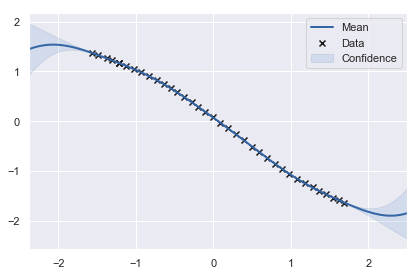

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


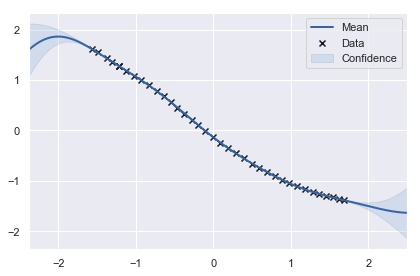

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


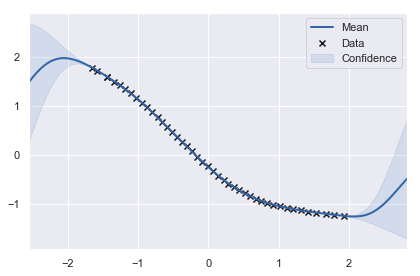

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


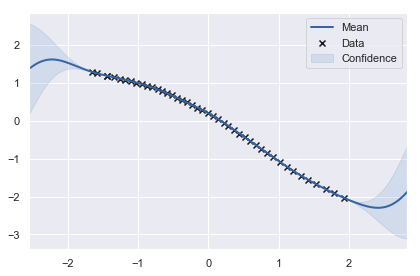

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


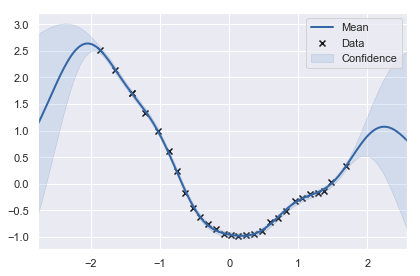

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


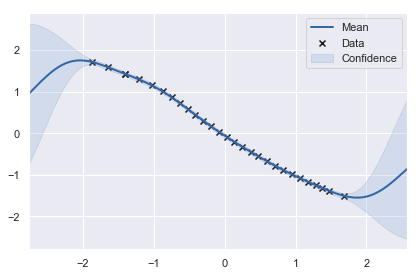

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


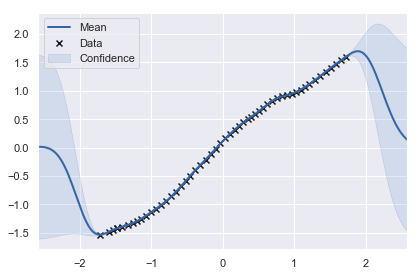

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


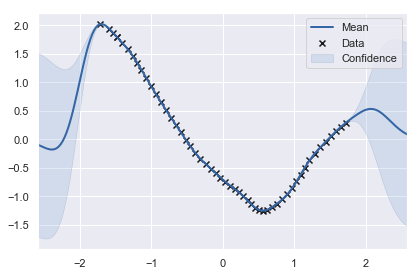

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


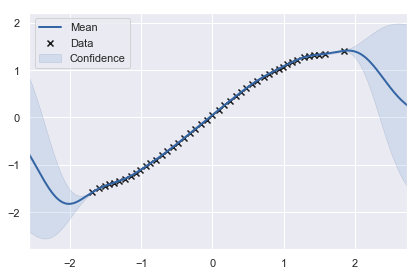

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


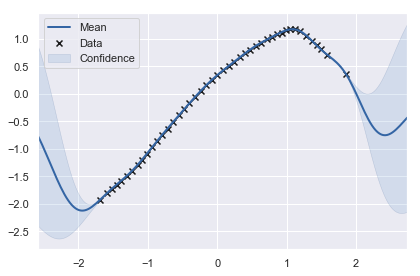

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


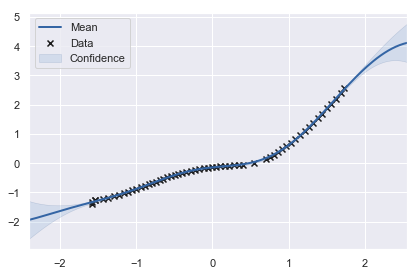

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


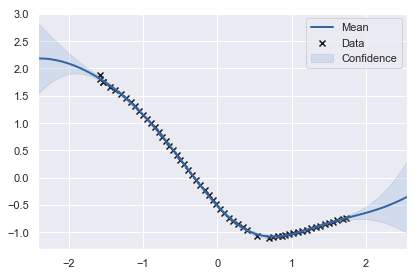

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


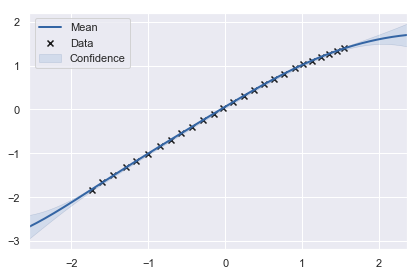

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


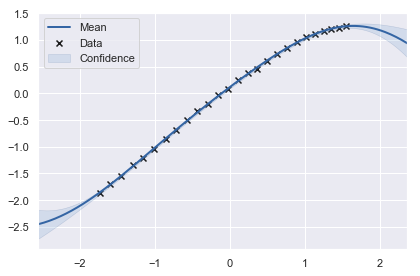

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


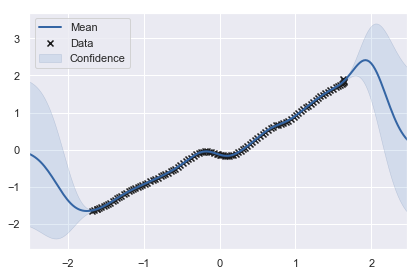

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


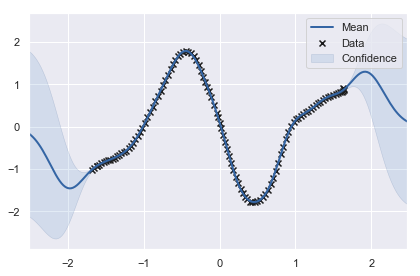

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


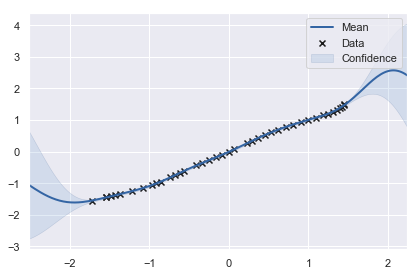

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


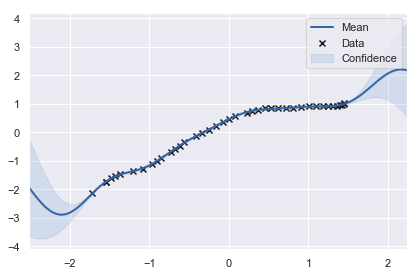

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


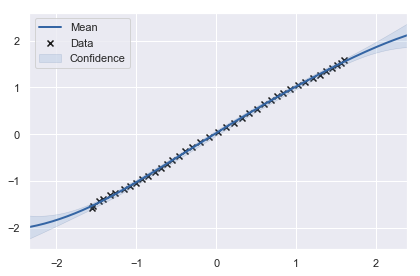

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


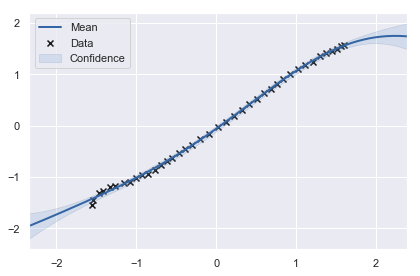

In [6]:
for seg_n in n_segs:
    lik_model = gp.load(LIKELIHOOD_MODEL, route_n, traj_to_plot, seg_n)
    lik_model.model.plot(which_data_ycols=[0])
    lik_model.model.plot(which_data_ycols=[1])
    #print(lik_model.model)
    #gp.plot(lik_model)
    

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


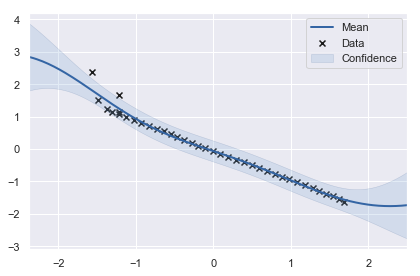

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


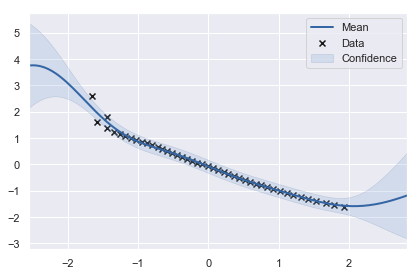

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


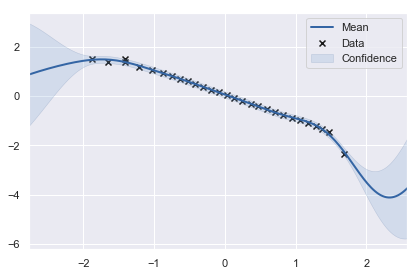

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


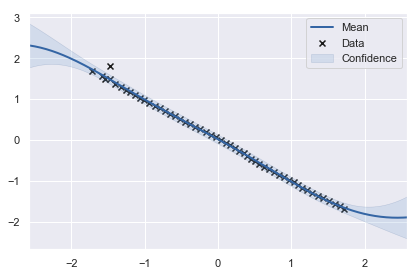

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


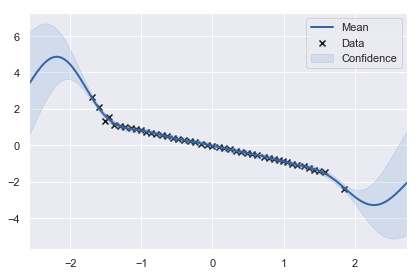

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


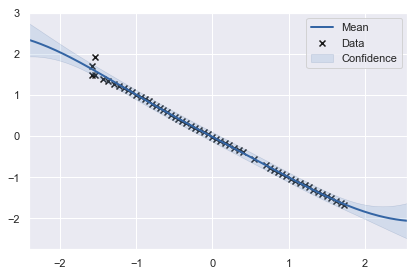

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


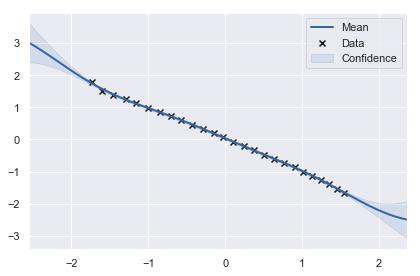

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


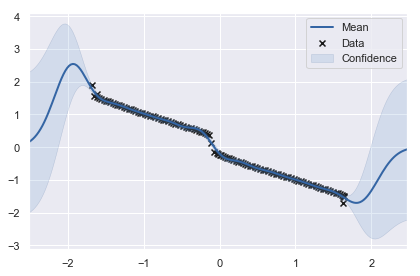

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


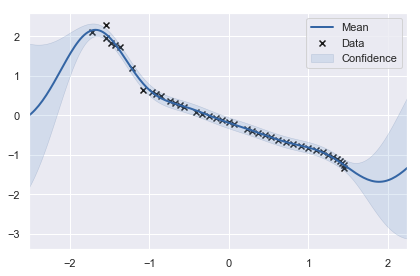

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


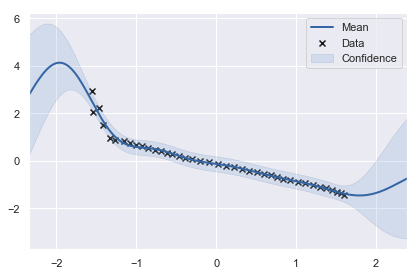

In [7]:
for seg_n in n_segs:
    pred_model = gp.load(PREDICTION_MODEL, route_n, traj_to_plot, seg_n)
    gp.plot(pred_model)
    #print(pred_model.model)
    

Let's do the same for the predictive GP

In [56]:
import GPy
traj_one_gps = traj_gps[list(traj_gps.keys())[0]]
for lik_model, pred_model in traj_one_gps.values():
    print(pred_model.route_n, pred_model.traj_n, pred_model.seg_n)
    pred_model.model.plot()

NameError: name 'traj_gps' is not defined

The results for both the GPs look really good. We'll save both to disk.

## Prediction
After having trained the GPs the model can now be presented with a new trajectory, look at the ones it has previously seen, rank them by likelihood and use them to make arrival time predictions.

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\ipykernel_launcher.py:21: FutureWarning:Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



true model 3 24 5
pred: 48.08 true: 50.0 MAE: 1.92 MAPE: 0.04


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


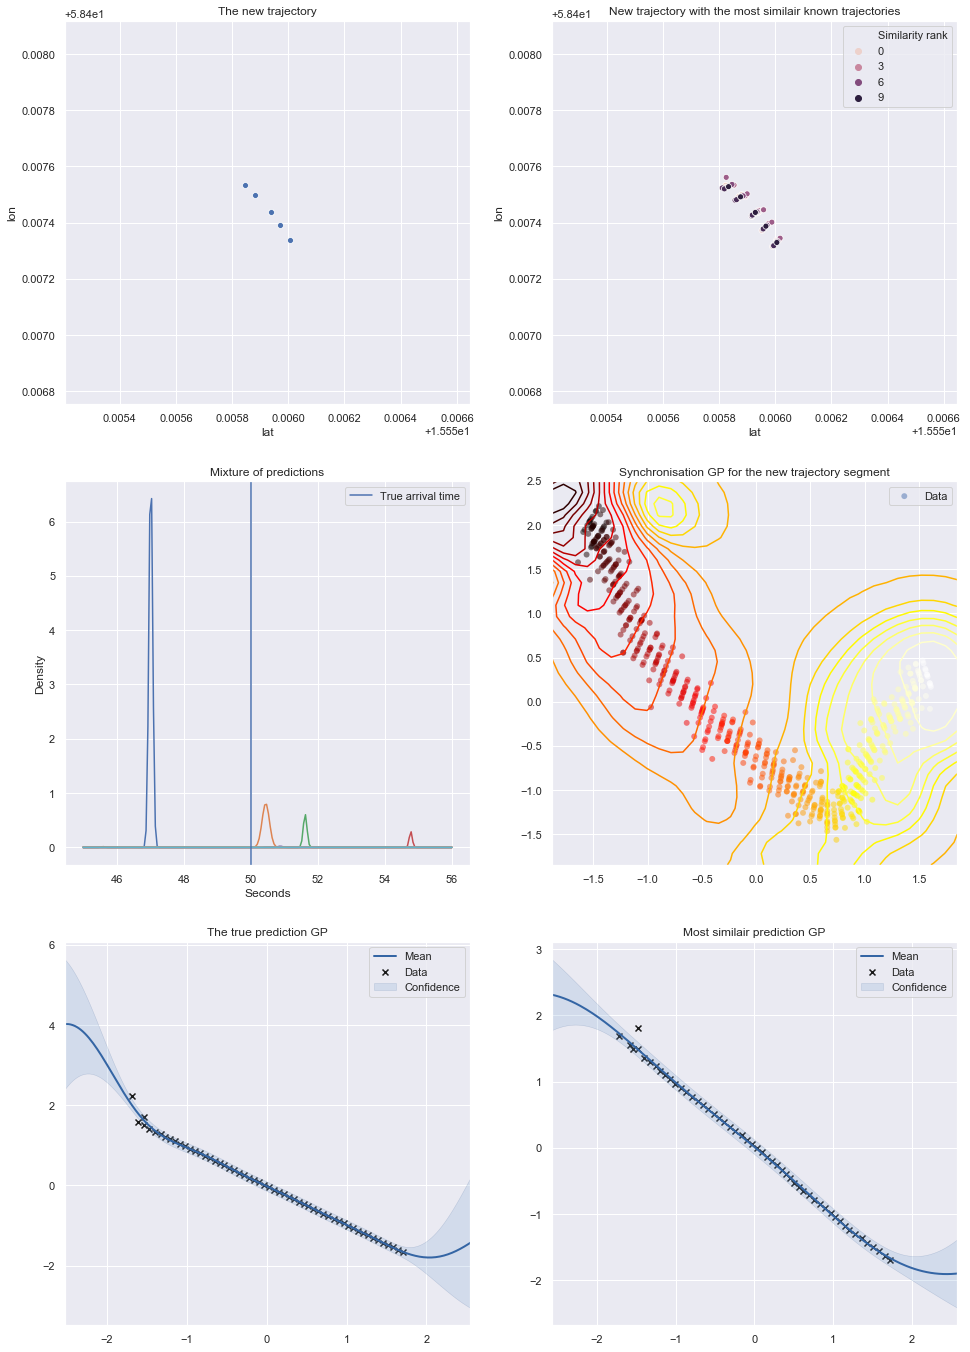

In [12]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import math

def plot_likelihood_models(models_by_loglik, synched_traj):
    
    def to_df(m, i):
        df = pd.DataFrame(gp.predict(m, X)[0], columns=['lat' ,'lon'])
        df['Similarity rank'] = i
        return df
    
 
    #print([(m[0].route_n, m[0].traj_n, m[0].seg_n) for m in models_by_loglik[:n_models_to_plot]])
    X = synched_traj[['tau']].values
    n_models_to_plot = 10
    models_to_plot = models_by_loglik[:n_models_to_plot]
    n_models = len(models_to_plot)
    dfs = [to_df(mloglik[0], i) for mloglik, i in zip(models_to_plot, range(n_models))]
    traj_df = synched_traj.copy()
    traj_df['Similarity rank'] = 0
    plt_df = pd.concat([traj_df] + dfs)
    
    sns.scatterplot(data=plt_df, x='lat', y='lon', hue='Similarity rank', ax=axs[0, 1])
    axs[0, 1].set_title('New trajectory with the most similair known trajectories')
    axs[0, 1].set_aspect('equal', 'datalim')    
    center_axs(axs[0, 1], synched_traj, ['lat', 'lon'])

    
def center_axs(ax, data, XY):
    ax.set_xlim(data[XY[0]].min()*0.99999, data[XY[0]].max()*1.00001)
    ax.set_ylim(data[XY[1]].min()*0.99999, data[XY[1]].max()*1.00001)
    
def mogp(traj, synch_gp, route_n, seg_n, plot):
    
    def data_loglik(model, X, Y):
        def loglik(x, y):
            mu, sigma = gp.predict(model, x.reshape(1, 1))
            return -0.5*(y-mu)*np.linalg.inv(sigma)*(y-mu).T \
                    -0.5*np.log(np.abs(sigma))
        return np.sum([loglik(x, y) for x, y in zip(X, Y)])
        
    def make_prediction(model, data):
        X = data[['lat', 'lon']].values.reshape(data.shape[0], 2)
        return gp.predict(model, X)

    def corresponding_pred_model(lik_model):
        return gp.load(PREDICTION_MODEL, lik_model.route_n, lik_model.traj_n, lik_model.seg_n)
        
    def weighted_models(synched_traj, models):
        """
        Returns models and their weights, weighted by the posterior predictive probability of the model
        normalised over the maximum likelihood assuming uniform model prior. 
        So the most probable model has weight w = 1.0, and the less likely models has weights 0 < w < 1.0.
        """
        X = synched_traj[['tau']].values
        Y = synched_traj[['lat', 'lon']].values
        models_with_loglik = [(m, data_loglik(m, X, Y)) for m in models]
        models_by_loglik = sorted(models_with_loglik, key=lambda mw: mw[1], reverse=True)
        max_loglik = models_by_loglik[0][1]
        
        if plot:
            plot_likelihood_models(models_by_loglik, synched_traj)
            
        return [(m, np.exp(loglik - max_loglik)) for m, loglik in models_by_loglik]
    
    synched_traj = synch_traj(synch_gp, traj)
    lik_models = gp.load_trajs(LIKELIHOOD_MODEL, route_n, seg_n)
    lik_models_with_weights = weighted_models(synched_traj, lik_models)
    pred_models_with_weights = [(corresponding_pred_model(lik_m), w) for lik_m, w in lik_models_with_weights]
    #print('Most similair model', lik_models_with_weights[0][0].route_n, lik_models_with_weights[0][0].traj_n, lik_models_with_weights[0][0].seg_n)
    
    if plot:
        pred_models_with_weights[0][0].model.plot(ax=axs[2, 1])
        axs[2, 1].set_title('Most similair prediction GP')
        
    latest_tau = synched_traj.iloc[-1][['tau']].values.reshape(1, 1)
    mean_var_weights = [gp.predict(m, latest_tau) + (w,) for m, w in pred_models_with_weights]
    return mean_var_weights

def predict(traj, synch_gp, route_n, seg_n, arrival_time=None, plot=False):
    mean_var_weights = mogp(traj, synch_gp, route_n, seg_n, plot)
    # Don't use all routes. The later ones have crazy small weights
    # leading to numerical issues.
    mean_var_weights = mean_var_weights[:10] 
    if plot:
        sort = sorted(mean_var_weights, key=lambda mvw: mvw[0])
        xmin = max(0, np.floor(float(sort[0][0]-sort[0][1]*3)))
        xmax = np.ceil(float(sort[-1][0]+sort[-1][1]*3))
        x = np.linspace(xmin, xmax, 200)
        for mean, var, w in mean_var_weights:
            axs[1,0].plot(x, w*norm.pdf(x, float(mean), np.sqrt(float(var))))
            
        axs[1,0].set_title('Mixture of predictions')
        axs[1,0].set_xlabel('Seconds')
        axs[1,0].set_ylabel('Density')
        if arrival_time:
            axs[1,0].axvline(x=arrival_time, label='True arrival time')
            axs[1,0].legend()
    
    #models_by_similarity = sorted(mean_var_weights, key=lambda p: p[2], reverse=True)
    #models_by_mode = sorted(mean_var_weights, key=lambda p: p[0]*p[2], reverse=True)
    total_weight = sum([w for _, _, w in mean_var_weights])
    weighted_mean = sum([w*float(mean) for mean, var, w in mean_var_weights])/total_weight
    
    #weighted_means = [w*float(mean) for mean, var, w in mean_var_weights]
    #print(weighted_means)
    #mode_model = models_by_mode[0] #mean_var_weights[np.argmax(weighted_means)]
    
    #print(mode_model)
    #n = 200
    #distribution = np.sum([norm.pdf(n, float(mean), np.sqrt(float(var))) for mean, var, w in mean_var_weights])
   
    #print(weighted_means)
    #print(mode_model)
    return weighted_mean #float(mode_model[0])

#np.random.seed(8)
plot = True
if plot:
    fig, axs = plt.subplots(3,2)
    fig.set_figwidth(16)
    fig.set_figheight(24)
    
test = train #pd.read_pickle('test.pkl')
n_test_trajs_to_use = 38
n_test_trajs = test.traj.unique()
test = test[test.traj < n_test_trajs[n_test_trajs_to_use]]
traj_n = n_test_trajs[0]
test_traj = test[test.traj == traj_n]
seg_ix = 3
seg_n = test_traj.seg.unique()[seg_ix]
test_seg = test_traj[test_traj.seg == seg_n]
def predict_seg_with_plots(seg, route_n, seg_n, true_pred_gp=None):
    i = test_seg.index[0]+5 #np.random.randint(test_seg.index[0], test_seg.index[-1])
    seg = seg[seg.index <= i]
    synch_gp = gp.load_synch(route_n, seg_n, version=2)
    true = seg.iloc[-1].time_left
    pred = predict(seg, synch_gp, route_n, seg_n, true, plot=True)
    mae = float(np.abs(true-pred))
    mape = float(np.abs((true-pred)/true))
    print('true model', route_n, traj_n, seg_n)
    print('pred:', f"{pred:.2f}", 'true:', float(true), 'MAE:', f"{mae:.2f}", 'MAPE:', f"{mape:.2f}")
    
    sns.scatterplot(data=seg, x='lat', y='lon', ax=axs[0, 0])
    axs[0, 0].set_title('The new trajectory')
    axs[0, 0].set_aspect('equal', 'datalim')
    center_axs(axs[0, 0], seg, ['lat', 'lon'])
    
    synch_gp.model.plot(ax=axs[1,1])
    axs[1,1].set_title('Synchronisation GP for the new trajectory segment')
    if true_pred_gp:
        true_pred_gp.model.plot(ax=axs[2, 0])
        axs[2,0].set_title('The true prediction GP')
    
#print(test_seg[['lat', 'lon']])
pred_gp = gp.load(PREDICTION_MODEL, route_n, traj_n, seg_n)
predict_seg_with_plots(test_seg, route_n, seg_n, true_pred_gp=pred_gp)

In [378]:
mae = []
mape = []
n_test_segs = test.seg.unique()
for seg_n in n_test_segs:
    seg = test[test.seg == seg_n]
    synch_gp = gp.load_synch(route_n, seg_n, version=2)
    for traj_n in seg.traj.unique():
        traj = seg[seg.traj == traj_n]
        i = np.random.randint(traj.index[0], traj.index[-1])
        traj = traj[traj.index <= i]
        true = traj.iloc[-1].time_left
        pred = predict(traj, synch_gp, route_n, int(seg_n), true, plot=False)
        mae.append(float(np.abs(true-pred)))
        mape.append(float(np.abs((true-pred)/true)))

print('MAPE: ', np.sum(mape)/len(mape))
print('MAE: ', np.sum(mae)/len(mae))

Most similair model 3 50 2
Most similair model 3 50 2
Most similair model 3 87 2
Most similair model 3 50 2
Most similair model 3 159 2
Most similair model 3 87 2
Most similair model 3 50 2
Most similair model 3 50 2
Most similair model 3 50 2
Most similair model 3 159 2
Most similair model 3 50 2
Most similair model 3 66 2
Most similair model 3 50 2
Most similair model 3 159 2
Most similair model 3 66 2
Most similair model 3 159 2
Most similair model 3 171 2
Most similair model 3 87 2
Most similair model 3 87 2
Most similair model 3 50 2
Most similair model 3 50 2
Most similair model 3 87 2
Most similair model 3 171 2
Most similair model 3 87 2
Most similair model 3 50 2
Most similair model 3 50 2
Most similair model 3 50 2
Most similair model 3 66 2
Most similair model 3 87 2
Most similair model 3 50 2
Most similair model 3 87 2
Most similair model 3 87 2
Most similair model 3 50 2
Most similair model 3 87 2
Most similair model 3 50 2
Most similair model 3 50 2
Most similair model 3 

Most similair model 3 11 8
Most similair model 3 11 8
Most similair model 3 159 8
Most similair model 3 11 8
Most similair model 3 11 8
Most similair model 3 159 8
Most similair model 3 11 8
Most similair model 3 11 8
Most similair model 3 16 8
Most similair model 3 11 8
Most similair model 3 16 8
Most similair model 3 159 8
Most similair model 3 11 8
Most similair model 3 159 8
Most similair model 3 11 8
Most similair model 3 11 8
Most similair model 3 109 8
Most similair model 3 159 8
Most similair model 3 109 8
Most similair model 3 11 8
Most similair model 3 109 8
Most similair model 3 16 8
Most similair model 3 11 8
Most similair model 3 109 8
Most similair model 3 159 8
Most similair model 3 11 8
Most similair model 3 11 8
Most similair model 3 109 8
Most similair model 3 11 8
Most similair model 3 109 8
Most similair model 3 11 8
Most similair model 3 159 8
Most similair model 3 11 8
Most similair model 3 159 8
Most similair model 3 159 8
Most similair model 3 11 8
Most similair

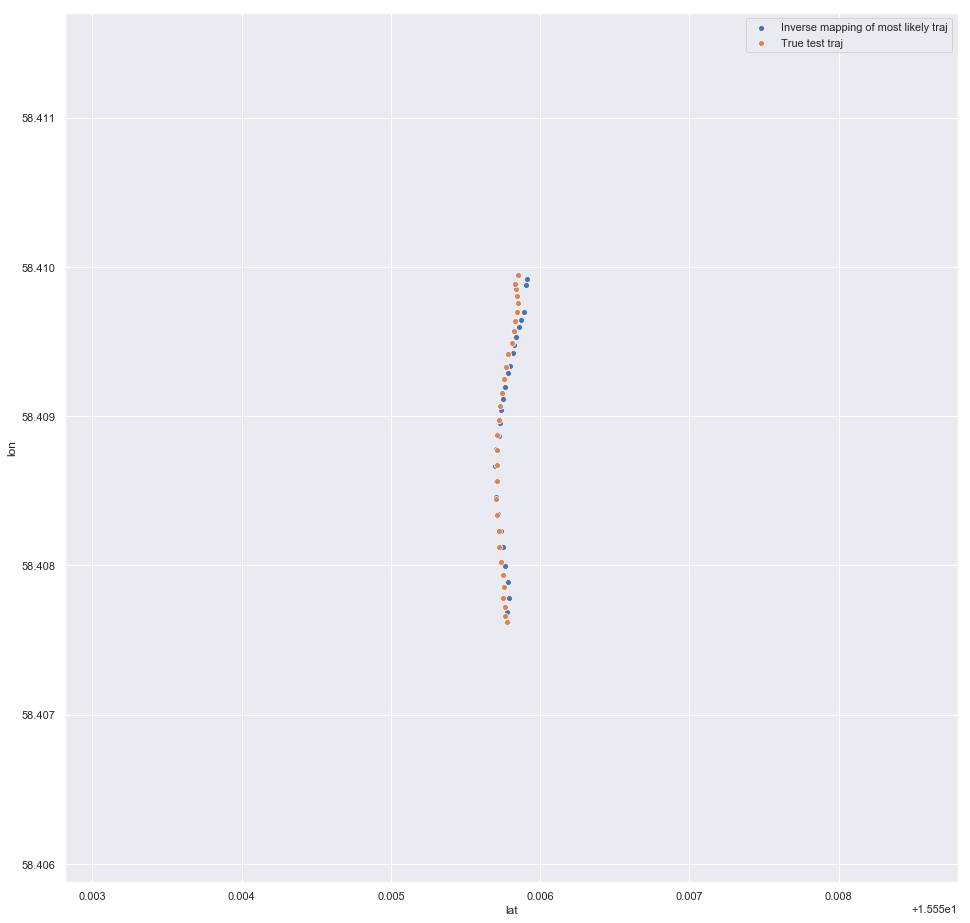

In [8]:
sgp = gp.load_synch(route_n, seg_n, version=2)
s_traj = synch_traj(sgp, test_seg)
m = gp.load(LIKELIHOOD_MODEL, 3, 139, seg_n)
df = pd.DataFrame(gp.predict(m, s_traj[['tau']].values)[0], columns=['lat' ,'lon'])
fig, ax = plt.subplots(1, 1)
ax = sns.scatterplot(data=df, x='lat', y='lon', label='Inverse mapping of most likely traj')
sns.scatterplot(data=test_seg, x='lat', y='lon', ax=ax, label='True test traj')
ax.set_aspect('equal', 'datalim')
fig.set_figwidth(16)
fig.set_figheight(16)

30
0


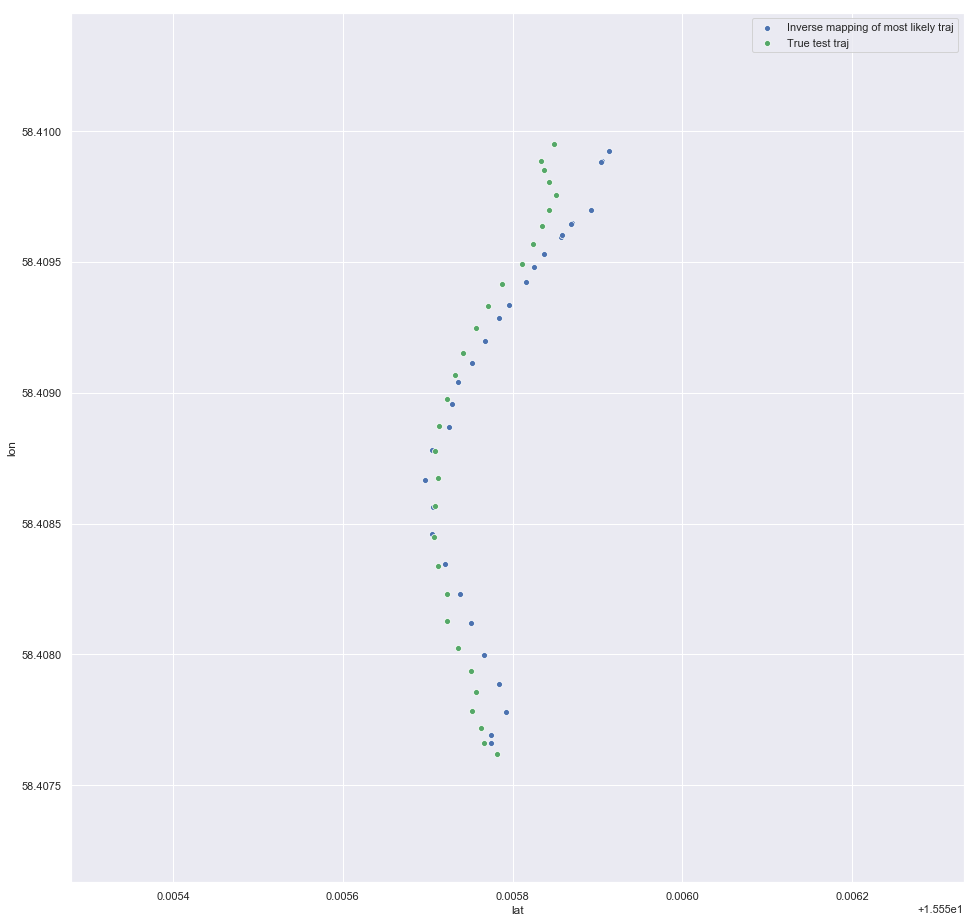

In [9]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(16)
fig.set_figheight(16)
most_likely_seg = train[(train.traj == 139) & (train.seg == seg_n)]
ax = sns.scatterplot(data=df, x='lat', y='lon', label='Inverse mapping of most likely traj')
sns.scatterplot(data=most_likely_seg, x='lat', y='lon', ax=ax, label='True most likely traj')
sns.scatterplot(data=test_seg, x='lat', y='lon', ax=ax, label='True test traj')
print(test_seg.shape[0])
print(most_likely_seg.shape[0])
for a, b in (zip(test_seg.time_left, most_likely_seg.time_left)):
    print(a, b)

Segments 1.0, 1.2, 1.4 are strange, does not seem to converge on one trajectory. Segment 4.2 has an 11 second jump at the final data point

In [ ]:
abs_errs = []

n_test_segs = test.seg.unique()
for traj_n in n_test_segs:
    traj = test[test.traj == traj_n]
    n_traj_segs = traj.seg.unique()
    for seg_n in n_traj_segs[0:1]:
        seg = traj[traj.seg == seg_n]
        i = np.random.randint(seg.index[0], seg.index[-1]-1)
        seg = seg[seg.index < i]
        synch_gp = gp.load_synch(route_n, seg_n, version=2)
        pred = predict(seg, synch_gp, route_n, seg_n)
        true = test_seg.iloc[-1].time_left
        abs_errs.append(np.abs((true-pred)/true))

mape = np.mean(abs_errs)
mape

In [ ]:
print(abs_errs)